In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys; sys.path.append("../../..")
import warnings; warnings.filterwarnings('ignore')

from core import *
from train_functions import ave_auc
from utils import save_model
from skimage.feature import greycomatrix, greycoprops
from scipy.stats import moment

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

/data/miguel/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
PATH = Path('../../../../data')
IMG_FOLDER_PATH = PATH/'ChestXRay-250'
TRADITIONAL_DATA_PATH = PATH/'traditional/14diseases/data'
TRADITIONAL_MODELS_PATH = PATH/'traditional/14diseases/models'

# Numerical features creation

In [3]:
def read_image_gray(path):
    im = cv2.imread(str(path)).astype(np.uint8)
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

def GLCM_features(im):
    GLCM = greycomatrix(im,[1,2,4,6], [0, np.pi/4, np.pi/2])
    properties = ['contrast','dissimilarity','homogeneity','ASM', 'energy', 'correlation']
    GLCM_features= [greycoprops(GLCM, prop) for prop in properties]
    return np.concatenate(GLCM_features).flatten()

def statistical_features(im):
    stat_feat1 = [np.mean(im),np.std(im)]
    stat_feat2 = [moment(im,moment=i,axis=None) for i in range(2,6)]
    return np.array(stat_feat1+stat_feat2)

def entropy(im):
        '''
        From https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/basicFunctions.html
        function returns entropy of a signal
        signal must be a 1-D numpy array
        '''
        signal = im.flatten()
        symset=list(set(signal))
        lensig=float(signal.size)
        propab=[np.size(signal[signal==i])/lensig for i in symset]
        ent=np.sum([p*np.log2(1.0/p) for p in propab])
        return np.array([ent])
    
def extract_features(im):
    features = [GLCM_features, statistical_features, entropy]
    return np.concatenate([feature(im) for feature in features])

def read_extract(im_path):
    im = read_image_gray(im_path)
    return extract_features(im)

def labels2array(x):
    return np.array(x.split(' ')).astype(int)

def read_img2features(df, base_path):
    '''Reads  all the images under base_path/ImageIndex and extracts their features. 
    
    :param df: df with columns ImageIndex and Labels.
    :param base_path: base path such that base_path/ImageIndex is the location of the image.
    :return: X - numerical features, Y - labels
    '''
    X = np.array([read_extract(base_path/row) for row in tqdm_notebook(df.ImageIndex)])
    Y = df.Label.values
    try: Y = np.array(list(map(labels2array, Y))) # 14 labels
    except: Y = Y.astype(int) # 1 label
    return X,Y

In [4]:
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

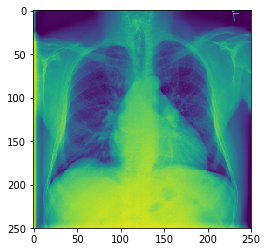

In [5]:
im = read_image_gray(str(IMG_FOLDER_PATH/train_df.ImageIndex[0]))
plt.imshow(im)

In [6]:
# Extract numerical features

def replacy_by_mean(array):
    means = np.nanmean(array,axis=0)
    mask = np.where(np.isnan(array))
    array[mask] = np.take(means, mask[1])
    return array

def extract_save(train_df, valid_df, test_df):
    
    X_train, Y_train = read_img2features(train_df, base_path=IMG_FOLDER_PATH)
    X_valid, Y_valid = read_img2features(valid_df, base_path=IMG_FOLDER_PATH)
    X_test, Y_test = read_img2features(test_df, base_path=IMG_FOLDER_PATH)

    # quantify NA's 

    # print(f"# {np.isnan(X_train).sum(axis=1).sum()} - {np.isnan(X_train).sum(axis=1).sum()/X_train.shape[0]:.3f}%")
    # print(f"# {np.isnan(X_valid).sum(axis=1).sum()} - {np.isnan(X_valid).sum(axis=1).sum()/X_valid.shape[0]:.3f}%")
    # print(f"# {np.isnan(X_test).sum(axis=1).sum()} - {np.isnan(X_test).sum(axis=1).sum()/X_test.shape[0]:.3f}%")

    # replace Na's 

    X_train, X_valid, X_test = map(replacy_by_mean, [X_train, X_valid, X_test])

    # save

    np.save(TRADITIONAL_DATA_PATH/'X_train', X_train)
    np.save(TRADITIONAL_DATA_PATH/'Y_train', Y_train)

    np.save(TRADITIONAL_DATA_PATH/'X_valid', X_valid)
    np.save(TRADITIONAL_DATA_PATH/'Y_valid', Y_valid)

    np.save(TRADITIONAL_DATA_PATH/'X_test', X_test)
    np.save(TRADITIONAL_DATA_PATH/'Y_test', Y_test)
    
# Run once
# extract_save(train_df, valid_df, test_df)

In [7]:
# Load

X_train = np.load(TRADITIONAL_DATA_PATH/'X_train.npy')
Y_train = np.load(TRADITIONAL_DATA_PATH/'Y_train.npy')

X_valid = np.load(TRADITIONAL_DATA_PATH/'X_valid.npy')
Y_valid = np.load(TRADITIONAL_DATA_PATH/'Y_valid.npy')

X_test = np.load(TRADITIONAL_DATA_PATH/'X_test.npy')
Y_test = np.load(TRADITIONAL_DATA_PATH/'Y_test.npy')

# Training

Sklearn does not currently support multi-label logistic regression with all (l1, l2 and l1 & l2) regularizations that we want to use. Therefore, we implemented those with a swallow neural network and modified loss functions in PyTroch.

## DATASET

In [9]:
class feature_ds(Dataset):

    def __init__(self, X,Y):
        self.X = X.astype(np.float32)
        self.Y = Y.astype(np.float32)

    def __getitem__(self, index):
        x = self.X[index,:]
        y = self.Y[index,:]
        return x, y

    def __len__(self): return self.X.shape[0]

## ARCHITECTURE

In [10]:
class multilabel_log_reg(nn.Module):
    
    def __init__(self, in_dim=79, out_dim=14): 
        super(multilabel_log_reg, self).__init__()
        self.linear = nn.Linear(in_features=in_dim,out_features=out_dim)
        
    def forward(self, x):
        out = self.linear(x)
        return out

## REGULARIZATIONS

In [11]:
# Note: We are using L1 and L2 regularization, NOT weight decay!
def ridge_regularization(model, **kwarg):
    return sum([kwarg['alpha']*torch.norm(p, 2) for p in model.parameters()])

def lasso_regularization(model, **kwarg):
    return sum([kwarg['alpha']*torch.norm(p,1) for p in model.parameters()])
            
def elastic_net_regularization(model, **kwarg):
    wgt_l1 = kwarg['l1_ratio']*kwarg['alpha']
    wgt_l2 = (1-kwarg['l1_ratio'])*kwarg['alpha']
    return sum([wgt_l1*torch.norm(p,1) + wgt_l2*torch.norm(p,2) for p in model.parameters()])

reg_dic = {'ridge': ridge_regularization,
           'lasso': lasso_regularization,
           'elastic-net': elastic_net_regularization}

## VALIDATION LOOP

In [12]:
def validation(model, valid_dl):
    '''
    
    :return: val loss (with regularization), average auc
    '''
    model.eval()
    total = 0
    sum_loss = 0
    
    ys = []
    logits = []
    
    for x, y in valid_dl:
        batch = y.shape[0]
        x, y = x.cuda(), y.cuda()
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(input=out,target=y)
        
        
        y.shape[0]
        sum_loss += batch * (loss.item())
        total += batch
        
        logits.append(out.cpu().detach().numpy())
        ys.append(y.long().cpu().numpy())

    ys = np.vstack(ys)
    logits = np.vstack(logits)
    auc, _ = ave_auc(logits, ys)

    return sum_loss / total, auc

## TRAINING LOOP

In [13]:


def train(model, dl_train, dl_val, path, reg_type, lr_high=1e-2, lr_low=1e-7, epochs=4, epsilon=.01, **kwarg):
    
    lr = lr_high
    prev_loss = np.inf
    min_loss = np.inf
    reg_f = reg_dic[reg_type]
    
    for epoch in tqdm_notebook(range(epochs), leave=False):
        model.train()
        total,sum_loss = 0,0
        optim = torch.optim.Adam(model.parameters(), lr=lr)
        for x,y in dl_train:

            x,y = x.cuda(),y.cuda()
            
            pred = model(x)
            loss = F.binary_cross_entropy_with_logits(input=pred,target=y) + reg_f(model, **kwarg)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

            batch = y.shape[0]
            sum_loss += batch * (loss.item())
            total += batch

        val_loss, auc = validation(model, dl_val)
        
        if epoch%10==0: print(f"lr {lr:.7f} train loss {sum_loss/total:.3f} - val loss {val_loss} avg AUC - {auc}")
        
        if val_loss - prev_loss > epsilon:
            lr = lr / 10.0
        if val_loss < min_loss:
            save_model(model, path)
            min_loss = val_loss
        prev_loss = val_loss
        if lr < lr_low:
            break
    return min_loss

# Linear models: hyper-parameter tunning

We do that with the whole training dataset.

In [14]:
train_ds = feature_ds(X_train, Y_train)
valid_ds = feature_ds(X_valid, Y_valid)
# test_ds = feature_ds(X_test, Y_test)

dl_train = DataLoader(train_ds, batch_size=Y_train.shape[0], shuffle=True)
dl_valid = DataLoader(valid_ds, batch_size=Y_valid.shape[0], shuffle=True)
# dl_test = DataLoader(test_ds, batch_size=Y_test.shape[0], shuffle=True)

## Ridge

In [15]:
# scope
grid = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,4,8,16,32,64]

# initialization
min_val_loss, min_path, min_alpha = np.inf, None, None

# iteration
for alpha in grid:
    print(f"alpha: {alpha}")
    
    kwarg = {'alpha': alpha}
    lin_model = multilabel_log_reg().cuda()
    
    save_path = TRADITIONAL_MODELS_PATH/'ridge_{alpha}.pth'
    
    val_loss = train(model=lin_model, dl_train=dl_train, dl_val=dl_valid, 
                     reg_type='ridge', path=save_path, lr_low=1e-6, lr_high=1e-2,
                     epochs=50, **kwarg)
    
    
    # Save the best model
    if min_val_loss > val_loss:
        min_alpha = alpha
        if min_path: os.remove(min_path)
        min_path = save_path
    else:
        os.remove(save_path)
        
min_alpha

alpha: 0.1


A Jupyter Widget

lr 0.0100000 train loss 57457668.000 - val loss 43985180.0 avg AUC - 0.5209512696433005
lr 0.0010000 train loss 2566163.750 - val loss 1989931.625 avg AUC - 0.5147845943709277
lr 0.0001000 train loss 509945.812 - val loss 450923.1875 avg AUC - 0.5255946086336477
lr 0.0001000 train loss 393392.969 - val loss 362688.875 avg AUC - 0.5265984149616636
lr 0.0001000 train loss 378750.219 - val loss 351168.28125 avg AUC - 0.5263696271446354
alpha: 0.2


A Jupyter Widget

lr 0.0100000 train loss 70681544.000 - val loss 56221780.0 avg AUC - 0.5023585891941966
lr 0.0010000 train loss 3735429.500 - val loss 2999097.5 avg AUC - 0.5013282007700995
lr 0.0001000 train loss 590410.062 - val loss 518474.75 avg AUC - 0.5182762379802813
lr 0.0001000 train loss 497858.438 - val loss 445110.53125 avg AUC - 0.5177710665600195
lr 0.0001000 train loss 484770.688 - val loss 434390.71875 avg AUC - 0.5173319858648174
alpha: 0.3


A Jupyter Widget

lr 0.0100000 train loss 38946768.000 - val loss 31812820.0 avg AUC - 0.4812820245868534
lr 0.0100000 train loss 2917287.250 - val loss 3636974.75 avg AUC - 0.5075012281233046
lr 0.0010000 train loss 478164.062 - val loss 447197.875 avg AUC - 0.5149658735732193
lr 0.0001000 train loss 432274.625 - val loss 392610.21875 avg AUC - 0.5131867737806611
lr 0.0001000 train loss 420989.250 - val loss 383749.75 avg AUC - 0.5124183389926681
alpha: 0.4


A Jupyter Widget

lr 0.0100000 train loss 50628488.000 - val loss 41618036.0 avg AUC - 0.4857456370487171
lr 0.0010000 train loss 3442440.750 - val loss 2723904.75 avg AUC - 0.5220155740957682
lr 0.0010000 train loss 704844.000 - val loss 639404.4375 avg AUC - 0.5204760479424688
lr 0.0001000 train loss 661435.750 - val loss 549565.125 avg AUC - 0.5181190677687291
lr 0.0001000 train loss 645015.625 - val loss 536268.0 avg AUC - 0.5183299502685146
alpha: 0.5


A Jupyter Widget

lr 0.0100000 train loss 62781608.000 - val loss 51191948.0 avg AUC - 0.5107115078245853
lr 0.0100000 train loss 2339099.250 - val loss 3597005.5 avg AUC - 0.5001943182757236
lr 0.0010000 train loss 485794.312 - val loss 444353.90625 avg AUC - 0.5190051694265554
lr 0.0001000 train loss 414390.438 - val loss 384778.21875 avg AUC - 0.5208608761547089
lr 0.0001000 train loss 402990.500 - val loss 374582.90625 avg AUC - 0.5209308268891902
alpha: 0.6


A Jupyter Widget

lr 0.0100000 train loss 72192736.000 - val loss 58191932.0 avg AUC - 0.512496062709095
lr 0.0010000 train loss 2802269.250 - val loss 2183197.25 avg AUC - 0.514827936954936
lr 0.0001000 train loss 755357.312 - val loss 642897.1875 avg AUC - 0.5187349696645047
lr 0.0001000 train loss 687855.562 - val loss 591870.875 avg AUC - 0.5193298638333511
lr 0.0001000 train loss 670626.125 - val loss 576475.9375 avg AUC - 0.5190327495428638
alpha: 0.7


A Jupyter Widget

lr 0.0100000 train loss 34582248.000 - val loss 24563458.0 avg AUC - 0.5059727383695437
lr 0.0010000 train loss 6556531.000 - val loss 6091224.5 avg AUC - 0.5115899622781754
lr 0.0010000 train loss 4332199.000 - val loss 4098440.25 avg AUC - 0.5164286422128777
lr 0.0010000 train loss 2767531.250 - val loss 2574626.0 avg AUC - 0.5203375468922482
lr 0.0010000 train loss 1448098.625 - val loss 1307265.25 avg AUC - 0.5201009448428406
alpha: 0.8


A Jupyter Widget

lr 0.0100000 train loss 35464660.000 - val loss 24546598.0 avg AUC - 0.5005307238501858
lr 0.0010000 train loss 1682371.625 - val loss 1215816.0 avg AUC - 0.5250747304181472
lr 0.0001000 train loss 376716.438 - val loss 326086.78125 avg AUC - 0.5230109113319238
lr 0.0001000 train loss 335988.062 - val loss 298067.84375 avg AUC - 0.523731832988704
lr 0.0001000 train loss 320592.250 - val loss 285978.71875 avg AUC - 0.5237395916269115
alpha: 0.9


A Jupyter Widget

lr 0.0100000 train loss 65657916.000 - val loss 54131068.0 avg AUC - 0.507539217352032
lr 0.0010000 train loss 3572097.500 - val loss 2803264.5 avg AUC - 0.5161275331721981
lr 0.0001000 train loss 410461.781 - val loss 345641.34375 avg AUC - 0.5252294674855713
lr 0.0001000 train loss 357475.312 - val loss 305458.625 avg AUC - 0.5236436866575996
lr 0.0001000 train loss 346287.156 - val loss 295962.4375 avg AUC - 0.5237250294549946
alpha: 1


A Jupyter Widget

lr 0.0100000 train loss 58185112.000 - val loss 47714504.0 avg AUC - 0.5054060605979961
lr 0.0100000 train loss 3432284.250 - val loss 2092574.875 avg AUC - 0.5060376081564145
lr 0.0010000 train loss 481039.875 - val loss 450285.3125 avg AUC - 0.5211886550819959
lr 0.0001000 train loss 439835.844 - val loss 396927.5625 avg AUC - 0.5257786940585184
lr 0.0001000 train loss 430272.094 - val loss 388751.25 avg AUC - 0.526036821030517
alpha: 2


A Jupyter Widget

lr 0.0100000 train loss 69396104.000 - val loss 56154544.0 avg AUC - 0.508159163537678
lr 0.0100000 train loss 3291192.500 - val loss 3175400.75 avg AUC - 0.5158071522933045
lr 0.0001000 train loss 581988.875 - val loss 509144.0625 avg AUC - 0.5272701604347384
lr 0.0001000 train loss 525238.188 - val loss 466600.71875 avg AUC - 0.5265542498581018
lr 0.0001000 train loss 512099.750 - val loss 456178.84375 avg AUC - 0.5262999877759155
alpha: 4


A Jupyter Widget

lr 0.0100000 train loss 32612852.000 - val loss 24817260.0 avg AUC - 0.4923505902627773
lr 0.0010000 train loss 3407123.000 - val loss 2699889.5 avg AUC - 0.5107355727430827
lr 0.0001000 train loss 487959.969 - val loss 405358.15625 avg AUC - 0.5214917160797343
lr 0.0001000 train loss 392229.625 - val loss 332280.65625 avg AUC - 0.5240561642839826
lr 0.0001000 train loss 379111.594 - val loss 321285.8125 avg AUC - 0.5237614536658584
alpha: 8


A Jupyter Widget

lr 0.0100000 train loss 39126400.000 - val loss 29123334.0 avg AUC - 0.4828246682524049
lr 0.0010000 train loss 2799963.500 - val loss 2087959.75 avg AUC - 0.5062285285181598
lr 0.0010000 train loss 540692.500 - val loss 468757.875 avg AUC - 0.5172245754256014
lr 0.0001000 train loss 442815.656 - val loss 387354.21875 avg AUC - 0.5195082816596907
lr 0.0001000 train loss 426987.375 - val loss 374652.96875 avg AUC - 0.5196644992296078
alpha: 16


A Jupyter Widget

lr 0.0100000 train loss 42098720.000 - val loss 34278160.0 avg AUC - 0.491028003825441
lr 0.0010000 train loss 3171688.500 - val loss 2543647.25 avg AUC - 0.5186206011506173
lr 0.0010000 train loss 744175.125 - val loss 688517.3125 avg AUC - 0.523340348290812
lr 0.0010000 train loss 478689.719 - val loss 445589.84375 avg AUC - 0.5248757613527212
lr 0.0001000 train loss 413611.344 - val loss 374877.03125 avg AUC - 0.5259974762147629
alpha: 32


A Jupyter Widget

lr 0.0100000 train loss 22933712.000 - val loss 16536414.0 avg AUC - 0.48980640018836147
lr 0.0010000 train loss 3558895.750 - val loss 2885499.5 avg AUC - 0.5166912301078749
lr 0.0001000 train loss 427711.906 - val loss 348195.15625 avg AUC - 0.5244625915161044
lr 0.0001000 train loss 356553.438 - val loss 297412.4375 avg AUC - 0.5277981278349101
lr 0.0001000 train loss 346512.844 - val loss 288565.875 avg AUC - 0.5285449928280413
alpha: 64


A Jupyter Widget

lr 0.0100000 train loss 34611860.000 - val loss 27396748.0 avg AUC - 0.4957608614323874
lr 0.0010000 train loss 3973105.000 - val loss 3185563.75 avg AUC - 0.5138376935851643
lr 0.0001000 train loss 609947.000 - val loss 545104.8125 avg AUC - 0.5257862774559178
lr 0.0001000 train loss 516842.594 - val loss 472071.75 avg AUC - 0.5268089207182172
lr 0.0001000 train loss 502841.500 - val loss 461242.1875 avg AUC - 0.5276094268688268


64

## Lasso

In [16]:
# scope
grid = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,4,8,16,32,64]

# initialization
min_val_loss, min_path, min_alpha = np.inf, None, None

# iteration
for alpha in grid:
    print(f"alpha: {alpha}")
    
    kwarg = {'alpha': alpha}
    lin_model = multilabel_log_reg().cuda()
    
    
    save_path = TRADITIONAL_MODELS_PATH/'lasso_{alpha}.pth'
    
    val_loss = train(model=lin_model, dl_train=dl_train, dl_val=dl_valid, 
                                     reg_type='lasso', path=save_path, lr_low=1e-6, lr_high=1e-3,
                                     epochs=50, **kwarg)
    
    # Keep only the model with the smallest val_loss
    if min_val_loss > val_loss:
        min_alpha = alpha
        if min_path: os.remove(min_path)
        min_path = save_path
    else:
        os.remove(save_path)
        
min_alpha

alpha: 0.1


A Jupyter Widget

lr 0.0010000 train loss 48022948.000 - val loss 46057256.0 avg AUC - 0.4917273465909985
lr 0.0010000 train loss 36910296.000 - val loss 35325144.0 avg AUC - 0.4895478745188659
lr 0.0010000 train loss 27400960.000 - val loss 26125396.0 avg AUC - 0.490837115777938
lr 0.0010000 train loss 18878324.000 - val loss 17856988.0 avg AUC - 0.49027856225603855
lr 0.0010000 train loss 12070556.000 - val loss 11365028.0 avg AUC - 0.4939692267945362
alpha: 0.2


A Jupyter Widget

lr 0.0010000 train loss 46255312.000 - val loss 44098228.0 avg AUC - 0.49762457803118015
lr 0.0010000 train loss 36400664.000 - val loss 34680968.0 avg AUC - 0.5003589695644816
lr 0.0010000 train loss 27403596.000 - val loss 25939080.0 avg AUC - 0.5046780015664648
lr 0.0010000 train loss 19287102.000 - val loss 18126804.0 avg AUC - 0.5042959204359839
lr 0.0010000 train loss 13191494.000 - val loss 12251522.0 avg AUC - 0.5072113376104622
alpha: 0.3


A Jupyter Widget

lr 0.0010000 train loss 67843784.000 - val loss 65555492.0 avg AUC - 0.4961400318428133
lr 0.0010000 train loss 56116292.000 - val loss 54085272.0 avg AUC - 0.4968616417076511
lr 0.0010000 train loss 45662004.000 - val loss 43996428.0 avg AUC - 0.499414625951577
lr 0.0010000 train loss 36031860.000 - val loss 34535484.0 avg AUC - 0.49983629356244075
lr 0.0010000 train loss 27193104.000 - val loss 25958048.0 avg AUC - 0.5011987805644702
alpha: 0.4


A Jupyter Widget

lr 0.0010000 train loss 42987804.000 - val loss 41091268.0 avg AUC - 0.4982792023975961
lr 0.0010000 train loss 33639188.000 - val loss 32049822.0 avg AUC - 0.4957988852534891
lr 0.0010000 train loss 25015224.000 - val loss 23680662.0 avg AUC - 0.4978474138130808
lr 0.0010000 train loss 17271810.000 - val loss 16213325.0 avg AUC - 0.500444076423314
lr 0.0010000 train loss 11132612.000 - val loss 10369869.0 avg AUC - 0.4995186842762611
alpha: 0.5


A Jupyter Widget

lr 0.0010000 train loss 49006512.000 - val loss 46857440.0 avg AUC - 0.5052708554620332
lr 0.0010000 train loss 38251260.000 - val loss 36423804.0 avg AUC - 0.5060394446731831
lr 0.0010000 train loss 28552666.000 - val loss 27132818.0 avg AUC - 0.5156006741098427
lr 0.0010000 train loss 19969210.000 - val loss 18813494.0 avg AUC - 0.5202065097053692
lr 0.0010000 train loss 12387168.000 - val loss 11594304.0 avg AUC - 0.5267486297832122
alpha: 0.6


A Jupyter Widget

lr 0.0010000 train loss 33486236.000 - val loss 31687028.0 avg AUC - 0.49328028821759823
lr 0.0010000 train loss 23598074.000 - val loss 22312090.0 avg AUC - 0.4947264556208472
lr 0.0010000 train loss 15442514.000 - val loss 14578746.0 avg AUC - 0.49597183717782956
lr 0.0010000 train loss 10323026.000 - val loss 9836588.0 avg AUC - 0.5080420432005388
lr 0.0010000 train loss 7014043.500 - val loss 6633002.0 avg AUC - 0.5040425723739554
alpha: 0.7


A Jupyter Widget

lr 0.0010000 train loss 57607492.000 - val loss 55300288.0 avg AUC - 0.5098787941541673
lr 0.0010000 train loss 47427952.000 - val loss 45537536.0 avg AUC - 0.5085683145686889
lr 0.0010000 train loss 39580584.000 - val loss 38109600.0 avg AUC - 0.5061018659802418
lr 0.0010000 train loss 32217116.000 - val loss 30933716.0 avg AUC - 0.506479058704296
lr 0.0010000 train loss 25200594.000 - val loss 24085910.0 avg AUC - 0.5075963799478372
alpha: 0.8


A Jupyter Widget

lr 0.0010000 train loss 77684032.000 - val loss 74803184.0 avg AUC - 0.5201296582379077
lr 0.0010000 train loss 65896820.000 - val loss 63499096.0 avg AUC - 0.5215565113904911
lr 0.0010000 train loss 54535896.000 - val loss 52400856.0 avg AUC - 0.5215938547173772
lr 0.0010000 train loss 43497564.000 - val loss 41577468.0 avg AUC - 0.5210620627949925
lr 0.0010000 train loss 33130824.000 - val loss 31465838.0 avg AUC - 0.5208000237912739
alpha: 0.9


A Jupyter Widget

lr 0.0010000 train loss 36449768.000 - val loss 34968184.0 avg AUC - 0.5046351418843305
lr 0.0010000 train loss 27780984.000 - val loss 26609254.0 avg AUC - 0.49831299535135365
lr 0.0010000 train loss 20897794.000 - val loss 20051554.0 avg AUC - 0.5010117944421125
lr 0.0010000 train loss 15549742.000 - val loss 14922484.0 avg AUC - 0.515066416166568
lr 0.0010000 train loss 11223447.000 - val loss 10850697.0 avg AUC - 0.5097604359181783
alpha: 1


A Jupyter Widget

lr 0.0010000 train loss 58730840.000 - val loss 56096328.0 avg AUC - 0.5051416267582428
lr 0.0010000 train loss 46384048.000 - val loss 44274656.0 avg AUC - 0.5040268949090426
lr 0.0010000 train loss 35603428.000 - val loss 33811832.0 avg AUC - 0.5090078681220084
lr 0.0010000 train loss 26050046.000 - val loss 24619394.0 avg AUC - 0.5100047101083673
lr 0.0010000 train loss 18222510.000 - val loss 17157850.0 avg AUC - 0.5154777430321172
alpha: 2


A Jupyter Widget

lr 0.0010000 train loss 39481984.000 - val loss 37954000.0 avg AUC - 0.49620940425998833
lr 0.0010000 train loss 30751334.000 - val loss 29497024.0 avg AUC - 0.49589476353425305
lr 0.0010000 train loss 22852148.000 - val loss 21976102.0 avg AUC - 0.49591529310575494
lr 0.0010000 train loss 16595518.000 - val loss 15977834.0 avg AUC - 0.4982627335279968
lr 0.0010000 train loss 11484723.000 - val loss 10957283.0 avg AUC - 0.4989755626796617
alpha: 4


A Jupyter Widget

lr 0.0010000 train loss 51012512.000 - val loss 48615300.0 avg AUC - 0.49113011009518337
lr 0.0010000 train loss 40032116.000 - val loss 38145632.0 avg AUC - 0.4937819551633172
lr 0.0010000 train loss 29739588.000 - val loss 28130560.0 avg AUC - 0.4937051225880804
lr 0.0010000 train loss 19791492.000 - val loss 18509522.0 avg AUC - 0.49238055444491785
lr 0.0010000 train loss 11935277.000 - val loss 11110476.0 avg AUC - 0.4912688934777062
alpha: 8


A Jupyter Widget

lr 0.0010000 train loss 64366608.000 - val loss 61660324.0 avg AUC - 0.5162009509706842
lr 0.0010000 train loss 50633436.000 - val loss 48360756.0 avg AUC - 0.5133842261093352
lr 0.0010000 train loss 39114460.000 - val loss 37308792.0 avg AUC - 0.5173251988857478
lr 0.0010000 train loss 30247236.000 - val loss 28810856.0 avg AUC - 0.5198120043259598
lr 0.0010000 train loss 22779138.000 - val loss 21530908.0 avg AUC - 0.5205251825294737
alpha: 16


A Jupyter Widget

lr 0.0010000 train loss 74142320.000 - val loss 71204880.0 avg AUC - 0.4841980246328427
lr 0.0010000 train loss 60296328.000 - val loss 57664404.0 avg AUC - 0.4846333433957031
lr 0.0010000 train loss 46797632.000 - val loss 44455552.0 avg AUC - 0.48574087897123025
lr 0.0010000 train loss 34316028.000 - val loss 32322350.0 avg AUC - 0.49022292898638886
lr 0.0010000 train loss 23753168.000 - val loss 22168014.0 avg AUC - 0.49748609557048606
alpha: 32


A Jupyter Widget

lr 0.0010000 train loss 43052560.000 - val loss 41326596.0 avg AUC - 0.5144909221233025
lr 0.0010000 train loss 33516328.000 - val loss 32139214.0 avg AUC - 0.5168453857027691
lr 0.0010000 train loss 26822132.000 - val loss 25946680.0 avg AUC - 0.504037717644045
lr 0.0010000 train loss 21824126.000 - val loss 21032800.0 avg AUC - 0.5092735803477085
lr 0.0010000 train loss 17261858.000 - val loss 16545092.0 avg AUC - 0.5117380363255332
alpha: 64


A Jupyter Widget

lr 0.0010000 train loss 56990580.000 - val loss 54547488.0 avg AUC - 0.5052946446806009
lr 0.0010000 train loss 45110228.000 - val loss 43013608.0 avg AUC - 0.5054841280498376
lr 0.0010000 train loss 33416012.000 - val loss 31647948.0 avg AUC - 0.5062282307494769
lr 0.0010000 train loss 22872806.000 - val loss 21579642.0 avg AUC - 0.515233432581842
lr 0.0010000 train loss 15437264.000 - val loss 14508004.0 avg AUC - 0.515031925645061


64

## Elastic-Net

In [17]:
# scope
grid_alpha = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,2,4,8,16,32,64]
grid_l1_ratio = np.random.uniform(size=len(grid_alpha))

# initialization
min_val_loss, min_path, min_alpha, min_l1_ratio = np.inf, None, None, None

# iteration
for alpha, l1_ratio in zip(grid_alpha,grid_l1_ratio):
    
    print(f"alpha: {alpha} - l1_ratio: {l1_ratio:.3f}")
    
    
    kwarg = {'alpha': alpha, 'l1_ratio': l1_ratio}
    lin_model = multilabel_log_reg().cuda()

    save_path = TRADITIONAL_MODELS_PATH/'elastic_net_{alpha}_{l1_ratio:.4f}.pth'

    val_loss = train(model=lin_model, dl_train=dl_train, dl_val=dl_valid, 
                     reg_type='elastic-net', path=save_path, lr_low=1e-6, lr_high=1e-3,
                     epochs=50, **kwarg)

    # Keep only the model with the smallest val_loss
    if min_val_loss > val_loss:
        min_alpha, min_l1_ratio = alpha, l1_ratio
        if min_path: os.remove(min_path)
        min_path = save_path
    else:
        os.remove(save_path)

min_alpha, min_l1_ratio

alpha: 0.1 - l1_ratio: 0.017


A Jupyter Widget

lr 0.0010000 train loss 43543396.000 - val loss 41674040.0 avg AUC - 0.5067827767447379
lr 0.0010000 train loss 33051936.000 - val loss 31618274.0 avg AUC - 0.49080528079962854
lr 0.0010000 train loss 24244014.000 - val loss 23116196.0 avg AUC - 0.5026821974290699
lr 0.0010000 train loss 18117474.000 - val loss 17443232.0 avg AUC - 0.5072002869353284
lr 0.0010000 train loss 13356503.000 - val loss 12774076.0 avg AUC - 0.5085253616470148
alpha: 0.2 - l1_ratio: 0.646


A Jupyter Widget

lr 0.0010000 train loss 51590472.000 - val loss 49513716.0 avg AUC - 0.4916299779022813
lr 0.0010000 train loss 41110220.000 - val loss 39367660.0 avg AUC - 0.4926983182648816
lr 0.0010000 train loss 32794818.000 - val loss 31499220.0 avg AUC - 0.4945092192842326
lr 0.0010000 train loss 26027014.000 - val loss 25006330.0 avg AUC - 0.49097408594081254
lr 0.0010000 train loss 19991800.000 - val loss 19088470.0 avg AUC - 0.4919639136064807
alpha: 0.3 - l1_ratio: 0.378


A Jupyter Widget

lr 0.0010000 train loss 48988628.000 - val loss 47342196.0 avg AUC - 0.5040655856380356
lr 0.0010000 train loss 38160504.000 - val loss 36980072.0 avg AUC - 0.502183637037528
lr 0.0010000 train loss 30173254.000 - val loss 29188356.0 avg AUC - 0.499156672607814
lr 0.0010000 train loss 23343520.000 - val loss 22546380.0 avg AUC - 0.5019521859720759
lr 0.0010000 train loss 17285192.000 - val loss 16585729.0 avg AUC - 0.5046954764265271
alpha: 0.4 - l1_ratio: 0.370


A Jupyter Widget

lr 0.0010000 train loss 70018000.000 - val loss 67318368.0 avg AUC - 0.4926597300908678
lr 0.0010000 train loss 58684260.000 - val loss 56423720.0 avg AUC - 0.49459209872326676
lr 0.0010000 train loss 48839820.000 - val loss 46938544.0 avg AUC - 0.4929232027779281
lr 0.0010000 train loss 40121492.000 - val loss 38522204.0 avg AUC - 0.49088133592290745
lr 0.0010000 train loss 31996672.000 - val loss 30556164.0 avg AUC - 0.49058818244569885
alpha: 0.5 - l1_ratio: 0.865


A Jupyter Widget

lr 0.0010000 train loss 60877060.000 - val loss 58711764.0 avg AUC - 0.510511858995995
lr 0.0010000 train loss 50262416.000 - val loss 48416136.0 avg AUC - 0.5059607093808954
lr 0.0010000 train loss 40323920.000 - val loss 38802472.0 avg AUC - 0.5038448067879507
lr 0.0010000 train loss 31627182.000 - val loss 30265546.0 avg AUC - 0.5092832277383044
lr 0.0010000 train loss 23880748.000 - val loss 22779506.0 avg AUC - 0.506650450769526
alpha: 0.6 - l1_ratio: 0.157


A Jupyter Widget

lr 0.0010000 train loss 52086288.000 - val loss 50201856.0 avg AUC - 0.5182687556222526
lr 0.0010000 train loss 42470348.000 - val loss 40883772.0 avg AUC - 0.5219814340069902
lr 0.0010000 train loss 34316420.000 - val loss 33078134.0 avg AUC - 0.5327762895048406
lr 0.0010000 train loss 27789568.000 - val loss 26818340.0 avg AUC - 0.530271991058039
lr 0.0010000 train loss 22188810.000 - val loss 21430940.0 avg AUC - 0.5283400432882376
alpha: 0.7 - l1_ratio: 0.055


A Jupyter Widget

lr 0.0010000 train loss 39325984.000 - val loss 37828772.0 avg AUC - 0.48650971664984016
lr 0.0010000 train loss 30734414.000 - val loss 29510734.0 avg AUC - 0.4888637965210072
lr 0.0010000 train loss 22482586.000 - val loss 21627088.0 avg AUC - 0.48891825828456315
lr 0.0010000 train loss 15906128.000 - val loss 15240011.0 avg AUC - 0.4901796269678399
lr 0.0010000 train loss 9858250.000 - val loss 9309642.0 avg AUC - 0.49151154321450774
alpha: 0.8 - l1_ratio: 0.896


A Jupyter Widget

lr 0.0010000 train loss 55756156.000 - val loss 54080372.0 avg AUC - 0.4825927229933186
lr 0.0010000 train loss 47191588.000 - val loss 45774112.0 avg AUC - 0.48438290759629143
lr 0.0010000 train loss 38884848.000 - val loss 37655620.0 avg AUC - 0.4852720110388264
lr 0.0010000 train loss 31043268.000 - val loss 29977164.0 avg AUC - 0.48742027910916785
lr 0.0010000 train loss 23726886.000 - val loss 22777070.0 avg AUC - 0.49990019600675506
alpha: 0.9 - l1_ratio: 0.990


A Jupyter Widget

lr 0.0010000 train loss 38845360.000 - val loss 36990128.0 avg AUC - 0.5152271455998954
lr 0.0010000 train loss 28479824.000 - val loss 27035938.0 avg AUC - 0.5116337423863319
lr 0.0010000 train loss 20203100.000 - val loss 19142398.0 avg AUC - 0.5117885801482684
lr 0.0010000 train loss 12803574.000 - val loss 11965032.0 avg AUC - 0.5152681835922072
lr 0.0010000 train loss 6420660.000 - val loss 5876226.5 avg AUC - 0.5195108573424999
alpha: 1 - l1_ratio: 0.104


A Jupyter Widget

lr 0.0010000 train loss 41927496.000 - val loss 39783716.0 avg AUC - 0.5004231447513552
lr 0.0010000 train loss 30417002.000 - val loss 28892962.0 avg AUC - 0.4858620724946271
lr 0.0010000 train loss 22903290.000 - val loss 21801306.0 avg AUC - 0.4862891145487474
lr 0.0010000 train loss 16530034.000 - val loss 15525933.0 avg AUC - 0.49344498659303443
lr 0.0010000 train loss 10647467.000 - val loss 9854872.0 avg AUC - 0.4985107608168015
alpha: 2 - l1_ratio: 0.940


A Jupyter Widget

lr 0.0010000 train loss 36428628.000 - val loss 34825424.0 avg AUC - 0.5048291619702804
lr 0.0010000 train loss 28946884.000 - val loss 27725108.0 avg AUC - 0.504022784370116
lr 0.0010000 train loss 22015262.000 - val loss 21034420.0 avg AUC - 0.5076367991752105
lr 0.0010000 train loss 15546091.000 - val loss 14764002.0 avg AUC - 0.5122531271202649
lr 0.0010000 train loss 10768593.000 - val loss 10262863.0 avg AUC - 0.5113830641355944
alpha: 4 - l1_ratio: 0.125


A Jupyter Widget

lr 0.0010000 train loss 31515318.000 - val loss 30131190.0 avg AUC - 0.47615121646608616
lr 0.0010000 train loss 23791826.000 - val loss 22910260.0 avg AUC - 0.4737916237135318
lr 0.0010000 train loss 18357644.000 - val loss 17628804.0 avg AUC - 0.4752004976192333
lr 0.0010000 train loss 13187670.000 - val loss 12608092.0 avg AUC - 0.47701646063261377
lr 0.0010000 train loss 9111571.000 - val loss 8739035.0 avg AUC - 0.48251246999731434
alpha: 8 - l1_ratio: 0.504


A Jupyter Widget

lr 0.0010000 train loss 64044472.000 - val loss 61716804.0 avg AUC - 0.4983106465027428
lr 0.0010000 train loss 52284808.000 - val loss 50254564.0 avg AUC - 0.50182609605387
lr 0.0010000 train loss 40825172.000 - val loss 39066232.0 avg AUC - 0.5010766901437057
lr 0.0010000 train loss 30367742.000 - val loss 28934910.0 avg AUC - 0.49778078700093376
lr 0.0010000 train loss 21042696.000 - val loss 19825622.0 avg AUC - 0.5002951553609992
alpha: 16 - l1_ratio: 0.892


A Jupyter Widget

lr 0.0010000 train loss 38542300.000 - val loss 37202236.0 avg AUC - 0.4765391248009125
lr 0.0010000 train loss 31028238.000 - val loss 30015262.0 avg AUC - 0.47592270498692296
lr 0.0010000 train loss 23942672.000 - val loss 23181942.0 avg AUC - 0.4769993272206347
lr 0.0010000 train loss 18023276.000 - val loss 17472216.0 avg AUC - 0.4807396992716928
lr 0.0010000 train loss 12512461.000 - val loss 12078052.0 avg AUC - 0.4843894147896394
alpha: 32 - l1_ratio: 0.024


A Jupyter Widget

lr 0.0010000 train loss 56136980.000 - val loss 53767700.0 avg AUC - 0.4883177039288789
lr 0.0010000 train loss 46144532.000 - val loss 44187164.0 avg AUC - 0.48605398929604265
lr 0.0010000 train loss 37332704.000 - val loss 35628224.0 avg AUC - 0.48837406044354603
lr 0.0010000 train loss 29003084.000 - val loss 27488260.0 avg AUC - 0.49173089242321916
lr 0.0010000 train loss 22000478.000 - val loss 20839020.0 avg AUC - 0.5003661725788165
alpha: 64 - l1_ratio: 0.793


A Jupyter Widget

lr 0.0010000 train loss 53386596.000 - val loss 50833108.0 avg AUC - 0.5004126448856774
lr 0.0010000 train loss 42159020.000 - val loss 39980404.0 avg AUC - 0.501664685246639
lr 0.0010000 train loss 31643038.000 - val loss 29953826.0 avg AUC - 0.5090430063323984
lr 0.0010000 train loss 23427554.000 - val loss 22251962.0 avg AUC - 0.5043445604277947
lr 0.0010000 train loss 17530014.000 - val loss 16567667.0 avg AUC - 0.5057719771088022


(64, 0.7933514743017115)

# Training

## Ridge

In [20]:
random_states = range(10)
n_samples = [50,100,200,400,600,800,1000,1200,1400,1600,1800, 2000]

# Training
alpha = 64
kwarg = {'alpha': alpha}

valid_ds = feature_ds(X_valid, Y_valid)
dl_valid = DataLoader(valid_ds, batch_size=Y_valid.shape[0], shuffle=True)

for rs in random_states:
    
    idx = np.random.permutation(X_train.shape[0])
    
    for N in n_samples:
        
        train_ds = feature_ds(X_train[idx,:][:N,:], Y_train[idx,:][:N,:])
        dl_train = DataLoader(train_ds, batch_size=N, shuffle=True)

        lin_model = multilabel_log_reg().cuda()

        save_path = TRADITIONAL_MODELS_PATH/'ridge_{N}_{rs}.pth'

        train(model=lin_model, dl_train=dl_train, dl_val=dl_valid,
              reg_type='ridge', path=save_path, lr_low=1e-6, lr_high=1e-2,
              epochs=50, **kwarg)

# Evaluation
test_ds = feature_ds(X_test, Y_test)
dl_test = DataLoader(test_ds, batch_size=Y_test.shape[0], shuffle=True)

loss_path = TRADITIONAL_DATA_PATH/f"ridge_losses"
aucs_path = TRADITIONAL_DATA_PATH/f"ridge_aucs"

losses = [[] for _ in n_samples]
aucs = [[] for _ in n_samples]

for i, N in enumerate(n_samples):

    for rs in random_states:

        lin_model = multilabel_log_reg().cuda()

        load_path = TRADITIONAL_MODELS_PATH/f"ridge_{N}_{rs}.pth"

        load_model(lin_model, load_path)

        loss, mean_auc, _ = TTA_multilabel(lin_model, test_dl, ndl=4)

        losses[i].append(loss)
        aucs[i].append(mean_auc)

losses = np.array(losses)
aucs = np.array(aucs)

numpy.save(loss_path, losses)
numpy.save(aucs_path, aucs)    

A Jupyter Widget

lr 0.0100000 train loss 58294984.000 - val loss 51649068.0 avg AUC - 0.4857922440542421
lr 0.0010000 train loss 3068467.000 - val loss 2903499.25 avg AUC - 0.5122161635155364
lr 0.0010000 train loss 725859.250 - val loss 906791.5 avg AUC - 0.5121013482736503
lr 0.0001000 train loss 646880.688 - val loss 818922.6875 avg AUC - 0.5141327237330818
lr 0.0000100 train loss 637062.875 - val loss 807880.8125 avg AUC - 0.5143853137631398


A Jupyter Widget

lr 0.0100000 train loss 37820468.000 - val loss 33849920.0 avg AUC - 0.5080742374958976
lr 0.0010000 train loss 2031555.250 - val loss 1931569.375 avg AUC - 0.5081121554229694
lr 0.0010000 train loss 537806.250 - val loss 605498.375 avg AUC - 0.5261219715645665
lr 0.0001000 train loss 490086.406 - val loss 532622.0 avg AUC - 0.5260970826534231
lr 0.0000100 train loss 483741.812 - val loss 528090.8125 avg AUC - 0.5262163353862244


A Jupyter Widget

lr 0.0100000 train loss 51162060.000 - val loss 44981200.0 avg AUC - 0.5071531821957952
lr 0.0010000 train loss 4952446.000 - val loss 4983005.5 avg AUC - 0.5133751715380137
lr 0.0010000 train loss 1404988.375 - val loss 1455363.125 avg AUC - 0.5152580157578154
lr 0.0010000 train loss 585942.375 - val loss 597336.4375 avg AUC - 0.5158050839314164
lr 0.0001000 train loss 398555.688 - val loss 447453.6875 avg AUC - 0.5129368439606569


A Jupyter Widget

lr 0.0100000 train loss 44656928.000 - val loss 35136872.0 avg AUC - 0.5037184609506449
lr 0.0010000 train loss 3017469.750 - val loss 2549659.75 avg AUC - 0.5013593002822512
lr 0.0001000 train loss 591951.750 - val loss 528450.0 avg AUC - 0.518255015240137
lr 0.0001000 train loss 516332.625 - val loss 463922.71875 avg AUC - 0.5219879159951218
lr 0.0000010 train loss 512669.656 - val loss 462010.3125 avg AUC - 0.5218014861089048


A Jupyter Widget

lr 0.0100000 train loss 71510960.000 - val loss 58608492.0 avg AUC - 0.5071509575220906
lr 0.0010000 train loss 3149977.750 - val loss 2462869.25 avg AUC - 0.5127100339617708
lr 0.0001000 train loss 616998.625 - val loss 535326.25 avg AUC - 0.5182320313730473
lr 0.0000100 train loss 579957.688 - val loss 506673.53125 avg AUC - 0.518893222187456
lr 0.0000010 train loss 578124.812 - val loss 505035.25 avg AUC - 0.5189745450097927


A Jupyter Widget

lr 0.0100000 train loss 29516952.000 - val loss 22028214.0 avg AUC - 0.49442199931494857
lr 0.0010000 train loss 4747388.500 - val loss 4186986.25 avg AUC - 0.5125220611097522
lr 0.0010000 train loss 2849653.250 - val loss 2676992.25 avg AUC - 0.5167136991210562
lr 0.0010000 train loss 1791391.250 - val loss 1656231.25 avg AUC - 0.5174836626810343
lr 0.0001000 train loss 1142322.000 - val loss 1024953.875 avg AUC - 0.5198619233137616


A Jupyter Widget

lr 0.0100000 train loss 35400648.000 - val loss 28717122.0 avg AUC - 0.5085531066308496
lr 0.0100000 train loss 3998496.750 - val loss 3404783.75 avg AUC - 0.5118239912751464
lr 0.0010000 train loss 551125.625 - val loss 436836.875 avg AUC - 0.5235952554283414
lr 0.0001000 train loss 396036.844 - val loss 361576.96875 avg AUC - 0.5238174102123756
lr 0.0000100 train loss 389317.719 - val loss 356926.59375 avg AUC - 0.5241175373316002


A Jupyter Widget

lr 0.0100000 train loss 47518796.000 - val loss 34170024.0 avg AUC - 0.4887301530452581
lr 0.0010000 train loss 3354046.250 - val loss 2674454.0 avg AUC - 0.5191217480179683
lr 0.0010000 train loss 1335374.375 - val loss 1116920.125 avg AUC - 0.5201688408634543
lr 0.0001000 train loss 574900.062 - val loss 544413.6875 avg AUC - 0.5185313801421589
lr 0.0001000 train loss 445488.500 - val loss 448695.25 avg AUC - 0.519413369414272


A Jupyter Widget

lr 0.0100000 train loss 49192344.000 - val loss 39343696.0 avg AUC - 0.5016741327462844
lr 0.0010000 train loss 4632713.000 - val loss 3608471.5 avg AUC - 0.5243422061713793
lr 0.0010000 train loss 609553.375 - val loss 516443.40625 avg AUC - 0.5261267299574636
lr 0.0001000 train loss 509581.344 - val loss 452919.90625 avg AUC - 0.5261476228875905
lr 0.0001000 train loss 495154.531 - val loss 440743.5625 avg AUC - 0.5259584846833647


A Jupyter Widget

lr 0.0100000 train loss 52704284.000 - val loss 41148552.0 avg AUC - 0.5093844351539525
lr 0.0100000 train loss 1397330.125 - val loss 2120165.25 avg AUC - 0.4993617239709786
lr 0.0001000 train loss 545079.688 - val loss 450096.59375 avg AUC - 0.5299538704695786
lr 0.0001000 train loss 489107.656 - val loss 406321.15625 avg AUC - 0.5314917489054812
lr 0.0001000 train loss 474643.969 - val loss 395925.3125 avg AUC - 0.5316433204953332


A Jupyter Widget

lr 0.0100000 train loss 32927564.000 - val loss 25109926.0 avg AUC - 0.5014314088053924
lr 0.0010000 train loss 2645710.750 - val loss 2011070.0 avg AUC - 0.5208108482215256
lr 0.0001000 train loss 762931.750 - val loss 638021.0 avg AUC - 0.5127879992098269
lr 0.0001000 train loss 711898.688 - val loss 597318.3125 avg AUC - 0.5107939834475375
lr 0.0001000 train loss 687034.375 - val loss 573952.75 avg AUC - 0.5108505840210478


A Jupyter Widget

lr 0.0100000 train loss 64268948.000 - val loss 50455568.0 avg AUC - 0.5022330773213232
lr 0.0010000 train loss 2542267.000 - val loss 1820781.25 avg AUC - 0.5090476173640572
lr 0.0010000 train loss 555366.625 - val loss 477206.71875 avg AUC - 0.5232641920683022
lr 0.0001000 train loss 461790.875 - val loss 393013.25 avg AUC - 0.522651651212116
lr 0.0000100 train loss 441533.312 - val loss 380319.875 avg AUC - 0.5224366749967386


A Jupyter Widget

lr 0.0100000 train loss 53503196.000 - val loss 39402260.0 avg AUC - 0.49805504386440147
lr 0.0010000 train loss 2496297.000 - val loss 2004942.625 avg AUC - 0.5129361066055904
lr 0.0010000 train loss 578069.812 - val loss 858506.125 avg AUC - 0.5189633367633818
lr 0.0000100 train loss 432409.156 - val loss 789123.3125 avg AUC - 0.5209592327594699
lr 0.0000100 train loss 429976.750 - val loss 785564.4375 avg AUC - 0.5209441740223578


A Jupyter Widget

lr 0.0100000 train loss 48013832.000 - val loss 33107086.0 avg AUC - 0.4967339032339745
lr 0.0100000 train loss 3061985.000 - val loss 2728808.25 avg AUC - 0.5100955125639791
lr 0.0010000 train loss 347717.344 - val loss 530605.125 avg AUC - 0.5202639188153986
lr 0.0001000 train loss 289175.500 - val loss 499979.4375 avg AUC - 0.516629393997645
lr 0.0000100 train loss 285168.031 - val loss 494423.25 avg AUC - 0.5167651372438161


A Jupyter Widget

lr 0.0100000 train loss 40961152.000 - val loss 28237394.0 avg AUC - 0.5038014974639006
lr 0.0100000 train loss 2514608.750 - val loss 2076183.625 avg AUC - 0.4980485550825146
lr 0.0001000 train loss 349953.906 - val loss 398878.96875 avg AUC - 0.5239893103116726
lr 0.0001000 train loss 302710.812 - val loss 374093.3125 avg AUC - 0.524556142554611
lr 0.0000100 train loss 295227.594 - val loss 369282.375 avg AUC - 0.5247628881999218


A Jupyter Widget

lr 0.0100000 train loss 34666124.000 - val loss 23475298.0 avg AUC - 0.5118217559139371
lr 0.0010000 train loss 2355964.250 - val loss 1711991.5 avg AUC - 0.5171804159637183
lr 0.0001000 train loss 416571.938 - val loss 415857.75 avg AUC - 0.515528159894502
lr 0.0001000 train loss 367709.844 - val loss 389057.75 avg AUC - 0.5170708102761638
lr 0.0001000 train loss 351134.812 - val loss 377307.0625 avg AUC - 0.5164927130218575


A Jupyter Widget

lr 0.0100000 train loss 62010176.000 - val loss 47045776.0 avg AUC - 0.4994065109285177
lr 0.0010000 train loss 3060625.000 - val loss 2243542.25 avg AUC - 0.5142830009541
lr 0.0001000 train loss 805408.688 - val loss 697899.25 avg AUC - 0.5177922101148272
lr 0.0001000 train loss 751181.312 - val loss 655178.625 avg AUC - 0.5195223150177274
lr 0.0001000 train loss 735031.812 - val loss 640605.6875 avg AUC - 0.5195209629417136


A Jupyter Widget

lr 0.0100000 train loss 46464272.000 - val loss 34670324.0 avg AUC - 0.4927705467368869
lr 0.0010000 train loss 2509618.750 - val loss 1998904.75 avg AUC - 0.518520193501617
lr 0.0001000 train loss 591379.875 - val loss 549241.1875 avg AUC - 0.5234849050787085
lr 0.0001000 train loss 535389.438 - val loss 514637.21875 avg AUC - 0.522017150176114
lr 0.0000100 train loss 526070.750 - val loss 506842.03125 avg AUC - 0.5219915684062878


A Jupyter Widget

lr 0.0100000 train loss 35865616.000 - val loss 28984770.0 avg AUC - 0.5001351235738122
lr 0.0010000 train loss 3461521.000 - val loss 2672636.25 avg AUC - 0.5091394582310361
lr 0.0001000 train loss 524828.562 - val loss 453607.65625 avg AUC - 0.5188843239261941
lr 0.0000100 train loss 468039.438 - val loss 410499.875 avg AUC - 0.5195838759864885
lr 0.0000100 train loss 465801.844 - val loss 408359.03125 avg AUC - 0.519543599782742


A Jupyter Widget

lr 0.0100000 train loss 32622000.000 - val loss 26585322.0 avg AUC - 0.48577898769834693
lr 0.0010000 train loss 2823011.500 - val loss 2346369.5 avg AUC - 0.5183497185299434
lr 0.0001000 train loss 453614.688 - val loss 426302.65625 avg AUC - 0.5159340734118498
lr 0.0001000 train loss 360519.375 - val loss 350895.125 avg AUC - 0.5188121880693101
lr 0.0001000 train loss 346501.812 - val loss 340057.78125 avg AUC - 0.5191972004055508


A Jupyter Widget

lr 0.0100000 train loss 45431328.000 - val loss 33007514.0 avg AUC - 0.4949920527278749
lr 0.0010000 train loss 3698770.250 - val loss 2914627.5 avg AUC - 0.5156670402213483
lr 0.0001000 train loss 520862.188 - val loss 450707.21875 avg AUC - 0.5196138974393621
lr 0.0001000 train loss 467023.531 - val loss 408552.25 avg AUC - 0.5190276665334812
lr 0.0001000 train loss 454000.062 - val loss 397250.59375 avg AUC - 0.5188389688811597


A Jupyter Widget

lr 0.0100000 train loss 49419060.000 - val loss 37098880.0 avg AUC - 0.5264793207364333
lr 0.0010000 train loss 2454226.250 - val loss 1854526.375 avg AUC - 0.5115996114833438
lr 0.0001000 train loss 469256.719 - val loss 407866.9375 avg AUC - 0.5224259518797645
lr 0.0001000 train loss 413230.906 - val loss 369649.625 avg AUC - 0.5216169732962089
lr 0.0001000 train loss 400721.938 - val loss 359132.3125 avg AUC - 0.5210771102870075


A Jupyter Widget

lr 0.0100000 train loss 22623604.000 - val loss 15531747.0 avg AUC - 0.5028731030364748
lr 0.0010000 train loss 2181519.000 - val loss 2006204.375 avg AUC - 0.5188393165240786
lr 0.0010000 train loss 1182970.750 - val loss 1246393.125 avg AUC - 0.5246962030246668
lr 0.0001000 train loss 850637.062 - val loss 885900.6875 avg AUC - 0.524481458784096
lr 0.0001000 train loss 774594.188 - val loss 817872.875 avg AUC - 0.523138290647872


A Jupyter Widget

lr 0.0100000 train loss 50170124.000 - val loss 41263980.0 avg AUC - 0.49607789911234473
lr 0.0100000 train loss 2875092.750 - val loss 2928143.25 avg AUC - 0.5126880263209022
lr 0.0010000 train loss 511142.000 - val loss 527580.6875 avg AUC - 0.5256629152002981
lr 0.0001000 train loss 466377.219 - val loss 460771.5 avg AUC - 0.5282253275304729
lr 0.0001000 train loss 452264.844 - val loss 448230.96875 avg AUC - 0.5285083972926148


A Jupyter Widget

lr 0.0100000 train loss 35108596.000 - val loss 32798332.0 avg AUC - 0.5002566351620278
lr 0.0010000 train loss 1388750.875 - val loss 1709276.75 avg AUC - 0.5025493902040478
lr 0.0001000 train loss 448950.281 - val loss 1044755.4375 avg AUC - 0.5100122024963366
lr 0.0001000 train loss 406019.906 - val loss 1011006.5 avg AUC - 0.5101906955123249
lr 0.0000100 train loss 395992.656 - val loss 1002462.4375 avg AUC - 0.5102884640531697


A Jupyter Widget

lr 0.0100000 train loss 63804336.000 - val loss 59268600.0 avg AUC - 0.4938664241164112
lr 0.0010000 train loss 2280026.500 - val loss 2061558.375 avg AUC - 0.5206304041987091
lr 0.0010000 train loss 638885.750 - val loss 626715.8125 avg AUC - 0.5050048849257421
lr 0.0001000 train loss 566488.250 - val loss 565570.875 avg AUC - 0.5039432216434371
lr 0.0000100 train loss 558571.750 - val loss 560689.1875 avg AUC - 0.5041264475553937


A Jupyter Widget

lr 0.0100000 train loss 38868580.000 - val loss 30517862.0 avg AUC - 0.5039231864773267
lr 0.0010000 train loss 2474808.750 - val loss 2365280.0 avg AUC - 0.5260340394409574
lr 0.0010000 train loss 915999.500 - val loss 864576.9375 avg AUC - 0.5259642594775562
lr 0.0001000 train loss 787414.438 - val loss 741552.75 avg AUC - 0.5278674664436007
lr 0.0000100 train loss 778559.562 - val loss 734507.5 avg AUC - 0.5280216579957908


A Jupyter Widget

lr 0.0100000 train loss 55303208.000 - val loss 47639216.0 avg AUC - 0.506393411657005
lr 0.0100000 train loss 3323205.250 - val loss 4183660.5 avg AUC - 0.5168194786747922
lr 0.0010000 train loss 790387.312 - val loss 611772.1875 avg AUC - 0.5237920904945168
lr 0.0001000 train loss 700852.375 - val loss 568235.9375 avg AUC - 0.5238388130787619
lr 0.0000100 train loss 695595.625 - val loss 565485.9375 avg AUC - 0.5237263790590596


A Jupyter Widget

lr 0.0100000 train loss 35468308.000 - val loss 27829684.0 avg AUC - 0.5069110051617137
lr 0.0010000 train loss 4160641.000 - val loss 3388651.0 avg AUC - 0.5187421924026866
lr 0.0010000 train loss 1224089.125 - val loss 1134899.5 avg AUC - 0.5139369572819229
lr 0.0010000 train loss 531402.250 - val loss 541045.25 avg AUC - 0.5170733398273512
lr 0.0001000 train loss 438291.656 - val loss 461435.8125 avg AUC - 0.5205596693101963


A Jupyter Widget

lr 0.0100000 train loss 54285140.000 - val loss 39515080.0 avg AUC - 0.5069699124958421
lr 0.0010000 train loss 2553980.000 - val loss 1790345.625 avg AUC - 0.5175160497097357
lr 0.0001000 train loss 410003.188 - val loss 328582.1875 avg AUC - 0.5253034941447446
lr 0.0001000 train loss 328816.781 - val loss 266693.6875 avg AUC - 0.5257724268706396
lr 0.0001000 train loss 313034.625 - val loss 255840.734375 avg AUC - 0.5252925457571881


A Jupyter Widget

lr 0.0100000 train loss 19419504.000 - val loss 13154687.0 avg AUC - 0.506381465394058
lr 0.0010000 train loss 2780970.250 - val loss 2335932.0 avg AUC - 0.5021368243082521
lr 0.0001000 train loss 1611947.500 - val loss 1467895.0 avg AUC - 0.5120401286679485
lr 0.0001000 train loss 1505905.875 - val loss 1379102.0 avg AUC - 0.512550685382836
lr 0.0001000 train loss 1452169.500 - val loss 1328611.5 avg AUC - 0.5123552645157483


A Jupyter Widget

lr 0.0100000 train loss 41671796.000 - val loss 31948362.0 avg AUC - 0.49213961358930286
lr 0.0010000 train loss 2237548.000 - val loss 1732241.875 avg AUC - 0.5286488071631311
lr 0.0001000 train loss 566402.812 - val loss 531953.25 avg AUC - 0.5296161101377012
lr 0.0001000 train loss 531464.688 - val loss 505311.1875 avg AUC - 0.5285076865847633
lr 0.0001000 train loss 517451.562 - val loss 493503.1875 avg AUC - 0.5282786893187591


A Jupyter Widget

lr 0.0100000 train loss 51218368.000 - val loss 40653592.0 avg AUC - 0.5270536110700622
lr 0.0010000 train loss 3573706.750 - val loss 2767204.25 avg AUC - 0.5099998636171318
lr 0.0001000 train loss 456232.031 - val loss 416617.3125 avg AUC - 0.517863767884828
lr 0.0001000 train loss 370376.094 - val loss 354200.625 avg AUC - 0.5238403025091863
lr 0.0001000 train loss 358522.000 - val loss 344278.5625 avg AUC - 0.5237089616166358


A Jupyter Widget

lr 0.0100000 train loss 57456448.000 - val loss 46431600.0 avg AUC - 0.49354815327118967
lr 0.0010000 train loss 2896589.750 - val loss 2337511.5 avg AUC - 0.5231061990831132
lr 0.0001000 train loss 485014.156 - val loss 442243.4375 avg AUC - 0.5265480878431725
lr 0.0001000 train loss 414243.469 - val loss 386277.0625 avg AUC - 0.5253790372018845
lr 0.0000100 train loss 410361.750 - val loss 384486.34375 avg AUC - 0.5254629993581487


A Jupyter Widget

lr 0.0100000 train loss 41984972.000 - val loss 30182926.0 avg AUC - 0.5162666371994283
lr 0.0010000 train loss 3156167.000 - val loss 2355921.5 avg AUC - 0.5179638899529179
lr 0.0001000 train loss 717992.875 - val loss 619015.6875 avg AUC - 0.5226946756035071
lr 0.0001000 train loss 653249.438 - val loss 566717.375 avg AUC - 0.5229922056594176
lr 0.0001000 train loss 638294.500 - val loss 552764.8125 avg AUC - 0.5230990479781987


A Jupyter Widget

lr 0.0100000 train loss 49677428.000 - val loss 39373716.0 avg AUC - 0.5057441913326869
lr 0.0100000 train loss 2407619.250 - val loss 3985633.5 avg AUC - 0.5311822981361518
lr 0.0010000 train loss 634487.562 - val loss 562306.5625 avg AUC - 0.5306211286680125
lr 0.0001000 train loss 533863.375 - val loss 513391.25 avg AUC - 0.5291857417100895
lr 0.0001000 train loss 520730.250 - val loss 502448.4375 avg AUC - 0.5289881462199624


A Jupyter Widget

lr 0.0100000 train loss 51196056.000 - val loss 47046076.0 avg AUC - 0.48961492307669985
lr 0.0100000 train loss 2509513.250 - val loss 3147864.5 avg AUC - 0.5070975093610668
lr 0.0001000 train loss 538449.812 - val loss 917008.25 avg AUC - 0.5119058735141813
lr 0.0000100 train loss 444816.812 - val loss 840124.0 avg AUC - 0.5114275663514376
lr 0.0000010 train loss 442626.406 - val loss 837694.1875 avg AUC - 0.5115212087831769


A Jupyter Widget

lr 0.0100000 train loss 72032288.000 - val loss 57822276.0 avg AUC - 0.5091767148606428
lr 0.0010000 train loss 2561207.250 - val loss 2407347.25 avg AUC - 0.5106803413057787
lr 0.0001000 train loss 534228.812 - val loss 819935.375 avg AUC - 0.5220177261428202
lr 0.0000100 train loss 507720.812 - val loss 794579.5625 avg AUC - 0.5203601513916525
lr 0.0000100 train loss 505289.812 - val loss 790454.875 avg AUC - 0.5205533901183643


A Jupyter Widget

lr 0.0100000 train loss 50568348.000 - val loss 40297956.0 avg AUC - 0.4977836206652545
lr 0.0010000 train loss 2704620.750 - val loss 2732943.25 avg AUC - 0.5047888123720453
lr 0.0010000 train loss 383550.688 - val loss 674443.8125 avg AUC - 0.5136640305028178
lr 0.0001000 train loss 340702.750 - val loss 626489.1875 avg AUC - 0.5146046189299679
lr 0.0000100 train loss 336047.000 - val loss 619650.6875 avg AUC - 0.5145383785714829


A Jupyter Widget

lr 0.0100000 train loss 38942244.000 - val loss 33613028.0 avg AUC - 0.49918681123860614
lr 0.0010000 train loss 3870087.500 - val loss 3367470.25 avg AUC - 0.507853333152162
lr 0.0001000 train loss 471223.531 - val loss 547575.125 avg AUC - 0.5157502301091564
lr 0.0001000 train loss 413347.281 - val loss 493949.25 avg AUC - 0.5165426586110835
lr 0.0000100 train loss 410608.969 - val loss 490695.53125 avg AUC - 0.5164342660744318


A Jupyter Widget

lr 0.0100000 train loss 45749008.000 - val loss 37055572.0 avg AUC - 0.5154157110701352
lr 0.0100000 train loss 3245045.750 - val loss 3389070.5 avg AUC - 0.5320434780492588
lr 0.0010000 train loss 499813.031 - val loss 544399.0 avg AUC - 0.5279278109619235
lr 0.0001000 train loss 373526.312 - val loss 450318.46875 avg AUC - 0.5284265387571639
lr 0.0001000 train loss 359556.594 - val loss 436200.625 avg AUC - 0.5294905359372876


A Jupyter Widget

lr 0.0100000 train loss 35506916.000 - val loss 28782914.0 avg AUC - 0.5021944074740368
lr 0.0100000 train loss 1432671.250 - val loss 3689352.0 avg AUC - 0.5149671252962952
lr 0.0010000 train loss 435043.062 - val loss 535628.75 avg AUC - 0.5229379038732168
lr 0.0001000 train loss 363500.844 - val loss 438858.28125 avg AUC - 0.5227380100074839
lr 0.0000100 train loss 358752.375 - val loss 434714.15625 avg AUC - 0.5228620276268294


A Jupyter Widget

lr 0.0100000 train loss 22420996.000 - val loss 18878492.0 avg AUC - 0.49014349624176995
lr 0.0010000 train loss 7024071.000 - val loss 6594791.0 avg AUC - 0.5028922519198856
lr 0.0010000 train loss 4208576.000 - val loss 4226756.0 avg AUC - 0.5042235907487292
lr 0.0010000 train loss 2569646.500 - val loss 2559671.5 avg AUC - 0.5062094387247843
lr 0.0010000 train loss 1158781.375 - val loss 1152471.125 avg AUC - 0.5135004550814989


A Jupyter Widget

lr 0.0100000 train loss 34842628.000 - val loss 26607734.0 avg AUC - 0.48774997409852344
lr 0.0010000 train loss 3914540.000 - val loss 3430881.75 avg AUC - 0.5059972434101183
lr 0.0010000 train loss 1124549.250 - val loss 1067106.0 avg AUC - 0.5213441385871372
lr 0.0001000 train loss 495938.656 - val loss 555221.75 avg AUC - 0.524337522009544
lr 0.0001000 train loss 422247.719 - val loss 489717.90625 avg AUC - 0.524197632731089


A Jupyter Widget

lr 0.0100000 train loss 51323408.000 - val loss 38834056.0 avg AUC - 0.5083780829974048
lr 0.0100000 train loss 3301650.750 - val loss 3272694.25 avg AUC - 0.5187547610706683
lr 0.0010000 train loss 500300.906 - val loss 498236.1875 avg AUC - 0.5099953923537581
lr 0.0001000 train loss 458487.719 - val loss 434573.4375 avg AUC - 0.5140919189268998
lr 0.0001000 train loss 447021.500 - val loss 422897.40625 avg AUC - 0.5140229258444974


A Jupyter Widget

lr 0.0100000 train loss 40362196.000 - val loss 32201870.0 avg AUC - 0.49572408979236726
lr 0.0010000 train loss 3156929.250 - val loss 2482413.75 avg AUC - 0.5125163670273797
lr 0.0001000 train loss 524803.312 - val loss 523662.1875 avg AUC - 0.5224682249807457
lr 0.0001000 train loss 448124.312 - val loss 464277.21875 avg AUC - 0.5217435069308057
lr 0.0001000 train loss 429422.188 - val loss 447649.875 avg AUC - 0.5218304519148235


A Jupyter Widget

lr 0.0100000 train loss 39794836.000 - val loss 27823354.0 avg AUC - 0.5082770782663586
lr 0.0100000 train loss 1639941.125 - val loss 2872680.0 avg AUC - 0.5106258284335348
lr 0.0010000 train loss 405635.406 - val loss 400736.25 avg AUC - 0.5090792285415354
lr 0.0001000 train loss 364299.906 - val loss 304205.8125 avg AUC - 0.5149357539944123
lr 0.0001000 train loss 353425.750 - val loss 293972.8125 avg AUC - 0.514849207734602


A Jupyter Widget

lr 0.0100000 train loss 43018192.000 - val loss 34318420.0 avg AUC - 0.4934707559210247
lr 0.0100000 train loss 2828959.000 - val loss 4743008.0 avg AUC - 0.5146993149253348
lr 0.0010000 train loss 578634.625 - val loss 498105.71875 avg AUC - 0.5190084072655116
lr 0.0001000 train loss 457771.438 - val loss 459245.84375 avg AUC - 0.5181375971665173
lr 0.0001000 train loss 444297.438 - val loss 448904.875 avg AUC - 0.519320282226807


A Jupyter Widget

lr 0.0100000 train loss 66117120.000 - val loss 58047464.0 avg AUC - 0.4938511794745532
lr 0.0100000 train loss 3544750.500 - val loss 2073658.625 avg AUC - 0.5082823445873889
lr 0.0010000 train loss 910378.875 - val loss 739627.6875 avg AUC - 0.5184142811087139
lr 0.0001000 train loss 779076.688 - val loss 653174.125 avg AUC - 0.5202252690335705
lr 0.0000010 train loss 765605.625 - val loss 646606.1875 avg AUC - 0.5203853543089709


A Jupyter Widget

lr 0.0100000 train loss 48501376.000 - val loss 41508112.0 avg AUC - 0.5175338071819491
lr 0.0100000 train loss 2041942.500 - val loss 3901466.5 avg AUC - 0.5167944494154174
lr 0.0010000 train loss 447283.719 - val loss 498091.71875 avg AUC - 0.5259407558359593
lr 0.0000100 train loss 404554.031 - val loss 449110.3125 avg AUC - 0.5240616631181033
lr 0.0000010 train loss 403017.000 - val loss 448802.625 avg AUC - 0.5239923575331501


A Jupyter Widget

lr 0.0100000 train loss 44004188.000 - val loss 39329832.0 avg AUC - 0.48638011030813305
lr 0.0010000 train loss 3516769.750 - val loss 3167842.75 avg AUC - 0.5090699092925254
lr 0.0010000 train loss 639468.125 - val loss 613930.0 avg AUC - 0.5269940649145937
lr 0.0001000 train loss 472472.469 - val loss 433844.53125 avg AUC - 0.529439183753483
lr 0.0000100 train loss 455051.406 - val loss 423289.1875 avg AUC - 0.5290147242446978


A Jupyter Widget

lr 0.0100000 train loss 52190576.000 - val loss 41431264.0 avg AUC - 0.49687946161000157
lr 0.0010000 train loss 2852145.750 - val loss 2285678.75 avg AUC - 0.5141224895276102
lr 0.0001000 train loss 591221.375 - val loss 517322.28125 avg AUC - 0.5247810393139264
lr 0.0000100 train loss 532337.812 - val loss 479769.71875 avg AUC - 0.5262741781216235
lr 0.0000100 train loss 529873.812 - val loss 477300.0 avg AUC - 0.5258928942760409


A Jupyter Widget

lr 0.0100000 train loss 15995069.000 - val loss 8748010.0 avg AUC - 0.5037387492589567
lr 0.0010000 train loss 2659356.500 - val loss 2493261.75 avg AUC - 0.505994813153338
lr 0.0010000 train loss 1757139.875 - val loss 1759028.75 avg AUC - 0.5109724733445548
lr 0.0010000 train loss 1238574.750 - val loss 1250258.125 avg AUC - 0.5203873452293662
lr 0.0010000 train loss 839609.562 - val loss 843538.8125 avg AUC - 0.5254851620335641


A Jupyter Widget

lr 0.0100000 train loss 36397196.000 - val loss 27042948.0 avg AUC - 0.5046011448685925
lr 0.0010000 train loss 2111914.000 - val loss 1585453.875 avg AUC - 0.5050016241436774
lr 0.0001000 train loss 475946.688 - val loss 391785.53125 avg AUC - 0.5232112940138351
lr 0.0001000 train loss 398687.250 - val loss 339893.90625 avg AUC - 0.5226807507585052
lr 0.0001000 train loss 384979.844 - val loss 329413.8125 avg AUC - 0.5229866048737241


A Jupyter Widget

lr 0.0100000 train loss 53061720.000 - val loss 40584868.0 avg AUC - 0.5005868380854064
lr 0.0100000 train loss 3218882.250 - val loss 2046403.625 avg AUC - 0.5163901599584537
lr 0.0010000 train loss 562416.875 - val loss 418679.46875 avg AUC - 0.5250217200441591
lr 0.0001000 train loss 439509.656 - val loss 364695.9375 avg AUC - 0.5235054444503414
lr 0.0001000 train loss 427677.594 - val loss 356051.0625 avg AUC - 0.523365858551602


A Jupyter Widget

lr 0.0100000 train loss 62951356.000 - val loss 51376352.0 avg AUC - 0.4988734212826051
lr 0.0100000 train loss 2019362.875 - val loss 3367207.5 avg AUC - 0.5117455931651999
lr 0.0010000 train loss 693527.812 - val loss 549451.1875 avg AUC - 0.5279524237547015
lr 0.0001000 train loss 644676.375 - val loss 504992.15625 avg AUC - 0.5273135195092277
lr 0.0000100 train loss 631221.688 - val loss 496488.09375 avg AUC - 0.5277562559623021


A Jupyter Widget

lr 0.0100000 train loss 52604720.000 - val loss 42324880.0 avg AUC - 0.49732401636614737
lr 0.0010000 train loss 4418316.000 - val loss 3644827.25 avg AUC - 0.5083812046269954
lr 0.0010000 train loss 652497.375 - val loss 491223.34375 avg AUC - 0.5193908977454033
lr 0.0010000 train loss 433403.906 - val loss 355440.6875 avg AUC - 0.5170610430521403
lr 0.0010000 train loss 389664.062 - val loss 327034.71875 avg AUC - 0.5161532866641224


A Jupyter Widget

lr 0.0100000 train loss 55230484.000 - val loss 44795404.0 avg AUC - 0.4895206761871947
lr 0.0010000 train loss 3057838.000 - val loss 2272750.75 avg AUC - 0.5016793045614107
lr 0.0001000 train loss 792942.250 - val loss 599322.25 avg AUC - 0.5232515584347099
lr 0.0001000 train loss 741044.188 - val loss 567672.9375 avg AUC - 0.5247403083810371
lr 0.0001000 train loss 721369.562 - val loss 552530.0625 avg AUC - 0.5262170133849444


A Jupyter Widget

lr 0.0100000 train loss 45715936.000 - val loss 36210504.0 avg AUC - 0.5033618865932731
lr 0.0010000 train loss 2971180.750 - val loss 2168574.25 avg AUC - 0.49855008796143985
lr 0.0010000 train loss 901399.250 - val loss 643988.3125 avg AUC - 0.5082895875211122
lr 0.0010000 train loss 610383.938 - val loss 434248.3125 avg AUC - 0.5169560681605164
lr 0.0001000 train loss 478618.781 - val loss 355488.375 avg AUC - 0.5148310943831503


A Jupyter Widget

lr 0.0100000 train loss 43519204.000 - val loss 33054502.0 avg AUC - 0.4775085724560172
lr 0.0010000 train loss 2542394.750 - val loss 1849808.5 avg AUC - 0.5027283221955096
lr 0.0001000 train loss 503664.750 - val loss 357936.5 avg AUC - 0.5173391061596707
lr 0.0001000 train loss 464122.531 - val loss 333066.28125 avg AUC - 0.5155554219904729
lr 0.0001000 train loss 449599.281 - val loss 323901.3125 avg AUC - 0.5149136389325902


A Jupyter Widget

lr 0.0100000 train loss 71043960.000 - val loss 61125704.0 avg AUC - 0.47983175890543867
lr 0.0100000 train loss 1230934.750 - val loss 3129133.0 avg AUC - 0.5009208828025888
lr 0.0001000 train loss 283275.281 - val loss 952857.9375 avg AUC - 0.51727588083961
lr 0.0001000 train loss 229843.219 - val loss 907870.4375 avg AUC - 0.5170054747199675
lr 0.0000100 train loss 225974.703 - val loss 901153.125 avg AUC - 0.519029423301469


A Jupyter Widget

lr 0.0100000 train loss 15293345.000 - val loss 12913730.0 avg AUC - 0.4869884139760579
lr 0.0010000 train loss 1898543.625 - val loss 1873258.5 avg AUC - 0.5068573907809907
lr 0.0001000 train loss 747482.812 - val loss 872880.3125 avg AUC - 0.5072519919437986
lr 0.0001000 train loss 682436.312 - val loss 802108.9375 avg AUC - 0.5071490121810389
lr 0.0001000 train loss 639347.375 - val loss 756258.75 avg AUC - 0.5070882247331223


A Jupyter Widget

lr 0.0100000 train loss 38120948.000 - val loss 31825544.0 avg AUC - 0.5080082666234442
lr 0.0010000 train loss 2027353.125 - val loss 1799614.0 avg AUC - 0.5088469109356876
lr 0.0001000 train loss 353052.406 - val loss 472338.84375 avg AUC - 0.5136554729594816
lr 0.0001000 train loss 290879.500 - val loss 407928.5 avg AUC - 0.5153242233101356
lr 0.0000100 train loss 288567.969 - val loss 403932.375 avg AUC - 0.515856258804476


A Jupyter Widget

lr 0.0100000 train loss 41987448.000 - val loss 34000880.0 avg AUC - 0.49733073732816335
lr 0.0010000 train loss 3413990.250 - val loss 2930298.75 avg AUC - 0.510497965658903
lr 0.0010000 train loss 675225.062 - val loss 598000.5 avg AUC - 0.5264329019710854
lr 0.0001000 train loss 591721.812 - val loss 535891.8125 avg AUC - 0.5269411085497194
lr 0.0001000 train loss 575716.688 - val loss 522920.8125 avg AUC - 0.5272005140086132


A Jupyter Widget

lr 0.0100000 train loss 55115372.000 - val loss 45093228.0 avg AUC - 0.5226814805726308
lr 0.0100000 train loss 3507830.250 - val loss 2849299.0 avg AUC - 0.5172910251552224
lr 0.0010000 train loss 600974.250 - val loss 573247.5625 avg AUC - 0.5164215786962142
lr 0.0001000 train loss 465530.562 - val loss 502321.75 avg AUC - 0.5174318142031432
lr 0.0001000 train loss 452523.375 - val loss 489900.3125 avg AUC - 0.5170078415150464


A Jupyter Widget

lr 0.0100000 train loss 52489092.000 - val loss 41805700.0 avg AUC - 0.5005129574309034
lr 0.0100000 train loss 2746524.250 - val loss 2825498.25 avg AUC - 0.5073600761534944
lr 0.0010000 train loss 648151.062 - val loss 603507.3125 avg AUC - 0.5247073464324613
lr 0.0001000 train loss 581592.812 - val loss 561187.0 avg AUC - 0.523107569522444
lr 0.0001000 train loss 569879.375 - val loss 550194.5 avg AUC - 0.5235385573723639


A Jupyter Widget

lr 0.0100000 train loss 44000512.000 - val loss 36886368.0 avg AUC - 0.503767622146454
lr 0.0010000 train loss 3187931.250 - val loss 2712267.0 avg AUC - 0.5067903053528781
lr 0.0010000 train loss 560912.438 - val loss 550653.8125 avg AUC - 0.524783722870439
lr 0.0001000 train loss 480687.062 - val loss 479707.34375 avg AUC - 0.5220118631309666
lr 0.0001000 train loss 445318.781 - val loss 452955.1875 avg AUC - 0.5242098067627902


A Jupyter Widget

lr 0.0100000 train loss 25156564.000 - val loss 19104306.0 avg AUC - 0.49215555098224967
lr 0.0010000 train loss 2704615.000 - val loss 2080817.625 avg AUC - 0.5251434592358633
lr 0.0010000 train loss 502797.844 - val loss 416620.21875 avg AUC - 0.519869623499474
lr 0.0001000 train loss 403393.156 - val loss 340976.125 avg AUC - 0.5188971137926791
lr 0.0001000 train loss 366857.781 - val loss 311265.03125 avg AUC - 0.5196074018213067


A Jupyter Widget

lr 0.0100000 train loss 57524064.000 - val loss 47199620.0 avg AUC - 0.4956220714422737
lr 0.0010000 train loss 2641223.000 - val loss 2006244.875 avg AUC - 0.5084751474438802
lr 0.0001000 train loss 791449.812 - val loss 689236.625 avg AUC - 0.5151967880428632
lr 0.0001000 train loss 759797.938 - val loss 667573.1875 avg AUC - 0.517447675016901
lr 0.0001000 train loss 747506.875 - val loss 656546.375 avg AUC - 0.517700039882534


A Jupyter Widget

lr 0.0100000 train loss 39005932.000 - val loss 31846754.0 avg AUC - 0.49195444470572136
lr 0.0010000 train loss 3080807.750 - val loss 2365497.75 avg AUC - 0.5270454412842333
lr 0.0010000 train loss 523729.625 - val loss 458146.78125 avg AUC - 0.5262423388286088
lr 0.0001000 train loss 443722.312 - val loss 382378.71875 avg AUC - 0.5241945701197388
lr 0.0001000 train loss 422600.656 - val loss 366393.75 avg AUC - 0.524600374872823


A Jupyter Widget

lr 0.0100000 train loss 66622304.000 - val loss 53764636.0 avg AUC - 0.5057458429006421
lr 0.0100000 train loss 2726198.250 - val loss 2605121.25 avg AUC - 0.5117005776471218
lr 0.0010000 train loss 623108.562 - val loss 594058.5 avg AUC - 0.5248843061701673
lr 0.0001000 train loss 552993.812 - val loss 533750.1875 avg AUC - 0.5245176396288382
lr 0.0000100 train loss 543971.125 - val loss 527863.5625 avg AUC - 0.5247816322979528


A Jupyter Widget

lr 0.0100000 train loss 64370004.000 - val loss 48663008.0 avg AUC - 0.5047061322837285
lr 0.0010000 train loss 2591084.250 - val loss 2046929.625 avg AUC - 0.5267890128739855
lr 0.0001000 train loss 693581.062 - val loss 594974.125 avg AUC - 0.5243679250297177
lr 0.0001000 train loss 644242.750 - val loss 554246.6875 avg AUC - 0.5239124496675706
lr 0.0001000 train loss 628533.750 - val loss 541090.25 avg AUC - 0.5238914288405372


A Jupyter Widget

lr 0.0100000 train loss 73536224.000 - val loss 51323964.0 avg AUC - 0.4871736426912756
lr 0.0100000 train loss 3737661.500 - val loss 2803360.75 avg AUC - 0.5109507859085476
lr 0.0010000 train loss 515302.156 - val loss 844097.3125 avg AUC - 0.5136131886854257
lr 0.0001000 train loss 423847.156 - val loss 771335.9375 avg AUC - 0.513556001673668
lr 0.0001000 train loss 417030.938 - val loss 758751.4375 avg AUC - 0.5133911531032163


A Jupyter Widget

lr 0.0100000 train loss 49937264.000 - val loss 36638216.0 avg AUC - 0.4921410067700114
lr 0.0010000 train loss 3634132.750 - val loss 2565487.75 avg AUC - 0.5191136071440633
lr 0.0001000 train loss 546987.812 - val loss 690353.3125 avg AUC - 0.5284419756024008
lr 0.0001000 train loss 442837.594 - val loss 635522.4375 avg AUC - 0.5271400438949537
lr 0.0000100 train loss 438639.469 - val loss 632920.0 avg AUC - 0.5271900171396404


A Jupyter Widget

lr 0.0100000 train loss 87806232.000 - val loss 67007360.0 avg AUC - 0.5006450020885553
lr 0.0010000 train loss 2834085.500 - val loss 2212951.75 avg AUC - 0.5186211179547896
lr 0.0001000 train loss 506967.844 - val loss 673180.625 avg AUC - 0.5247291398392498
lr 0.0001000 train loss 449407.062 - val loss 636718.125 avg AUC - 0.5284866237107054
lr 0.0000100 train loss 444236.125 - val loss 632022.25 avg AUC - 0.5285165291429815


A Jupyter Widget

lr 0.0100000 train loss 34323252.000 - val loss 23601624.0 avg AUC - 0.49990424653191
lr 0.0100000 train loss 5102943.000 - val loss 4277100.0 avg AUC - 0.5319665982470856
lr 0.0010000 train loss 688959.438 - val loss 563089.25 avg AUC - 0.5269589994260221
lr 0.0001000 train loss 450876.594 - val loss 482048.46875 avg AUC - 0.5281583021735763
lr 0.0001000 train loss 434372.156 - val loss 472504.625 avg AUC - 0.527745971588934


A Jupyter Widget

lr 0.0100000 train loss 48962808.000 - val loss 35766480.0 avg AUC - 0.5011484667555058
lr 0.0100000 train loss 3622837.000 - val loss 2687428.5 avg AUC - 0.5195618277671767
lr 0.0010000 train loss 444947.344 - val loss 459362.90625 avg AUC - 0.5196670088924312
lr 0.0001000 train loss 367035.500 - val loss 395945.8125 avg AUC - 0.5257985702000864
lr 0.0001000 train loss 353721.625 - val loss 384281.34375 avg AUC - 0.5259060744247558


A Jupyter Widget

lr 0.0100000 train loss 64735480.000 - val loss 46728420.0 avg AUC - 0.48824060170197875
lr 0.0010000 train loss 4285153.000 - val loss 3088262.0 avg AUC - 0.5256719276481324
lr 0.0010000 train loss 807858.875 - val loss 656049.0 avg AUC - 0.5157270186595523
lr 0.0001000 train loss 519974.375 - val loss 481982.1875 avg AUC - 0.5223143934699437
lr 0.0001000 train loss 499539.969 - val loss 465634.0 avg AUC - 0.5220204514552301


A Jupyter Widget

lr 0.0100000 train loss 51185960.000 - val loss 38100976.0 avg AUC - 0.5054857564316256
lr 0.0010000 train loss 2722599.000 - val loss 1862742.25 avg AUC - 0.506032347613138
lr 0.0001000 train loss 444919.281 - val loss 367925.4375 avg AUC - 0.516790711824059
lr 0.0001000 train loss 374445.062 - val loss 328970.59375 avg AUC - 0.5175345379557384
lr 0.0001000 train loss 360960.094 - val loss 318089.875 avg AUC - 0.5171002686367486


A Jupyter Widget

lr 0.0100000 train loss 69118896.000 - val loss 50457008.0 avg AUC - 0.49003637541983786
lr 0.0010000 train loss 3879997.750 - val loss 2794730.75 avg AUC - 0.5023537891722683
lr 0.0001000 train loss 533934.688 - val loss 474227.96875 avg AUC - 0.5199358266070694
lr 0.0001000 train loss 450288.875 - val loss 422031.875 avg AUC - 0.5182801372146789
lr 0.0001000 train loss 437214.375 - val loss 410563.125 avg AUC - 0.5180474093214464


A Jupyter Widget

lr 0.0100000 train loss 64545592.000 - val loss 50646732.0 avg AUC - 0.5064953630723575
lr 0.0100000 train loss 2058567.125 - val loss 2591253.25 avg AUC - 0.511163195539561
lr 0.0010000 train loss 493640.875 - val loss 498126.8125 avg AUC - 0.5215039116410183
lr 0.0001000 train loss 419088.438 - val loss 419438.8125 avg AUC - 0.5206568578890592
lr 0.0001000 train loss 407511.750 - val loss 409759.125 avg AUC - 0.5201287890372435


A Jupyter Widget

lr 0.0100000 train loss 45458372.000 - val loss 32204152.0 avg AUC - 0.5028945319635795
lr 0.0010000 train loss 3288130.000 - val loss 2367686.5 avg AUC - 0.5156424706167076
lr 0.0001000 train loss 411650.062 - val loss 400101.53125 avg AUC - 0.5129391021848029
lr 0.0001000 train loss 349725.344 - val loss 360085.65625 avg AUC - 0.5147017134376662
lr 0.0001000 train loss 337980.125 - val loss 347792.9375 avg AUC - 0.5140808449404964


A Jupyter Widget

lr 0.0100000 train loss 25867680.000 - val loss 21198090.0 avg AUC - 0.5039109143555022
lr 0.0010000 train loss 4643568.000 - val loss 3547732.75 avg AUC - 0.5171158271402728
lr 0.0010000 train loss 1579681.000 - val loss 1273781.0 avg AUC - 0.5217102399317807
lr 0.0010000 train loss 591480.812 - val loss 462041.625 avg AUC - 0.5235173733340821
lr 0.0001000 train loss 379980.281 - val loss 370556.6875 avg AUC - 0.5247504923599525


A Jupyter Widget

lr 0.0100000 train loss 43654640.000 - val loss 33213990.0 avg AUC - 0.5165642144593833
lr 0.0010000 train loss 4260539.000 - val loss 2993453.0 avg AUC - 0.5080285800709224
lr 0.0001000 train loss 453476.625 - val loss 374416.40625 avg AUC - 0.5163802092458826
lr 0.0001000 train loss 376393.250 - val loss 324930.40625 avg AUC - 0.5182166239444517
lr 0.0001000 train loss 362644.438 - val loss 312504.25 avg AUC - 0.5188497891725008


A Jupyter Widget

lr 0.0100000 train loss 48215840.000 - val loss 41516924.0 avg AUC - 0.5100451804547346
lr 0.0010000 train loss 4917717.000 - val loss 3872418.0 avg AUC - 0.5090191498207246
lr 0.0010000 train loss 707944.250 - val loss 850306.5 avg AUC - 0.515114419349897
lr 0.0001000 train loss 390861.031 - val loss 586199.9375 avg AUC - 0.5117365287285975
lr 0.0000100 train loss 372831.125 - val loss 569372.375 avg AUC - 0.5110066752180255


A Jupyter Widget

lr 0.0100000 train loss 56698048.000 - val loss 43292528.0 avg AUC - 0.48055644576233514
lr 0.0010000 train loss 2108768.000 - val loss 1608782.0 avg AUC - 0.4967839211665205
lr 0.0001000 train loss 336622.719 - val loss 470420.28125 avg AUC - 0.5227607517134585
lr 0.0000100 train loss 281932.906 - val loss 432805.8125 avg AUC - 0.5268591619984712
lr 0.0000100 train loss 279406.906 - val loss 430568.75 avg AUC - 0.5270135930440831


A Jupyter Widget

lr 0.0100000 train loss 36886640.000 - val loss 31590232.0 avg AUC - 0.4988150874318813
lr 0.0010000 train loss 2651200.250 - val loss 2270963.25 avg AUC - 0.512026641179377
lr 0.0001000 train loss 404701.812 - val loss 457329.8125 avg AUC - 0.5202441870069571
lr 0.0000100 train loss 350493.000 - val loss 409293.5 avg AUC - 0.5217640615011059
lr 0.0000010 train loss 348904.312 - val loss 406879.21875 avg AUC - 0.5218020292578867


A Jupyter Widget

lr 0.0100000 train loss 67376472.000 - val loss 54376264.0 avg AUC - 0.5122190746354761
lr 0.0010000 train loss 2540397.500 - val loss 2085927.875 avg AUC - 0.517352852837458
lr 0.0001000 train loss 877716.375 - val loss 770527.5 avg AUC - 0.5187176129012369
lr 0.0001000 train loss 832151.812 - val loss 731420.375 avg AUC - 0.520648270668646
lr 0.0000100 train loss 821058.250 - val loss 725575.3125 avg AUC - 0.5205860948045051


A Jupyter Widget

lr 0.0100000 train loss 52137108.000 - val loss 40664096.0 avg AUC - 0.5101526682396453
lr 0.0010000 train loss 3097612.000 - val loss 2507580.75 avg AUC - 0.5191137864029866
lr 0.0001000 train loss 825955.625 - val loss 726656.0 avg AUC - 0.5181967157675299
lr 0.0001000 train loss 746967.438 - val loss 657289.6875 avg AUC - 0.5187106270012445
lr 0.0000100 train loss 723853.625 - val loss 640320.875 avg AUC - 0.5187442034631276


A Jupyter Widget

lr 0.0100000 train loss 44811068.000 - val loss 36231988.0 avg AUC - 0.5129629804530393
lr 0.0100000 train loss 2865413.750 - val loss 3408556.75 avg AUC - 0.5212697497743154
lr 0.0010000 train loss 530492.000 - val loss 478645.3125 avg AUC - 0.5219914733621038
lr 0.0001000 train loss 439522.531 - val loss 428282.5 avg AUC - 0.526015174746666
lr 0.0000100 train loss 436335.781 - val loss 425414.65625 avg AUC - 0.5261937669872728


A Jupyter Widget

lr 0.0100000 train loss 54045364.000 - val loss 42734544.0 avg AUC - 0.517894698772767
lr 0.0100000 train loss 3069946.500 - val loss 3719882.5 avg AUC - 0.5105804776449061
lr 0.0010000 train loss 545746.875 - val loss 495306.78125 avg AUC - 0.5238759367670299
lr 0.0001000 train loss 475700.375 - val loss 414089.1875 avg AUC - 0.527753620165119
lr 0.0000100 train loss 463387.938 - val loss 405901.6875 avg AUC - 0.528026493701672


A Jupyter Widget

lr 0.0100000 train loss 53208368.000 - val loss 42101512.0 avg AUC - 0.49665228011271656
lr 0.0010000 train loss 2412201.250 - val loss 1837247.625 avg AUC - 0.5029048938211257
lr 0.0001000 train loss 505368.781 - val loss 456818.375 avg AUC - 0.5193672822747978
lr 0.0001000 train loss 432767.656 - val loss 394495.375 avg AUC - 0.5246210280701337
lr 0.0000100 train loss 429803.719 - val loss 392220.15625 avg AUC - 0.5246386325209034


A Jupyter Widget

lr 0.0100000 train loss 47792072.000 - val loss 39671276.0 avg AUC - 0.5091801055753468
lr 0.0100000 train loss 2857925.750 - val loss 2956654.5 avg AUC - 0.530532446428734
lr 0.0010000 train loss 474270.219 - val loss 432346.09375 avg AUC - 0.5244960024159876
lr 0.0001000 train loss 397327.156 - val loss 357487.6875 avg AUC - 0.521969591717284
lr 0.0000100 train loss 386242.406 - val loss 350869.625 avg AUC - 0.5219199530230211


A Jupyter Widget

lr 0.0100000 train loss 57476972.000 - val loss 45575264.0 avg AUC - 0.49302613971693826
lr 0.0010000 train loss 2324213.000 - val loss 1702048.75 avg AUC - 0.5088401224370822
lr 0.0001000 train loss 667413.000 - val loss 547412.9375 avg AUC - 0.5133042350886913
lr 0.0001000 train loss 620834.500 - val loss 511161.375 avg AUC - 0.5149751145154948
lr 0.0001000 train loss 604043.938 - val loss 496839.46875 avg AUC - 0.515043212334484


A Jupyter Widget

lr 0.0100000 train loss 79532200.000 - val loss 65036468.0 avg AUC - 0.507963395008878
lr 0.0100000 train loss 1698952.500 - val loss 2025701.375 avg AUC - 0.5090711808912892
lr 0.0001000 train loss 755346.625 - val loss 674061.625 avg AUC - 0.5214981042189384
lr 0.0000100 train loss 707719.562 - val loss 634982.0 avg AUC - 0.520020452338624
lr 0.0000100 train loss 705628.000 - val loss 632322.8125 avg AUC - 0.5201586924606832


A Jupyter Widget

lr 0.0100000 train loss 49459744.000 - val loss 38435292.0 avg AUC - 0.49334767277690056
lr 0.0100000 train loss 2255296.750 - val loss 2541651.0 avg AUC - 0.500914049329568
lr 0.0010000 train loss 719268.938 - val loss 660834.5 avg AUC - 0.5163080104952437
lr 0.0001000 train loss 647962.312 - val loss 571036.3125 avg AUC - 0.5135709934054599
lr 0.0001000 train loss 632304.000 - val loss 559723.1875 avg AUC - 0.5133632377771901


A Jupyter Widget

lr 0.0100000 train loss 43596480.000 - val loss 35149948.0 avg AUC - 0.5052428515068398
lr 0.0010000 train loss 3146131.250 - val loss 3119299.25 avg AUC - 0.5176322510320192
lr 0.0001000 train loss 515717.094 - val loss 839057.5625 avg AUC - 0.5151037304853957
lr 0.0000100 train loss 460494.062 - val loss 787404.8125 avg AUC - 0.514004031403229
lr 0.0000100 train loss 456674.969 - val loss 782990.625 avg AUC - 0.51389956335511


A Jupyter Widget

lr 0.0100000 train loss 35273448.000 - val loss 25734416.0 avg AUC - 0.5035526703711114
lr 0.0010000 train loss 2473833.250 - val loss 2026804.375 avg AUC - 0.4988588489041635
lr 0.0001000 train loss 403008.375 - val loss 551722.8125 avg AUC - 0.5152105665025272
lr 0.0001000 train loss 340077.781 - val loss 499476.46875 avg AUC - 0.5166298215388505
lr 0.0000100 train loss 335061.469 - val loss 494092.125 avg AUC - 0.5167148383630803


A Jupyter Widget

lr 0.0100000 train loss 36794232.000 - val loss 26180436.0 avg AUC - 0.4909216206751486
lr 0.0010000 train loss 1917359.125 - val loss 1726554.75 avg AUC - 0.5111708048840163
lr 0.0001000 train loss 504795.406 - val loss 636290.5 avg AUC - 0.5149270225619986
lr 0.0000100 train loss 471480.344 - val loss 617507.1875 avg AUC - 0.5151567989205149
lr 0.0000010 train loss 469590.875 - val loss 616298.6875 avg AUC - 0.5151269599624987


A Jupyter Widget

lr 0.0100000 train loss 51550552.000 - val loss 35693992.0 avg AUC - 0.5039055353628963
lr 0.0100000 train loss 2680066.750 - val loss 3264905.75 avg AUC - 0.5222649490170913
lr 0.0010000 train loss 460978.781 - val loss 501110.71875 avg AUC - 0.5136528456653356
lr 0.0001000 train loss 376684.344 - val loss 406080.15625 avg AUC - 0.5213207203961201
lr 0.0000100 train loss 336637.000 - val loss 381500.59375 avg AUC - 0.521700997152419


A Jupyter Widget

lr 0.0100000 train loss 60544128.000 - val loss 45612288.0 avg AUC - 0.5180323938862784
lr 0.0100000 train loss 3411495.000 - val loss 3920590.5 avg AUC - 0.5326064447703575
lr 0.0010000 train loss 431517.000 - val loss 438342.625 avg AUC - 0.5106843065220401
lr 0.0001000 train loss 352142.125 - val loss 351320.5625 avg AUC - 0.513592099812062
lr 0.0000100 train loss 344472.812 - val loss 345848.375 avg AUC - 0.514028530897965


A Jupyter Widget

lr 0.0100000 train loss 39669436.000 - val loss 28728442.0 avg AUC - 0.48012407675572216
lr 0.0100000 train loss 2315730.500 - val loss 2887965.5 avg AUC - 0.49705704501357495
lr 0.0010000 train loss 683542.625 - val loss 681644.875 avg AUC - 0.5209062010193624
lr 0.0001000 train loss 598924.000 - val loss 605448.125 avg AUC - 0.5196928809814917
lr 0.0001000 train loss 579547.562 - val loss 588533.875 avg AUC - 0.5203415851863757


A Jupyter Widget

lr 0.0100000 train loss 67476632.000 - val loss 50765476.0 avg AUC - 0.49117150929680164
lr 0.0100000 train loss 2175174.000 - val loss 2325562.75 avg AUC - 0.525047735281653
lr 0.0010000 train loss 527958.188 - val loss 520038.15625 avg AUC - 0.5294364337275895
lr 0.0001000 train loss 466810.906 - val loss 464716.15625 avg AUC - 0.5288418244805121
lr 0.0001000 train loss 455564.281 - val loss 454664.75 avg AUC - 0.5290969058408922


A Jupyter Widget

lr 0.0100000 train loss 70865080.000 - val loss 53024392.0 avg AUC - 0.4895306008838462
lr 0.0100000 train loss 2813157.250 - val loss 2720099.5 avg AUC - 0.5215031243043028
lr 0.0010000 train loss 735148.750 - val loss 645844.75 avg AUC - 0.5195154546536098
lr 0.0001000 train loss 661698.812 - val loss 592454.75 avg AUC - 0.5168661812090936
lr 0.0001000 train loss 648257.500 - val loss 580926.3125 avg AUC - 0.5165725270696486


A Jupyter Widget

lr 0.0100000 train loss 74321928.000 - val loss 58507752.0 avg AUC - 0.5029717065788859
lr 0.0010000 train loss 3116088.000 - val loss 2273967.5 avg AUC - 0.513168258809367
lr 0.0001000 train loss 581470.125 - val loss 559759.4375 avg AUC - 0.5174697552089315
lr 0.0001000 train loss 480190.812 - val loss 490248.53125 avg AUC - 0.5211579723859943
lr 0.0000100 train loss 477622.469 - val loss 488372.0625 avg AUC - 0.5208976209849766


A Jupyter Widget

lr 0.0100000 train loss 56433780.000 - val loss 42618244.0 avg AUC - 0.4918012769138455
lr 0.0010000 train loss 4098996.000 - val loss 2995058.0 avg AUC - 0.5197062221703447
lr 0.0010000 train loss 733038.000 - val loss 630543.3125 avg AUC - 0.5241820721567481
lr 0.0001000 train loss 631460.750 - val loss 574718.0 avg AUC - 0.5241571077963034
lr 0.0001000 train loss 611897.750 - val loss 559273.3125 avg AUC - 0.5238989059754934


A Jupyter Widget

lr 0.0100000 train loss 58595352.000 - val loss 45180052.0 avg AUC - 0.48829638196347885
lr 0.0100000 train loss 2332525.000 - val loss 1580553.375 avg AUC - 0.5101007604130052
lr 0.0010000 train loss 469693.312 - val loss 500626.25 avg AUC - 0.5216257662693254
lr 0.0001000 train loss 423167.750 - val loss 420399.09375 avg AUC - 0.5226948830053262
lr 0.0001000 train loss 411749.844 - val loss 409551.8125 avg AUC - 0.5222086724368707


A Jupyter Widget

lr 0.0100000 train loss 51765164.000 - val loss 39220612.0 avg AUC - 0.49814234271202246
lr 0.0010000 train loss 2872946.250 - val loss 2230246.25 avg AUC - 0.5199938107607315
lr 0.0010000 train loss 736463.938 - val loss 626858.375 avg AUC - 0.5223656088735915
lr 0.0001000 train loss 424561.562 - val loss 401813.375 avg AUC - 0.5170179015924803
lr 0.0001000 train loss 387385.656 - val loss 376453.40625 avg AUC - 0.5183450310207085


A Jupyter Widget

lr 0.0100000 train loss 33202830.000 - val loss 22404018.0 avg AUC - 0.49208361812420737
lr 0.0010000 train loss 2339788.000 - val loss 2239283.0 avg AUC - 0.5106568174707639
lr 0.0010000 train loss 383879.250 - val loss 474828.59375 avg AUC - 0.5127669930942588
lr 0.0000100 train loss 306039.375 - val loss 421145.0625 avg AUC - 0.5160825636513978
lr 0.0000010 train loss 305411.812 - val loss 420811.625 avg AUC - 0.5159703067899818


A Jupyter Widget

lr 0.0100000 train loss 37548424.000 - val loss 26013630.0 avg AUC - 0.4982070109296565
lr 0.0010000 train loss 3376391.250 - val loss 3203345.5 avg AUC - 0.5188531717043039
lr 0.0001000 train loss 423797.781 - val loss 449850.75 avg AUC - 0.5245388331901163
lr 0.0001000 train loss 343039.906 - val loss 381813.15625 avg AUC - 0.5260737129232773
lr 0.0001000 train loss 328710.375 - val loss 368584.8125 avg AUC - 0.5259528974063316


A Jupyter Widget

lr 0.0100000 train loss 40428168.000 - val loss 31624052.0 avg AUC - 0.486350149272108
lr 0.0100000 train loss 1355299.375 - val loss 3235973.5 avg AUC - 0.505905804457357
lr 0.0010000 train loss 554466.062 - val loss 532772.75 avg AUC - 0.5178312035841734
lr 0.0001000 train loss 473216.969 - val loss 459359.1875 avg AUC - 0.5176124216962165
lr 0.0000100 train loss 460335.406 - val loss 449406.15625 avg AUC - 0.5165376880186942


A Jupyter Widget

lr 0.0100000 train loss 55630800.000 - val loss 45898708.0 avg AUC - 0.4997625549344491
lr 0.0010000 train loss 3079623.250 - val loss 2132163.0 avg AUC - 0.5139877089227485
lr 0.0001000 train loss 672795.500 - val loss 594274.625 avg AUC - 0.520491918859865
lr 0.0000100 train loss 596080.688 - val loss 548912.0 avg AUC - 0.5200640386102944
lr 0.0000100 train loss 593874.312 - val loss 547242.5 avg AUC - 0.5203007313410911


A Jupyter Widget

lr 0.0100000 train loss 68309528.000 - val loss 55722260.0 avg AUC - 0.5029649127579795
lr 0.0010000 train loss 3428589.750 - val loss 2513890.25 avg AUC - 0.5276603163886876
lr 0.0001000 train loss 553432.625 - val loss 509098.75 avg AUC - 0.5150935979759323
lr 0.0001000 train loss 511435.344 - val loss 479104.9375 avg AUC - 0.5113728377237888
lr 0.0001000 train loss 499874.812 - val loss 469391.09375 avg AUC - 0.5113168740699761


A Jupyter Widget

lr 0.0100000 train loss 58061764.000 - val loss 46029868.0 avg AUC - 0.5112521197609758
lr 0.0010000 train loss 4142195.500 - val loss 3208575.25 avg AUC - 0.5018806345356787
lr 0.0001000 train loss 514757.906 - val loss 464444.34375 avg AUC - 0.5167146861635488
lr 0.0001000 train loss 439891.406 - val loss 408843.40625 avg AUC - 0.5207890395905523
lr 0.0001000 train loss 424479.812 - val loss 395327.96875 avg AUC - 0.5205722198100401


A Jupyter Widget

lr 0.0100000 train loss 27238156.000 - val loss 18339244.0 avg AUC - 0.5043149531679002
lr 0.0010000 train loss 2824488.250 - val loss 2105646.25 avg AUC - 0.523089812675144
lr 0.0010000 train loss 386734.844 - val loss 393832.40625 avg AUC - 0.5279863316593241
lr 0.0001000 train loss 316060.219 - val loss 313596.0 avg AUC - 0.53103569276255
lr 0.0001000 train loss 303044.656 - val loss 301923.0 avg AUC - 0.5314996072991038


A Jupyter Widget

lr 0.0100000 train loss 55355152.000 - val loss 44196188.0 avg AUC - 0.504065705884026
lr 0.0100000 train loss 1637520.000 - val loss 4465487.5 avg AUC - 0.5201792432109154
lr 0.0010000 train loss 715894.812 - val loss 732583.875 avg AUC - 0.5199755467396034
lr 0.0001000 train loss 660546.688 - val loss 671971.75 avg AUC - 0.5215328457775038
lr 0.0000100 train loss 655821.500 - val loss 669802.9375 avg AUC - 0.5216385513846765


A Jupyter Widget

lr 0.0100000 train loss 77070920.000 - val loss 60121788.0 avg AUC - 0.49674621095452826
lr 0.0010000 train loss 4029039.500 - val loss 3292674.0 avg AUC - 0.49403357496263006
lr 0.0010000 train loss 1049107.000 - val loss 916314.875 avg AUC - 0.5150267791978265
lr 0.0010000 train loss 709992.500 - val loss 674533.875 avg AUC - 0.5186831548110338
lr 0.0001000 train loss 631771.062 - val loss 597863.375 avg AUC - 0.519387389597504


A Jupyter Widget

lr 0.0100000 train loss 59427908.000 - val loss 47075756.0 avg AUC - 0.5133306694979873
lr 0.0010000 train loss 3521576.000 - val loss 2815795.0 avg AUC - 0.5159923864356383
lr 0.0010000 train loss 377712.656 - val loss 404447.1875 avg AUC - 0.5259468274957813
lr 0.0001000 train loss 324395.219 - val loss 319730.46875 avg AUC - 0.5266439254952975
lr 0.0001000 train loss 312962.531 - val loss 309434.8125 avg AUC - 0.5273123877416296


A Jupyter Widget

lr 0.0100000 train loss 36454204.000 - val loss 27441086.0 avg AUC - 0.5089512936956183
lr 0.0010000 train loss 3661658.750 - val loss 3057676.0 avg AUC - 0.5128051591216568
lr 0.0010000 train loss 920108.438 - val loss 863604.0 avg AUC - 0.5245390369002613
lr 0.0001000 train loss 657722.188 - val loss 643233.1875 avg AUC - 0.5191325222626223
lr 0.0001000 train loss 603739.750 - val loss 595177.9375 avg AUC - 0.5205218236094994


A Jupyter Widget

lr 0.0100000 train loss 53589956.000 - val loss 43800564.0 avg AUC - 0.5074912189579812
lr 0.0010000 train loss 4236942.500 - val loss 3245372.5 avg AUC - 0.5131644830458505
lr 0.0010000 train loss 726085.312 - val loss 689406.6875 avg AUC - 0.5205132182854241
lr 0.0010000 train loss 628762.188 - val loss 612006.375 avg AUC - 0.5204871760559924
lr 0.0010000 train loss 553216.562 - val loss 544149.5625 avg AUC - 0.5204854512944411


NameError: name 'load_model' is not defined

## Lasso

In [21]:
random_states = range(10)
n_samples = [50,100,200,400,600,800,1000,1200,1400,1600,1800, 2000]

# Training
alpha = 64
kwarg = {'alpha': alpha}


valid_ds = feature_ds(X_valid, Y_valid)
dl_valid = DataLoader(valid_ds, batch_size=Y_valid.shape[0], shuffle=True)

for rs in random_states:
    
    idx = np.random.permutation(X_train.shape[0])
    
    for N in n_samples:
        
        train_ds = feature_ds(X_train[idx,:][:N,:], Y_train[idx,:][:N,:])
        dl_train = DataLoader(train_ds, batch_size=N, shuffle=True)

        lin_model = multilabel_log_reg().cuda()

        save_path = TRADITIONAL_MODELS_PATH/'lasso_{N}_{rs}.pth'

        train(model=lin_model, dl_train=dl_train, dl_val=dl_valid,
              reg_type='lasso', path=save_path, lr_low=1e-6, lr_high=1e-2,
              epochs=50, **kwarg)

# Evaluation
test_ds = feature_ds(X_test, Y_test)
dl_test = DataLoader(test_ds, batch_size=Y_test.shape[0], shuffle=True)

loss_path = TRADITIONAL_DATA_PATH/f"lasso_losses"
aucs_path = TRADITIONAL_DATA_PATH/f"lasso_aucs"

losses = [[] for _ in n_samples]
aucs = [[] for _ in n_samples]

for i, N in enumerate(n_samples):

    for rs in random_states:

        lin_model = multilabel_log_reg().cuda()

        load_path = TRADITIONAL_MODELS_PATH/f"lasso_{N}_{rs}.pth"

        load_model(lin_model, load_path)

        loss, mean_auc, _ = TTA_multilabel(lin_model, test_dl, ndl=4)

        losses[i].append(loss)
        aucs[i].append(mean_auc)

losses = np.array(losses)
aucs = np.array(aucs)

numpy.save(loss_path, losses)
numpy.save(aucs_path, aucs)

A Jupyter Widget

lr 0.0100000 train loss 67827072.000 - val loss 54268728.0 avg AUC - 0.49526027078187834
lr 0.0100000 train loss 2493703.000 - val loss 2113545.25 avg AUC - 0.5213420594172379
lr 0.0001000 train loss 409215.469 - val loss 792762.6875 avg AUC - 0.5202973795996708
lr 0.0000100 train loss 353922.250 - val loss 766450.375 avg AUC - 0.518379636331262
lr 0.0000010 train loss 351809.188 - val loss 766106.5 avg AUC - 0.5184244799269614


A Jupyter Widget

lr 0.0100000 train loss 65327316.000 - val loss 46381360.0 avg AUC - 0.4940233465717932
lr 0.0010000 train loss 6469207.500 - val loss 4506151.0 avg AUC - 0.5230273378660405
lr 0.0010000 train loss 1835416.000 - val loss 1465366.875 avg AUC - 0.5158543804807635
lr 0.0001000 train loss 788224.875 - val loss 779876.25 avg AUC - 0.5221243837905944
lr 0.0001000 train loss 576399.812 - val loss 677191.125 avg AUC - 0.5183022629624379


A Jupyter Widget

lr 0.0100000 train loss 56233688.000 - val loss 41536792.0 avg AUC - 0.49927927212915957
lr 0.0010000 train loss 3503033.750 - val loss 2461451.5 avg AUC - 0.5113702065264403
lr 0.0001000 train loss 592239.312 - val loss 606248.875 avg AUC - 0.5147249708230616
lr 0.0001000 train loss 518364.938 - val loss 566280.5625 avg AUC - 0.515406925619933
lr 0.0001000 train loss 507429.875 - val loss 555739.8125 avg AUC - 0.5154473531516841


A Jupyter Widget

lr 0.0100000 train loss 32966388.000 - val loss 21995860.0 avg AUC - 0.5050044265060295
lr 0.0010000 train loss 2195315.000 - val loss 1607233.375 avg AUC - 0.5284265086316781
lr 0.0001000 train loss 573449.688 - val loss 574811.6875 avg AUC - 0.523526829487592
lr 0.0001000 train loss 484896.719 - val loss 519880.21875 avg AUC - 0.5237654729377967
lr 0.0001000 train loss 446233.938 - val loss 486152.09375 avg AUC - 0.5246136359041761


A Jupyter Widget

lr 0.0100000 train loss 40023388.000 - val loss 27738914.0 avg AUC - 0.5003147822580808
lr 0.0010000 train loss 2067089.250 - val loss 1445282.25 avg AUC - 0.507861250556368
lr 0.0001000 train loss 597507.500 - val loss 606560.1875 avg AUC - 0.5120225705206155
lr 0.0001000 train loss 536950.750 - val loss 568691.75 avg AUC - 0.5130626207087333
lr 0.0001000 train loss 502795.281 - val loss 537788.0625 avg AUC - 0.5123280855621759


A Jupyter Widget

lr 0.0100000 train loss 75983400.000 - val loss 57545972.0 avg AUC - 0.5259272556198884
lr 0.0100000 train loss 2788810.250 - val loss 3095384.75 avg AUC - 0.5220857822114954
lr 0.0010000 train loss 868805.750 - val loss 817662.5625 avg AUC - 0.5202334544597231
lr 0.0001000 train loss 767101.500 - val loss 740302.25 avg AUC - 0.5233209327985018
lr 0.0001000 train loss 745149.688 - val loss 721781.75 avg AUC - 0.5230702315860203


A Jupyter Widget

lr 0.0100000 train loss 71411760.000 - val loss 57153168.0 avg AUC - 0.5193191611398619
lr 0.0010000 train loss 3379406.500 - val loss 2483106.0 avg AUC - 0.5129742992001497
lr 0.0001000 train loss 566757.750 - val loss 545743.25 avg AUC - 0.5244706025202869
lr 0.0001000 train loss 505141.500 - val loss 506648.875 avg AUC - 0.5234555768408271
lr 0.0001000 train loss 495117.906 - val loss 496727.09375 avg AUC - 0.5233732353027731


A Jupyter Widget

lr 0.0100000 train loss 46536576.000 - val loss 34978896.0 avg AUC - 0.4920667797056545
lr 0.0010000 train loss 2487085.000 - val loss 1920066.25 avg AUC - 0.523644167214698
lr 0.0010000 train loss 578015.688 - val loss 588156.25 avg AUC - 0.5223433939520371
lr 0.0001000 train loss 486664.938 - val loss 499252.8125 avg AUC - 0.5236282875829723
lr 0.0001000 train loss 449146.344 - val loss 472635.84375 avg AUC - 0.5251011229416033


A Jupyter Widget

lr 0.0100000 train loss 58914480.000 - val loss 44500424.0 avg AUC - 0.49404410178632363
lr 0.0010000 train loss 2977984.750 - val loss 2183665.5 avg AUC - 0.5006754823442143
lr 0.0001000 train loss 621665.750 - val loss 590660.9375 avg AUC - 0.5114932948378017
lr 0.0001000 train loss 542679.688 - val loss 532256.8125 avg AUC - 0.5112031037272907
lr 0.0001000 train loss 521724.125 - val loss 513861.0625 avg AUC - 0.5112966919061467


A Jupyter Widget

lr 0.0100000 train loss 28585014.000 - val loss 22653080.0 avg AUC - 0.4981206424740358
lr 0.0010000 train loss 2927897.750 - val loss 2153879.0 avg AUC - 0.5082647826301434
lr 0.0001000 train loss 613562.875 - val loss 558998.5 avg AUC - 0.5238448429239475
lr 0.0001000 train loss 523843.062 - val loss 498185.15625 avg AUC - 0.5213318240673523
lr 0.0001000 train loss 509278.875 - val loss 484573.65625 avg AUC - 0.5213602523512513


A Jupyter Widget

lr 0.0100000 train loss 59138452.000 - val loss 47722596.0 avg AUC - 0.49923734664183467
lr 0.0010000 train loss 5592613.500 - val loss 4606695.5 avg AUC - 0.5136417113506796
lr 0.0010000 train loss 1418643.625 - val loss 1212911.375 avg AUC - 0.5248410762126188
lr 0.0010000 train loss 322367.562 - val loss 344272.9375 avg AUC - 0.5279315842351594
lr 0.0001000 train loss 267535.531 - val loss 292595.5 avg AUC - 0.5264707544882873


A Jupyter Widget

lr 0.0100000 train loss 54489448.000 - val loss 42497228.0 avg AUC - 0.5130039656270858
lr 0.0010000 train loss 2349179.000 - val loss 1784474.5 avg AUC - 0.5195839201820076
lr 0.0001000 train loss 356145.781 - val loss 352521.5 avg AUC - 0.5295434464384515
lr 0.0001000 train loss 305120.312 - val loss 317360.09375 avg AUC - 0.5302398723128959
lr 0.0001000 train loss 294803.906 - val loss 307208.90625 avg AUC - 0.5304658434580598


A Jupyter Widget

lr 0.0100000 train loss 58154776.000 - val loss 46727592.0 avg AUC - 0.49635795486844136
lr 0.0010000 train loss 3709924.250 - val loss 3011899.0 avg AUC - 0.529743225214185
lr 0.0001000 train loss 455427.469 - val loss 635312.0625 avg AUC - 0.5129303872639296
lr 0.0000100 train loss 405127.844 - val loss 607290.4375 avg AUC - 0.5156463050291764


A Jupyter Widget

lr 0.0100000 train loss 69824128.000 - val loss 54675448.0 avg AUC - 0.5151843696191457
lr 0.0100000 train loss 2287593.250 - val loss 1983279.5 avg AUC - 0.5334654623508742
lr 0.0001000 train loss 745852.188 - val loss 770379.4375 avg AUC - 0.5218207545575855
lr 0.0000100 train loss 687759.938 - val loss 718853.5 avg AUC - 0.5238200773602746
lr 0.0000100 train loss 684409.625 - val loss 718044.6875 avg AUC - 0.5239416836439561


A Jupyter Widget

lr 0.0100000 train loss 24323672.000 - val loss 17085202.0 avg AUC - 0.5012134362303872
lr 0.0010000 train loss 1542954.250 - val loss 1414314.625 avg AUC - 0.5203726906764495
lr 0.0001000 train loss 500837.750 - val loss 634431.125 avg AUC - 0.5203987497741019
lr 0.0001000 train loss 448838.500 - val loss 585292.6875 avg AUC - 0.5207502698170341
lr 0.0001000 train loss 425015.312 - val loss 560888.5625 avg AUC - 0.5199880966540197


A Jupyter Widget

lr 0.0100000 train loss 66507620.000 - val loss 53055024.0 avg AUC - 0.5084561429965111
lr 0.0010000 train loss 3507791.500 - val loss 2876468.5 avg AUC - 0.5123533185028845
lr 0.0001000 train loss 474782.125 - val loss 532088.25 avg AUC - 0.5188910856254909
lr 0.0001000 train loss 427027.062 - val loss 493248.625 avg AUC - 0.5207115863202755
lr 0.0001000 train loss 416013.219 - val loss 482496.375 avg AUC - 0.5211441458641123


A Jupyter Widget

lr 0.0100000 train loss 52111228.000 - val loss 42011156.0 avg AUC - 0.5045401250819211
lr 0.0100000 train loss 2156262.000 - val loss 2461383.0 avg AUC - 0.5207020495709802
lr 0.0010000 train loss 434423.219 - val loss 556979.0 avg AUC - 0.5189232235782306
lr 0.0001000 train loss 392158.125 - val loss 453067.59375 avg AUC - 0.5208212727538555
lr 0.0000100 train loss 382897.062 - val loss 445844.0625 avg AUC - 0.5207323504927956


A Jupyter Widget

lr 0.0100000 train loss 52318500.000 - val loss 38738072.0 avg AUC - 0.514326955724886
lr 0.0010000 train loss 4189797.750 - val loss 3510020.75 avg AUC - 0.523931031556442
lr 0.0010000 train loss 729398.750 - val loss 690763.6875 avg AUC - 0.5250360596602294
lr 0.0001000 train loss 551797.625 - val loss 594691.1875 avg AUC - 0.5248837307190606
lr 0.0001000 train loss 538096.750 - val loss 583390.5 avg AUC - 0.5248988622725709


A Jupyter Widget

lr 0.0100000 train loss 34156464.000 - val loss 26361168.0 avg AUC - 0.49488499624185783
lr 0.0010000 train loss 3183181.250 - val loss 2674123.25 avg AUC - 0.5062934637225697
lr 0.0010000 train loss 831344.750 - val loss 799982.875 avg AUC - 0.520088871380992
lr 0.0001000 train loss 599982.750 - val loss 594956.25 avg AUC - 0.5171970019346487
lr 0.0001000 train loss 537147.250 - val loss 545143.8125 avg AUC - 0.5173061387445254


A Jupyter Widget

lr 0.0100000 train loss 36595576.000 - val loss 26484996.0 avg AUC - 0.4990078730985462
lr 0.0010000 train loss 3198215.500 - val loss 2582949.5 avg AUC - 0.503130954010319
lr 0.0010000 train loss 462852.906 - val loss 458230.9375 avg AUC - 0.5240948858707691
lr 0.0001000 train loss 372186.438 - val loss 378945.96875 avg AUC - 0.5254882332404359
lr 0.0000100 train loss 346544.312 - val loss 361392.3125 avg AUC - 0.5266472279193691


A Jupyter Widget

lr 0.0100000 train loss 40391252.000 - val loss 30333660.0 avg AUC - 0.49975802036295774
lr 0.0010000 train loss 5467048.500 - val loss 4773337.5 avg AUC - 0.5045682750029321
lr 0.0010000 train loss 2519775.250 - val loss 2405541.25 avg AUC - 0.5049333493124416
lr 0.0010000 train loss 1199837.000 - val loss 1093311.75 avg AUC - 0.5042924066279525
lr 0.0010000 train loss 664908.875 - val loss 599435.0625 avg AUC - 0.5139604226914498


A Jupyter Widget

lr 0.0100000 train loss 57609780.000 - val loss 45918660.0 avg AUC - 0.5026675842229265
lr 0.0100000 train loss 2440036.500 - val loss 3261223.5 avg AUC - 0.5212331736168253
lr 0.0010000 train loss 606228.000 - val loss 563080.6875 avg AUC - 0.5227618530661144
lr 0.0001000 train loss 539543.312 - val loss 494849.46875 avg AUC - 0.5237618499248244
lr 0.0001000 train loss 483752.656 - val loss 455400.21875 avg AUC - 0.524964726261153


A Jupyter Widget

lr 0.0100000 train loss 53427948.000 - val loss 42721696.0 avg AUC - 0.5101385497626276
lr 0.0100000 train loss 1930803.500 - val loss 3680153.25 avg AUC - 0.512491429051707
lr 0.0010000 train loss 562045.812 - val loss 501582.5625 avg AUC - 0.5149786376210619
lr 0.0001000 train loss 473591.406 - val loss 454081.6875 avg AUC - 0.5166858925009603
lr 0.0001000 train loss 461552.781 - val loss 443273.375 avg AUC - 0.5167173732410688


A Jupyter Widget

lr 0.0100000 train loss 42130052.000 - val loss 33153060.0 avg AUC - 0.5238207161338799
lr 0.0010000 train loss 5885519.000 - val loss 5117970.0 avg AUC - 0.5226624025801848
lr 0.0010000 train loss 2815484.250 - val loss 2610829.0 avg AUC - 0.5247657815580522
lr 0.0010000 train loss 1600374.125 - val loss 1435365.375 avg AUC - 0.524131981623574
lr 0.0010000 train loss 642618.250 - val loss 557888.875 avg AUC - 0.522580722216874


A Jupyter Widget

lr 0.0100000 train loss 47189368.000 - val loss 34971892.0 avg AUC - 0.5100092218347235
lr 0.0010000 train loss 1854432.125 - val loss 1690967.875 avg AUC - 0.5106949704868953
lr 0.0001000 train loss 530180.375 - val loss 571155.5 avg AUC - 0.5141310914933899
lr 0.0000100 train loss 436724.375 - val loss 531302.1875 avg AUC - 0.515888029794002
lr 0.0000100 train loss 432038.500 - val loss 529153.5625 avg AUC - 0.5157750945179981


A Jupyter Widget

lr 0.0100000 train loss 41896876.000 - val loss 31219524.0 avg AUC - 0.487532705791593
lr 0.0010000 train loss 2677622.500 - val loss 2142601.0 avg AUC - 0.5187359979164273
lr 0.0010000 train loss 676141.000 - val loss 607663.5 avg AUC - 0.5231351618787228
lr 0.0000100 train loss 616053.188 - val loss 571818.5625 avg AUC - 0.5222250197548296
lr 0.0000010 train loss 614253.562 - val loss 570408.125 avg AUC - 0.522184742567812


A Jupyter Widget

lr 0.0100000 train loss 49201820.000 - val loss 42087556.0 avg AUC - 0.5022508522238185
lr 0.0100000 train loss 1511016.375 - val loss 3482447.5 avg AUC - 0.5073321816433737
lr 0.0010000 train loss 632136.500 - val loss 639467.5625 avg AUC - 0.5182293776144309
lr 0.0001000 train loss 574143.625 - val loss 578915.125 avg AUC - 0.5197967837709658
lr 0.0001000 train loss 562145.250 - val loss 566319.625 avg AUC - 0.5205260999939585


A Jupyter Widget

lr 0.0100000 train loss 34716696.000 - val loss 28972346.0 avg AUC - 0.4968504790430129
lr 0.0010000 train loss 2949661.500 - val loss 2494863.75 avg AUC - 0.5169727970131464
lr 0.0001000 train loss 614409.500 - val loss 623546.875 avg AUC - 0.5229085479747221
lr 0.0001000 train loss 561952.000 - val loss 576232.375 avg AUC - 0.5168783269261142
lr 0.0001000 train loss 547777.500 - val loss 562501.0 avg AUC - 0.5160648938796168


A Jupyter Widget

lr 0.0100000 train loss 53667704.000 - val loss 42367644.0 avg AUC - 0.5136552307193039
lr 0.0010000 train loss 2654849.250 - val loss 2048902.5 avg AUC - 0.5174640051327847
lr 0.0010000 train loss 455706.562 - val loss 429548.84375 avg AUC - 0.5154861151607396
lr 0.0001000 train loss 358178.719 - val loss 340714.15625 avg AUC - 0.5166994343155918
lr 0.0000100 train loss 346255.594 - val loss 333071.90625 avg AUC - 0.5165650783187613


A Jupyter Widget

lr 0.0100000 train loss 45247628.000 - val loss 36467808.0 avg AUC - 0.5056605859570625
lr 0.0100000 train loss 2818855.250 - val loss 3448800.0 avg AUC - 0.519895049959222
lr 0.0010000 train loss 502439.781 - val loss 413695.125 avg AUC - 0.5213223966643677
lr 0.0001000 train loss 434565.812 - val loss 335123.53125 avg AUC - 0.5231175092369365
lr 0.0000100 train loss 429412.812 - val loss 333717.3125 avg AUC - 0.5231744190305029


A Jupyter Widget

lr 0.0100000 train loss 44898568.000 - val loss 37117504.0 avg AUC - 0.49423808076916187
lr 0.0010000 train loss 3225155.750 - val loss 2513298.5 avg AUC - 0.49820519204738406
lr 0.0001000 train loss 500852.375 - val loss 449231.28125 avg AUC - 0.5169783641822795
lr 0.0001000 train loss 431653.594 - val loss 402873.53125 avg AUC - 0.5187301232897168
lr 0.0001000 train loss 418021.469 - val loss 392597.53125 avg AUC - 0.519587053456088


A Jupyter Widget

lr 0.0100000 train loss 63496192.000 - val loss 50835436.0 avg AUC - 0.498029604614359
lr 0.0010000 train loss 3191310.750 - val loss 2454006.5 avg AUC - 0.5201127977569638
lr 0.0010000 train loss 620388.438 - val loss 491508.125 avg AUC - 0.5260595227510262
lr 0.0010000 train loss 551241.938 - val loss 453765.5 avg AUC - 0.5258023671187317
lr 0.0001000 train loss 469622.125 - val loss 393913.8125 avg AUC - 0.5212070283088556


A Jupyter Widget

lr 0.0100000 train loss 69176128.000 - val loss 56514120.0 avg AUC - 0.4903446450716862
lr 0.0100000 train loss 3138198.000 - val loss 3232962.5 avg AUC - 0.5140043247426698
lr 0.0010000 train loss 666371.125 - val loss 567280.1875 avg AUC - 0.5222726360898139
lr 0.0001000 train loss 573004.688 - val loss 530436.1875 avg AUC - 0.5227784159357289
lr 0.0001000 train loss 557186.125 - val loss 520702.5 avg AUC - 0.5229936007331005


A Jupyter Widget

lr 0.0100000 train loss 36665136.000 - val loss 27614170.0 avg AUC - 0.48520710196735656
lr 0.0010000 train loss 1753754.875 - val loss 1306881.875 avg AUC - 0.5074215019084787
lr 0.0010000 train loss 648348.375 - val loss 556171.125 avg AUC - 0.5100839520537531
lr 0.0001000 train loss 536551.812 - val loss 456035.8125 avg AUC - 0.5116134475478477
lr 0.0001000 train loss 514101.406 - val loss 439066.8125 avg AUC - 0.5115690309421831


A Jupyter Widget

lr 0.0100000 train loss 51278644.000 - val loss 40791412.0 avg AUC - 0.49163420840746846
lr 0.0010000 train loss 2755749.000 - val loss 2215922.75 avg AUC - 0.5211372646241115
lr 0.0001000 train loss 477623.781 - val loss 420842.6875 avg AUC - 0.5205210834008784
lr 0.0001000 train loss 373731.812 - val loss 341107.0625 avg AUC - 0.5232022891204051
lr 0.0000100 train loss 371459.094 - val loss 338754.8125 avg AUC - 0.5228702784432555


A Jupyter Widget

lr 0.0100000 train loss 60430552.000 - val loss 47353184.0 avg AUC - 0.4942079355736439
lr 0.0010000 train loss 2690214.750 - val loss 1993145.0 avg AUC - 0.5063223043948598
lr 0.0001000 train loss 579110.688 - val loss 496908.9375 avg AUC - 0.5127209420238131
lr 0.0001000 train loss 495881.094 - val loss 431127.75 avg AUC - 0.5110201318450472
lr 0.0001000 train loss 481726.438 - val loss 419070.65625 avg AUC - 0.5117913393439902


A Jupyter Widget

lr 0.0100000 train loss 52917208.000 - val loss 39220204.0 avg AUC - 0.504840299139249
lr 0.0100000 train loss 1627254.500 - val loss 2888085.5 avg AUC - 0.5050485854693247
lr 0.0010000 train loss 552564.812 - val loss 713767.9375 avg AUC - 0.5133639948004117
lr 0.0001000 train loss 422486.500 - val loss 691052.3125 avg AUC - 0.5125040664414158
lr 0.0000100 train loss 412443.219 - val loss 686963.0 avg AUC - 0.5125325540984141


A Jupyter Widget

lr 0.0100000 train loss 29600368.000 - val loss 18979880.0 avg AUC - 0.48546104261979
lr 0.0010000 train loss 2519772.750 - val loss 1925047.125 avg AUC - 0.4973118438327944
lr 0.0010000 train loss 1157450.625 - val loss 1056003.125 avg AUC - 0.5009364345134414
lr 0.0010000 train loss 736885.500 - val loss 726651.375 avg AUC - 0.5025144926692617
lr 0.0010000 train loss 400474.438 - val loss 485742.8125 avg AUC - 0.5061186318374838


A Jupyter Widget

lr 0.0100000 train loss 53705292.000 - val loss 39142740.0 avg AUC - 0.5048257665757198
lr 0.0100000 train loss 2700239.250 - val loss 4675829.5 avg AUC - 0.5140939618213085
lr 0.0010000 train loss 644334.812 - val loss 644270.0625 avg AUC - 0.514911708563142
lr 0.0001000 train loss 509907.469 - val loss 601351.75 avg AUC - 0.5154875852944976
lr 0.0000010 train loss 504586.406 - val loss 598790.375 avg AUC - 0.5154276590815556


A Jupyter Widget

lr 0.0100000 train loss 27216590.000 - val loss 20656670.0 avg AUC - 0.5019560932004189
lr 0.0100000 train loss 2333006.000 - val loss 2953867.0 avg AUC - 0.5177875882117494
lr 0.0010000 train loss 378012.844 - val loss 482603.53125 avg AUC - 0.5137440633975193
lr 0.0001000 train loss 322820.062 - val loss 391718.78125 avg AUC - 0.5174621198304138
lr 0.0001000 train loss 312942.250 - val loss 381651.53125 avg AUC - 0.5167673138098834


A Jupyter Widget

lr 0.0100000 train loss 54471320.000 - val loss 45259328.0 avg AUC - 0.5035008864888747
lr 0.0100000 train loss 1903648.000 - val loss 1567776.375 avg AUC - 0.5036520911500578
lr 0.0010000 train loss 709276.188 - val loss 702707.0 avg AUC - 0.5226812305198453
lr 0.0001000 train loss 624132.688 - val loss 626357.5 avg AUC - 0.5189087255375873
lr 0.0001000 train loss 600055.188 - val loss 605548.75 avg AUC - 0.5190107387057371


A Jupyter Widget

lr 0.0100000 train loss 56860800.000 - val loss 45168604.0 avg AUC - 0.4866169139717794
lr 0.0100000 train loss 2987103.000 - val loss 2551444.25 avg AUC - 0.5032012816144202
lr 0.0010000 train loss 498410.125 - val loss 469853.53125 avg AUC - 0.5174713724305372
lr 0.0001000 train loss 402306.312 - val loss 423666.78125 avg AUC - 0.518881031075736
lr 0.0001000 train loss 389642.438 - val loss 412879.65625 avg AUC - 0.5181313939514428


A Jupyter Widget

lr 0.0100000 train loss 37921444.000 - val loss 29939358.0 avg AUC - 0.5184767380816494
lr 0.0010000 train loss 3362715.500 - val loss 2668792.25 avg AUC - 0.5052671142344426
lr 0.0001000 train loss 663126.688 - val loss 573939.5 avg AUC - 0.514122182171841
lr 0.0001000 train loss 567322.812 - val loss 492588.4375 avg AUC - 0.516763157781319
lr 0.0001000 train loss 534275.250 - val loss 462666.9375 avg AUC - 0.5167229863345765


A Jupyter Widget

lr 0.0100000 train loss 40373940.000 - val loss 30182290.0 avg AUC - 0.5011156952805832
lr 0.0010000 train loss 1915453.250 - val loss 1427645.5 avg AUC - 0.5025846904624447
lr 0.0001000 train loss 778911.812 - val loss 747814.125 avg AUC - 0.5145925242661705
lr 0.0001000 train loss 731304.812 - val loss 706815.9375 avg AUC - 0.5157523627390411
lr 0.0001000 train loss 706797.812 - val loss 683004.625 avg AUC - 0.515520918491346


A Jupyter Widget

lr 0.0100000 train loss 59316124.000 - val loss 48573764.0 avg AUC - 0.488895417170984
lr 0.0100000 train loss 2578240.250 - val loss 2931942.0 avg AUC - 0.5172531951875773
lr 0.0010000 train loss 567639.750 - val loss 563001.75 avg AUC - 0.5211592310246498
lr 0.0001000 train loss 484670.188 - val loss 484980.84375 avg AUC - 0.519469656318611
lr 0.0001000 train loss 432086.625 - val loss 444680.03125 avg AUC - 0.5212034530181552


A Jupyter Widget

lr 0.0100000 train loss 63410940.000 - val loss 50674068.0 avg AUC - 0.5118699577210405
lr 0.0100000 train loss 1950968.625 - val loss 4351604.5 avg AUC - 0.5188926259511469
lr 0.0010000 train loss 554399.125 - val loss 508316.78125 avg AUC - 0.5234594717128565
lr 0.0001000 train loss 473379.656 - val loss 466495.125 avg AUC - 0.5246282891509431
lr 0.0001000 train loss 460607.219 - val loss 456094.46875 avg AUC - 0.5248310550521248


A Jupyter Widget

lr 0.0100000 train loss 54950856.000 - val loss 42342672.0 avg AUC - 0.4974798047670931
lr 0.0010000 train loss 2512035.000 - val loss 2031505.75 avg AUC - 0.516052986277401
lr 0.0001000 train loss 471416.812 - val loss 443861.25 avg AUC - 0.5168043326334564
lr 0.0001000 train loss 409256.719 - val loss 399553.09375 avg AUC - 0.5180391910631036
lr 0.0001000 train loss 397333.812 - val loss 389365.0 avg AUC - 0.5175754323414228


A Jupyter Widget

lr 0.0100000 train loss 25176218.000 - val loss 17428318.0 avg AUC - 0.5095470045037045
lr 0.0010000 train loss 1330320.625 - val loss 1084520.25 avg AUC - 0.5118475693078165
lr 0.0010000 train loss 464082.375 - val loss 461395.28125 avg AUC - 0.519093290814538
lr 0.0001000 train loss 371519.375 - val loss 380024.03125 avg AUC - 0.5193118135008737
lr 0.0001000 train loss 343138.000 - val loss 355905.875 avg AUC - 0.5196282826016922


A Jupyter Widget

lr 0.0100000 train loss 38451128.000 - val loss 29587886.0 avg AUC - 0.5129633903190223
lr 0.0100000 train loss 2511458.500 - val loss 3358509.25 avg AUC - 0.506975284916891
lr 0.0001000 train loss 522831.312 - val loss 584206.875 avg AUC - 0.507621127146817
lr 0.0000100 train loss 441538.688 - val loss 527341.75 avg AUC - 0.5094293050166792
lr 0.0000010 train loss 438804.906 - val loss 526277.25 avg AUC - 0.5100904479235497


A Jupyter Widget

lr 0.0100000 train loss 69575760.000 - val loss 54934720.0 avg AUC - 0.5074821921489951
lr 0.0100000 train loss 1506546.250 - val loss 4370619.0 avg AUC - 0.5218155368885995
lr 0.0010000 train loss 600296.000 - val loss 706273.625 avg AUC - 0.5278550899449258
lr 0.0000100 train loss 559847.500 - val loss 667435.75 avg AUC - 0.5281434385922588
lr 0.0000010 train loss 557979.188 - val loss 666749.25 avg AUC - 0.5281118686073821


A Jupyter Widget

lr 0.0100000 train loss 48213424.000 - val loss 37125280.0 avg AUC - 0.5119851121897748
lr 0.0100000 train loss 3296279.500 - val loss 2881608.25 avg AUC - 0.5107829665794309
lr 0.0010000 train loss 405662.938 - val loss 420736.03125 avg AUC - 0.5137107588609887
lr 0.0001000 train loss 324315.969 - val loss 336598.75 avg AUC - 0.5176993642942687
lr 0.0000100 train loss 317670.250 - val loss 331152.46875 avg AUC - 0.5174998179961589


A Jupyter Widget

lr 0.0100000 train loss 55194736.000 - val loss 44264168.0 avg AUC - 0.5191214690567977
lr 0.0100000 train loss 2583336.500 - val loss 3586241.75 avg AUC - 0.5128036606737906
lr 0.0010000 train loss 579766.688 - val loss 629609.4375 avg AUC - 0.519166646473434
lr 0.0001000 train loss 520096.062 - val loss 573651.375 avg AUC - 0.515177626568897
lr 0.0001000 train loss 506982.688 - val loss 562322.1875 avg AUC - 0.5147516682841302


A Jupyter Widget

lr 0.0100000 train loss 22907338.000 - val loss 16841324.0 avg AUC - 0.496040493898947
lr 0.0010000 train loss 1628645.000 - val loss 1557566.5 avg AUC - 0.5204523748711221
lr 0.0010000 train loss 865517.375 - val loss 897716.4375 avg AUC - 0.5163769348212679
lr 0.0010000 train loss 565023.250 - val loss 596786.1875 avg AUC - 0.5147989234802229
lr 0.0010000 train loss 373759.312 - val loss 403302.0 avg AUC - 0.5165302544108804


A Jupyter Widget

lr 0.0100000 train loss 40354620.000 - val loss 27179606.0 avg AUC - 0.5160563257817954
lr 0.0010000 train loss 4505794.000 - val loss 3619027.0 avg AUC - 0.5016946116332505
lr 0.0010000 train loss 515006.500 - val loss 510485.65625 avg AUC - 0.5069173652999968
lr 0.0001000 train loss 435766.188 - val loss 430662.84375 avg AUC - 0.5086700443023128
lr 0.0001000 train loss 421968.125 - val loss 421267.9375 avg AUC - 0.5086581918997976


A Jupyter Widget

lr 0.0100000 train loss 69336456.000 - val loss 53189220.0 avg AUC - 0.4979441920080874
lr 0.0010000 train loss 3472084.500 - val loss 2657129.0 avg AUC - 0.5109573385141564
lr 0.0001000 train loss 502145.344 - val loss 538682.875 avg AUC - 0.523106165254547
lr 0.0001000 train loss 439055.938 - val loss 488992.5625 avg AUC - 0.5216127904065669
lr 0.0001000 train loss 423830.375 - val loss 474907.40625 avg AUC - 0.5215831614786183


A Jupyter Widget

lr 0.0100000 train loss 61438368.000 - val loss 49659708.0 avg AUC - 0.5039097549263803
lr 0.0100000 train loss 2462771.000 - val loss 3979123.0 avg AUC - 0.5029809353245748
lr 0.0010000 train loss 634800.375 - val loss 599861.5625 avg AUC - 0.5185161962354145
lr 0.0001000 train loss 560481.438 - val loss 535069.9375 avg AUC - 0.5202725781128912
lr 0.0001000 train loss 544831.562 - val loss 521280.71875 avg AUC - 0.5198956254831879


A Jupyter Widget

lr 0.0100000 train loss 66005948.000 - val loss 50131900.0 avg AUC - 0.4932713858474703
lr 0.0100000 train loss 1979125.125 - val loss 2707683.0 avg AUC - 0.5196395837147946
lr 0.0010000 train loss 452606.688 - val loss 450713.46875 avg AUC - 0.5221230164453695
lr 0.0001000 train loss 397092.219 - val loss 410996.09375 avg AUC - 0.5222512888729283
lr 0.0001000 train loss 384675.375 - val loss 399984.96875 avg AUC - 0.5230024671191179


A Jupyter Widget

lr 0.0100000 train loss 42215492.000 - val loss 32077080.0 avg AUC - 0.4917797467006489
lr 0.0010000 train loss 2641102.500 - val loss 1980787.0 avg AUC - 0.5261644011023585
lr 0.0001000 train loss 461714.812 - val loss 462541.34375 avg AUC - 0.5223722852513728
lr 0.0001000 train loss 420390.406 - val loss 429162.75 avg AUC - 0.5224806048624462
lr 0.0001000 train loss 406881.781 - val loss 416113.40625 avg AUC - 0.5226084616302551


A Jupyter Widget

lr 0.0100000 train loss 58031020.000 - val loss 43461700.0 avg AUC - 0.5091365892465435
lr 0.0010000 train loss 3197856.500 - val loss 2401067.5 avg AUC - 0.521421513038993
lr 0.0001000 train loss 593208.625 - val loss 572568.3125 avg AUC - 0.5178302226247656
lr 0.0001000 train loss 524920.750 - val loss 524837.75 avg AUC - 0.5195107476140107
lr 0.0001000 train loss 512984.000 - val loss 512541.8125 avg AUC - 0.5195076366073941


A Jupyter Widget

lr 0.0100000 train loss 57764756.000 - val loss 45680868.0 avg AUC - 0.48576021997008556
lr 0.0010000 train loss 4543676.500 - val loss 3622577.0 avg AUC - 0.5112267249674766
lr 0.0010000 train loss 788740.250 - val loss 765940.4375 avg AUC - 0.5171814103983281
lr 0.0010000 train loss 553060.000 - val loss 554908.5 avg AUC - 0.5184270017206308
lr 0.0001000 train loss 408807.000 - val loss 412881.9375 avg AUC - 0.5195266824667499


A Jupyter Widget

lr 0.0100000 train loss 50257092.000 - val loss 37938012.0 avg AUC - 0.49349758355571377
lr 0.0010000 train loss 2114428.250 - val loss 2684320.75 avg AUC - 0.5146468980025394
lr 0.0010000 train loss 748754.938 - val loss 655218.625 avg AUC - 0.5148676688623215
lr 0.0001000 train loss 599962.812 - val loss 522890.3125 avg AUC - 0.5126086937765298
lr 0.0000100 train loss 581015.688 - val loss 511688.15625 avg AUC - 0.5123254207431377


A Jupyter Widget

lr 0.0100000 train loss 57046348.000 - val loss 43795492.0 avg AUC - 0.5049927332300486
lr 0.0010000 train loss 2703252.750 - val loss 2329277.0 avg AUC - 0.5102734555274612
lr 0.0001000 train loss 554484.438 - val loss 562818.125 avg AUC - 0.5153100339461857
lr 0.0001000 train loss 493105.438 - val loss 516952.75 avg AUC - 0.5162842246915579
lr 0.0000100 train loss 482413.281 - val loss 509910.03125 avg AUC - 0.5161361257234365


A Jupyter Widget

lr 0.0100000 train loss 47355912.000 - val loss 36080952.0 avg AUC - 0.4793562220424408
lr 0.0100000 train loss 2364825.250 - val loss 3554629.25 avg AUC - 0.5077820309721258
lr 0.0001000 train loss 435393.188 - val loss 455718.90625 avg AUC - 0.5197709551690849
lr 0.0001000 train loss 357022.125 - val loss 403749.59375 avg AUC - 0.5215465442243457
lr 0.0000100 train loss 354119.781 - val loss 400601.0625 avg AUC - 0.52203039063133


A Jupyter Widget

lr 0.0100000 train loss 57782832.000 - val loss 44433876.0 avg AUC - 0.4985791472306874
lr 0.0010000 train loss 2242379.750 - val loss 1811047.75 avg AUC - 0.521918182265611
lr 0.0001000 train loss 313499.062 - val loss 331621.03125 avg AUC - 0.5175897819497464
lr 0.0001000 train loss 258310.094 - val loss 298819.125 avg AUC - 0.5166914695279752
lr 0.0000100 train loss 249838.109 - val loss 291698.25 avg AUC - 0.5168828030064938


A Jupyter Widget

lr 0.0100000 train loss 41478336.000 - val loss 30985320.0 avg AUC - 0.5126630246308956
lr 0.0010000 train loss 1841639.875 - val loss 1536693.375 avg AUC - 0.5225923966571692
lr 0.0010000 train loss 394753.781 - val loss 409247.5625 avg AUC - 0.514287880601137
lr 0.0001000 train loss 307991.750 - val loss 323873.375 avg AUC - 0.5154009008463808
lr 0.0001000 train loss 293978.000 - val loss 310123.5 avg AUC - 0.5154808734263804


A Jupyter Widget

lr 0.0100000 train loss 34214396.000 - val loss 29054554.0 avg AUC - 0.501770798638424
lr 0.0010000 train loss 1981937.500 - val loss 1823369.375 avg AUC - 0.5187154129171869
lr 0.0010000 train loss 569634.125 - val loss 609132.75 avg AUC - 0.5202394670296383
lr 0.0001000 train loss 484946.625 - val loss 547207.75 avg AUC - 0.5209508793189533
lr 0.0001000 train loss 465283.688 - val loss 525638.75 avg AUC - 0.5202218493631077


A Jupyter Widget

lr 0.0100000 train loss 53728240.000 - val loss 46953528.0 avg AUC - 0.5013235810528925
lr 0.0100000 train loss 2382433.500 - val loss 2632330.5 avg AUC - 0.5170650382990103
lr 0.0010000 train loss 662257.875 - val loss 713983.0625 avg AUC - 0.5147492042984091
lr 0.0001000 train loss 568786.562 - val loss 626622.3125 avg AUC - 0.5153920431663607
lr 0.0001000 train loss 548849.562 - val loss 610212.4375 avg AUC - 0.5160934589292195


A Jupyter Widget

lr 0.0100000 train loss 57389232.000 - val loss 47881580.0 avg AUC - 0.5043854072865355
lr 0.0100000 train loss 2782267.500 - val loss 2353837.75 avg AUC - 0.5106234718141104
lr 0.0010000 train loss 450861.906 - val loss 478670.125 avg AUC - 0.5206313075770681
lr 0.0010000 train loss 373140.531 - val loss 413718.0625 avg AUC - 0.5207613347913603
lr 0.0001000 train loss 314694.156 - val loss 357407.9375 avg AUC - 0.5257086694663244


A Jupyter Widget

lr 0.0100000 train loss 60235792.000 - val loss 48515688.0 avg AUC - 0.498726408688686
lr 0.0010000 train loss 2406602.250 - val loss 2052250.25 avg AUC - 0.5129697782982777
lr 0.0001000 train loss 515253.875 - val loss 532681.75 avg AUC - 0.5194149759485576
lr 0.0001000 train loss 448966.781 - val loss 484803.5 avg AUC - 0.5215717755154351
lr 0.0001000 train loss 436593.406 - val loss 472464.65625 avg AUC - 0.5213953414499651


A Jupyter Widget

lr 0.0100000 train loss 55291712.000 - val loss 42928040.0 avg AUC - 0.4910199269520391
lr 0.0010000 train loss 2691742.750 - val loss 2345385.75 avg AUC - 0.5001573890608019
lr 0.0010000 train loss 662689.625 - val loss 691361.9375 avg AUC - 0.5234869464420169
lr 0.0001000 train loss 552801.688 - val loss 584750.9375 avg AUC - 0.5243550876400567
lr 0.0001000 train loss 535616.188 - val loss 569009.5625 avg AUC - 0.5234558576524754


A Jupyter Widget

lr 0.0100000 train loss 87838160.000 - val loss 72163096.0 avg AUC - 0.5026499351373575
lr 0.0100000 train loss 2269268.250 - val loss 2728550.75 avg AUC - 0.5272132590064478
lr 0.0010000 train loss 677213.688 - val loss 738680.1875 avg AUC - 0.5249385898962854
lr 0.0001000 train loss 632996.875 - val loss 688306.9375 avg AUC - 0.525831354185211
lr 0.0001000 train loss 621449.875 - val loss 675818.125 avg AUC - 0.5257103962246619


A Jupyter Widget

lr 0.0100000 train loss 37602408.000 - val loss 30090498.0 avg AUC - 0.5041751175880579
lr 0.0100000 train loss 3249108.750 - val loss 3263739.75 avg AUC - 0.5101217425501494
lr 0.0010000 train loss 470637.094 - val loss 414288.6875 avg AUC - 0.5242218464941069
lr 0.0001000 train loss 385194.281 - val loss 373475.5 avg AUC - 0.5235448338699268
lr 0.0001000 train loss 371892.656 - val loss 360333.25 avg AUC - 0.5234271793626423


A Jupyter Widget

lr 0.0100000 train loss 37712936.000 - val loss 26199526.0 avg AUC - 0.50838406705361
lr 0.0010000 train loss 2220976.250 - val loss 1523669.75 avg AUC - 0.5116763156896742
lr 0.0001000 train loss 387384.344 - val loss 496578.96875 avg AUC - 0.5191991593388184
lr 0.0000100 train loss 343978.312 - val loss 469714.75 avg AUC - 0.5197207278628209
lr 0.0000010 train loss 340851.062 - val loss 468091.5625 avg AUC - 0.5198446473377402


A Jupyter Widget

lr 0.0100000 train loss 79320520.000 - val loss 58757964.0 avg AUC - 0.5099360115849829
lr 0.0100000 train loss 3018049.750 - val loss 3030950.25 avg AUC - 0.5090219353520653
lr 0.0001000 train loss 823816.438 - val loss 860323.1875 avg AUC - 0.5161842666186331
lr 0.0000100 train loss 772460.375 - val loss 827268.625 avg AUC - 0.5162937051225451
lr 0.0000010 train loss 770090.750 - val loss 825655.625 avg AUC - 0.5161523959099567


A Jupyter Widget

lr 0.0100000 train loss 38735868.000 - val loss 25733938.0 avg AUC - 0.504993887479052
lr 0.0010000 train loss 3927708.250 - val loss 2601361.75 avg AUC - 0.5105993434314449
lr 0.0010000 train loss 829071.875 - val loss 687787.125 avg AUC - 0.5251065759937451
lr 0.0001000 train loss 405386.438 - val loss 444504.59375 avg AUC - 0.5181776503639461
lr 0.0000100 train loss 378789.344 - val loss 429791.84375 avg AUC - 0.5207537875742417


A Jupyter Widget

lr 0.0100000 train loss 57280036.000 - val loss 37495564.0 avg AUC - 0.5007075668392862
lr 0.0010000 train loss 7932193.500 - val loss 5872711.0 avg AUC - 0.5161883182910865
lr 0.0010000 train loss 3458441.250 - val loss 2679628.75 avg AUC - 0.5188493113017174
lr 0.0010000 train loss 1563995.875 - val loss 1232069.625 avg AUC - 0.5164934941330509
lr 0.0010000 train loss 599120.000 - val loss 536408.25 avg AUC - 0.5169947468697568


A Jupyter Widget

lr 0.0100000 train loss 58560916.000 - val loss 40240720.0 avg AUC - 0.49756748783170107
lr 0.0010000 train loss 2648552.000 - val loss 2065359.625 avg AUC - 0.5189244812229376
lr 0.0010000 train loss 490999.406 - val loss 529787.0625 avg AUC - 0.5279427214202718
lr 0.0010000 train loss 441064.688 - val loss 477173.9375 avg AUC - 0.5273874782237657
lr 0.0001000 train loss 367449.438 - val loss 405620.1875 avg AUC - 0.5299365262096702


A Jupyter Widget

lr 0.0100000 train loss 45783136.000 - val loss 34781520.0 avg AUC - 0.5008841474373783
lr 0.0010000 train loss 3165362.000 - val loss 2261805.0 avg AUC - 0.51160309276341
lr 0.0001000 train loss 588102.062 - val loss 627284.875 avg AUC - 0.5168640444191183
lr 0.0001000 train loss 550242.750 - val loss 599505.625 avg AUC - 0.5163586189224106
lr 0.0000100 train loss 542144.125 - val loss 592320.0625 avg AUC - 0.5155070487664666


A Jupyter Widget

lr 0.0100000 train loss 64223220.000 - val loss 48735148.0 avg AUC - 0.5003828462889264
lr 0.0010000 train loss 5217467.000 - val loss 3866495.25 avg AUC - 0.5131256567432626
lr 0.0001000 train loss 598581.062 - val loss 504997.1875 avg AUC - 0.5192818666812414
lr 0.0001000 train loss 544381.562 - val loss 458255.25 avg AUC - 0.5177792359004718
lr 0.0000100 train loss 536382.812 - val loss 451970.625 avg AUC - 0.5180675731851785


A Jupyter Widget

lr 0.0100000 train loss 64557524.000 - val loss 49180224.0 avg AUC - 0.489357185070439
lr 0.0010000 train loss 3746675.250 - val loss 2930639.75 avg AUC - 0.5141731055128027
lr 0.0010000 train loss 495936.031 - val loss 520005.53125 avg AUC - 0.5266914420065317
lr 0.0001000 train loss 445675.875 - val loss 450625.40625 avg AUC - 0.5276550213367072
lr 0.0000100 train loss 438890.281 - val loss 446188.28125 avg AUC - 0.5280096746915174


A Jupyter Widget

lr 0.0100000 train loss 37261012.000 - val loss 27738936.0 avg AUC - 0.5103064164437346
lr 0.0010000 train loss 1972786.250 - val loss 1440629.75 avg AUC - 0.535259608208616
lr 0.0010000 train loss 722637.750 - val loss 637263.1875 avg AUC - 0.5172472090127976
lr 0.0001000 train loss 597630.938 - val loss 527030.125 avg AUC - 0.5205266071742408
lr 0.0001000 train loss 564234.625 - val loss 499153.1875 avg AUC - 0.5212291858777881


A Jupyter Widget

lr 0.0100000 train loss 45424048.000 - val loss 33448476.0 avg AUC - 0.5040051866133127
lr 0.0010000 train loss 3045879.750 - val loss 2351777.25 avg AUC - 0.49914180850071505
lr 0.0001000 train loss 436592.688 - val loss 416473.625 avg AUC - 0.5203461967998654
lr 0.0001000 train loss 367935.562 - val loss 360312.5 avg AUC - 0.5191528203434653
lr 0.0001000 train loss 355603.188 - val loss 349281.6875 avg AUC - 0.5194850855201162


A Jupyter Widget

lr 0.0100000 train loss 44824984.000 - val loss 33381164.0 avg AUC - 0.5072172935554391
lr 0.0010000 train loss 2325025.250 - val loss 1806272.5 avg AUC - 0.507841460509625
lr 0.0010000 train loss 713070.750 - val loss 587142.875 avg AUC - 0.5172800008620958
lr 0.0001000 train loss 536408.938 - val loss 421992.03125 avg AUC - 0.5165389395451154
lr 0.0001000 train loss 500716.125 - val loss 393756.6875 avg AUC - 0.5170010949901117


A Jupyter Widget

lr 0.0100000 train loss 49812088.000 - val loss 39759056.0 avg AUC - 0.5177893053789601
lr 0.0100000 train loss 3024287.500 - val loss 3538936.25 avg AUC - 0.52224191359269
lr 0.0010000 train loss 479600.094 - val loss 377779.625 avg AUC - 0.5140544989934354
lr 0.0001000 train loss 372968.375 - val loss 330420.59375 avg AUC - 0.5179611360725644
lr 0.0000100 train loss 360773.812 - val loss 322266.5625 avg AUC - 0.5177784303084371


A Jupyter Widget

lr 0.0100000 train loss 63159720.000 - val loss 47333760.0 avg AUC - 0.5102184037721832
lr 0.0100000 train loss 3011028.750 - val loss 2337238.0 avg AUC - 0.5149410442978837
lr 0.0010000 train loss 496757.312 - val loss 634950.625 avg AUC - 0.5195223346635093
lr 0.0001000 train loss 439424.438 - val loss 562897.375 avg AUC - 0.5191181019740079
lr 0.0000010 train loss 432736.656 - val loss 561604.625 avg AUC - 0.5193333272561004


A Jupyter Widget

lr 0.0100000 train loss 54681276.000 - val loss 39768536.0 avg AUC - 0.5179089965766489
lr 0.0010000 train loss 2607415.000 - val loss 1764538.625 avg AUC - 0.5137279945487355
lr 0.0001000 train loss 357160.531 - val loss 335410.65625 avg AUC - 0.5191350186386251
lr 0.0000100 train loss 291449.812 - val loss 300984.34375 avg AUC - 0.5199273221789656
lr 0.0000010 train loss 289182.656 - val loss 299755.375 avg AUC - 0.5199321746820359


A Jupyter Widget

lr 0.0100000 train loss 44663988.000 - val loss 35697760.0 avg AUC - 0.4857800216210285
lr 0.0010000 train loss 3569548.500 - val loss 3121486.25 avg AUC - 0.5110042657370164
lr 0.0010000 train loss 570501.875 - val loss 644222.6875 avg AUC - 0.5162779043512215
lr 0.0001000 train loss 519663.438 - val loss 571473.375 avg AUC - 0.5150683492714859
lr 0.0001000 train loss 507475.750 - val loss 559101.4375 avg AUC - 0.5151860824618725


A Jupyter Widget

lr 0.0100000 train loss 68514768.000 - val loss 52164864.0 avg AUC - 0.47786054613886336
lr 0.0010000 train loss 4116243.250 - val loss 3165388.75 avg AUC - 0.523406180530634
lr 0.0010000 train loss 958705.875 - val loss 800579.5 avg AUC - 0.5215783241736494
lr 0.0001000 train loss 626531.625 - val loss 622013.625 avg AUC - 0.5231396464685037
lr 0.0000100 train loss 612688.312 - val loss 615626.1875 avg AUC - 0.5243522271993509


A Jupyter Widget

lr 0.0100000 train loss 49713956.000 - val loss 36751628.0 avg AUC - 0.5081413150376161
lr 0.0100000 train loss 3522943.750 - val loss 2738924.75 avg AUC - 0.5269459306716617
lr 0.0010000 train loss 502798.500 - val loss 491898.6875 avg AUC - 0.532018988272887
lr 0.0001000 train loss 452043.250 - val loss 453219.65625 avg AUC - 0.5332294797596674
lr 0.0001000 train loss 442122.312 - val loss 442811.09375 avg AUC - 0.5333811940668771


A Jupyter Widget

lr 0.0100000 train loss 33391086.000 - val loss 25603378.0 avg AUC - 0.4862997672400185
lr 0.0010000 train loss 3460725.000 - val loss 2803575.5 avg AUC - 0.5101570034950652
lr 0.0010000 train loss 490629.344 - val loss 500806.25 avg AUC - 0.5179532484236863
lr 0.0001000 train loss 416841.875 - val loss 427183.1875 avg AUC - 0.5200504670087697
lr 0.0000100 train loss 412106.438 - val loss 425641.625 avg AUC - 0.5205697553985023


A Jupyter Widget

lr 0.0100000 train loss 32407056.000 - val loss 26119560.0 avg AUC - 0.49484126206843737
lr 0.0010000 train loss 3430031.000 - val loss 2846652.25 avg AUC - 0.5145002213663218
lr 0.0001000 train loss 552039.625 - val loss 531828.875 avg AUC - 0.5252008024734659
lr 0.0001000 train loss 497113.719 - val loss 491646.8125 avg AUC - 0.5248243603186478
lr 0.0001000 train loss 480249.438 - val loss 475032.15625 avg AUC - 0.5243412216063736


A Jupyter Widget

lr 0.0100000 train loss 68316824.000 - val loss 54043692.0 avg AUC - 0.4998396522270241
lr 0.0100000 train loss 3488373.000 - val loss 2905466.25 avg AUC - 0.5213021868231256
lr 0.0010000 train loss 473434.062 - val loss 456637.53125 avg AUC - 0.5242877768699705
lr 0.0001000 train loss 399794.188 - val loss 393420.21875 avg AUC - 0.5258766458329617
lr 0.0001000 train loss 386741.531 - val loss 383082.75 avg AUC - 0.5263273345392266


A Jupyter Widget

lr 0.0100000 train loss 20555094.000 - val loss 14234695.0 avg AUC - 0.49903303749038846
lr 0.0010000 train loss 2695249.500 - val loss 2025161.5 avg AUC - 0.5227718190369617
lr 0.0001000 train loss 345945.625 - val loss 324356.6875 avg AUC - 0.5224895185602667
lr 0.0001000 train loss 266706.000 - val loss 267091.90625 avg AUC - 0.5241532312913725
lr 0.0001000 train loss 257953.672 - val loss 258090.078125 avg AUC - 0.5237835201072113


A Jupyter Widget

lr 0.0100000 train loss 59323436.000 - val loss 44858276.0 avg AUC - 0.48930324274432563
lr 0.0100000 train loss 1992335.375 - val loss 1931839.625 avg AUC - 0.5141259483415412
lr 0.0010000 train loss 418063.844 - val loss 432899.0 avg AUC - 0.5147151211744537
lr 0.0001000 train loss 373430.312 - val loss 355626.5 avg AUC - 0.5131043364944198
lr 0.0001000 train loss 361887.031 - val loss 345103.5625 avg AUC - 0.5126196660098796


A Jupyter Widget

lr 0.0100000 train loss 63795168.000 - val loss 48777020.0 avg AUC - 0.5000850245579737
lr 0.0100000 train loss 2397648.750 - val loss 2116104.25 avg AUC - 0.5020282841838911
lr 0.0010000 train loss 573773.688 - val loss 524226.0625 avg AUC - 0.5160408961370633
lr 0.0001000 train loss 501819.938 - val loss 476012.71875 avg AUC - 0.5165108236882991
lr 0.0001000 train loss 489962.219 - val loss 464681.59375 avg AUC - 0.515954526645435


A Jupyter Widget

lr 0.0100000 train loss 46968980.000 - val loss 37364032.0 avg AUC - 0.5057375258856964
lr 0.0010000 train loss 4177657.000 - val loss 3281737.5 avg AUC - 0.5005517014560902
lr 0.0001000 train loss 574889.312 - val loss 538450.9375 avg AUC - 0.5227821830363767
lr 0.0001000 train loss 506661.594 - val loss 488199.65625 avg AUC - 0.5206999586302337
lr 0.0001000 train loss 493713.281 - val loss 476805.84375 avg AUC - 0.5203745977484728


A Jupyter Widget

lr 0.0100000 train loss 56001596.000 - val loss 59148504.0 avg AUC - 0.48777370532437103
lr 0.0010000 train loss 2365387.000 - val loss 3019713.75 avg AUC - 0.5177220851381346
lr 0.0001000 train loss 425562.031 - val loss 751782.0 avg AUC - 0.5091981946831707
lr 0.0001000 train loss 356016.188 - val loss 671001.625 avg AUC - 0.5132414074078187
lr 0.0001000 train loss 345692.469 - val loss 649907.5625 avg AUC - 0.5134711058155526


A Jupyter Widget

lr 0.0100000 train loss 47917164.000 - val loss 43094120.0 avg AUC - 0.504500422943004
lr 0.0010000 train loss 2322891.250 - val loss 1960628.125 avg AUC - 0.5194338167849162
lr 0.0010000 train loss 537840.875 - val loss 582339.25 avg AUC - 0.5254478431051065
lr 0.0001000 train loss 445787.812 - val loss 515346.3125 avg AUC - 0.5230121942689753
lr 0.0000100 train loss 436208.875 - val loss 512225.40625 avg AUC - 0.5231024221147863


A Jupyter Widget

lr 0.0100000 train loss 68203816.000 - val loss 57360008.0 avg AUC - 0.4882978637246899
lr 0.0100000 train loss 2157805.250 - val loss 3076748.75 avg AUC - 0.5141455507489641
lr 0.0010000 train loss 529686.062 - val loss 494316.90625 avg AUC - 0.5178671376509135
lr 0.0000100 train loss 473214.844 - val loss 450126.53125 avg AUC - 0.5171281177925906
lr 0.0000100 train loss 471005.062 - val loss 448082.125 avg AUC - 0.5164264984183384


A Jupyter Widget

lr 0.0100000 train loss 26680312.000 - val loss 19464362.0 avg AUC - 0.5051375906523672
lr 0.0010000 train loss 3151887.000 - val loss 2635807.25 avg AUC - 0.507898492781219
lr 0.0010000 train loss 381868.656 - val loss 373040.0625 avg AUC - 0.5326742846501539
lr 0.0001000 train loss 293597.156 - val loss 309608.3125 avg AUC - 0.5338702389594714
lr 0.0000100 train loss 289454.031 - val loss 306548.25 avg AUC - 0.5339515630924858


A Jupyter Widget

lr 0.0100000 train loss 34641848.000 - val loss 26879222.0 avg AUC - 0.4949909097263453
lr 0.0010000 train loss 1929233.000 - val loss 1540911.125 avg AUC - 0.5097081184526789
lr 0.0010000 train loss 406893.688 - val loss 454935.875 avg AUC - 0.5161300801302212
lr 0.0001000 train loss 321567.031 - val loss 365661.0 avg AUC - 0.5187993243198152
lr 0.0001000 train loss 308705.625 - val loss 352804.34375 avg AUC - 0.5184694560576095


A Jupyter Widget

lr 0.0100000 train loss 62133908.000 - val loss 51649772.0 avg AUC - 0.4847071497184783
lr 0.0100000 train loss 2982155.500 - val loss 3175795.75 avg AUC - 0.5097226597854873
lr 0.0010000 train loss 569025.312 - val loss 612199.9375 avg AUC - 0.5119014099487965
lr 0.0010000 train loss 507632.438 - val loss 550476.9375 avg AUC - 0.511501358128789
lr 0.0001000 train loss 446074.250 - val loss 478083.3125 avg AUC - 0.5125766811111426


A Jupyter Widget

lr 0.0100000 train loss 49595776.000 - val loss 39223876.0 avg AUC - 0.5110761292117665
lr 0.0100000 train loss 2919245.750 - val loss 3212385.0 avg AUC - 0.5081524545806485
lr 0.0010000 train loss 419276.781 - val loss 469296.625 avg AUC - 0.5200363017207331
lr 0.0001000 train loss 366257.688 - val loss 392920.09375 avg AUC - 0.5195291644761472
lr 0.0001000 train loss 354397.438 - val loss 383242.53125 avg AUC - 0.5193195183515232


A Jupyter Widget

lr 0.0100000 train loss 44558176.000 - val loss 36003468.0 avg AUC - 0.511248708312592
lr 0.0100000 train loss 1874991.000 - val loss 2175234.0 avg AUC - 0.5252337546818011
lr 0.0001000 train loss 582632.750 - val loss 574539.625 avg AUC - 0.5255410338076023
lr 0.0001000 train loss 524502.000 - val loss 535032.125 avg AUC - 0.5245895328967992
lr 0.0001000 train loss 513745.031 - val loss 523489.03125 avg AUC - 0.5246673259711556


A Jupyter Widget

lr 0.0100000 train loss 40434496.000 - val loss 33081480.0 avg AUC - 0.5051347649647026
lr 0.0010000 train loss 4414364.000 - val loss 3693010.5 avg AUC - 0.5065265972325519
lr 0.0010000 train loss 1207571.625 - val loss 1062005.625 avg AUC - 0.5200230544276789
lr 0.0010000 train loss 414815.500 - val loss 402047.125 avg AUC - 0.5217863366075524
lr 0.0001000 train loss 327081.562 - val loss 346459.4375 avg AUC - 0.5269777126580238


A Jupyter Widget

lr 0.0100000 train loss 80106944.000 - val loss 64913168.0 avg AUC - 0.49386815687884794
lr 0.0100000 train loss 2820793.000 - val loss 3906054.25 avg AUC - 0.5136672437022423
lr 0.0010000 train loss 701009.938 - val loss 658155.3125 avg AUC - 0.5215707931116552
lr 0.0010000 train loss 609459.812 - val loss 586235.8125 avg AUC - 0.5204809023508822
lr 0.0001000 train loss 565131.312 - val loss 540445.0625 avg AUC - 0.5207585230978581


A Jupyter Widget

lr 0.0100000 train loss 60950316.000 - val loss 47760340.0 avg AUC - 0.5163510346862036
lr 0.0010000 train loss 4459196.500 - val loss 3502067.75 avg AUC - 0.5179334413877672
lr 0.0010000 train loss 465587.844 - val loss 501447.46875 avg AUC - 0.5242393807345437
lr 0.0001000 train loss 403871.562 - val loss 429744.9375 avg AUC - 0.5231670905961777
lr 0.0001000 train loss 391845.312 - val loss 419075.34375 avg AUC - 0.5228972171485652


A Jupyter Widget

lr 0.0100000 train loss 53314620.000 - val loss 42111780.0 avg AUC - 0.5103433988828324
lr 0.0010000 train loss 7021868.500 - val loss 5806635.0 avg AUC - 0.5140188118027925
lr 0.0010000 train loss 2235785.750 - val loss 1951468.75 avg AUC - 0.5322304873842743
lr 0.0010000 train loss 1010444.312 - val loss 883894.4375 avg AUC - 0.5330417488011253
lr 0.0001000 train loss 576527.438 - val loss 523599.34375 avg AUC - 0.5330222275811384


A Jupyter Widget

lr 0.0100000 train loss 47193440.000 - val loss 40556844.0 avg AUC - 0.49945702587746776
lr 0.0010000 train loss 2616504.750 - val loss 2590480.0 avg AUC - 0.5233090480028414
lr 0.0010000 train loss 635636.812 - val loss 915541.625 avg AUC - 0.5245825186916366
lr 0.0001000 train loss 516711.844 - val loss 807264.6875 avg AUC - 0.5290465842498125
lr 0.0000100 train loss 488230.406 - val loss 780161.9375 avg AUC - 0.5315763230829446


A Jupyter Widget

lr 0.0100000 train loss 40336584.000 - val loss 36584164.0 avg AUC - 0.49660509870472697
lr 0.0010000 train loss 3112021.500 - val loss 3148901.25 avg AUC - 0.517670954662056
lr 0.0001000 train loss 760790.688 - val loss 760954.1875 avg AUC - 0.516661773690397
lr 0.0001000 train loss 675398.938 - val loss 620738.5 avg AUC - 0.5160778517640683
lr 0.0000100 train loss 638126.625 - val loss 569977.375 avg AUC - 0.5166424534080156


A Jupyter Widget

lr 0.0100000 train loss 58675588.000 - val loss 48887432.0 avg AUC - 0.5061520270032915
lr 0.0100000 train loss 2167550.750 - val loss 2183767.25 avg AUC - 0.5167972128266535
lr 0.0010000 train loss 489870.594 - val loss 600188.0625 avg AUC - 0.5219397711677781
lr 0.0010000 train loss 428466.031 - val loss 538908.9375 avg AUC - 0.5227914437593296
lr 0.0001000 train loss 364919.250 - val loss 465980.4375 avg AUC - 0.5217323738083748


A Jupyter Widget

lr 0.0100000 train loss 34143032.000 - val loss 24513950.0 avg AUC - 0.5082535579227057
lr 0.0010000 train loss 3086217.500 - val loss 2602488.25 avg AUC - 0.5108880420599157
lr 0.0001000 train loss 593029.688 - val loss 681994.375 avg AUC - 0.5133048705824201
lr 0.0001000 train loss 499287.250 - val loss 597580.4375 avg AUC - 0.5142788660948087
lr 0.0001000 train loss 477972.969 - val loss 572569.1875 avg AUC - 0.5132856307675735


A Jupyter Widget

lr 0.0100000 train loss 32184564.000 - val loss 25324440.0 avg AUC - 0.499032011152111
lr 0.0010000 train loss 3192874.250 - val loss 2615925.0 avg AUC - 0.5107825459259531
lr 0.0001000 train loss 450046.000 - val loss 494127.8125 avg AUC - 0.5186004863885133
lr 0.0001000 train loss 375863.969 - val loss 436330.40625 avg AUC - 0.5212919273838389
lr 0.0001000 train loss 359667.688 - val loss 417414.53125 avg AUC - 0.5214114908257984


A Jupyter Widget

lr 0.0100000 train loss 49185544.000 - val loss 37908352.0 avg AUC - 0.5001670336652022
lr 0.0010000 train loss 3193591.250 - val loss 2487439.25 avg AUC - 0.5176710619885581
lr 0.0001000 train loss 611870.375 - val loss 533548.125 avg AUC - 0.5258214723800241
lr 0.0001000 train loss 532285.750 - val loss 467080.3125 avg AUC - 0.5251358731066723
lr 0.0000100 train loss 518742.094 - val loss 457337.875 avg AUC - 0.5246643527928503


A Jupyter Widget

lr 0.0100000 train loss 40707316.000 - val loss 32248510.0 avg AUC - 0.5070890064844411
lr 0.0100000 train loss 2257642.500 - val loss 2663435.5 avg AUC - 0.5198291224757677
lr 0.0010000 train loss 591092.812 - val loss 542368.0625 avg AUC - 0.5231992129009275
lr 0.0010000 train loss 525914.000 - val loss 489011.78125 avg AUC - 0.5238704332372904
lr 0.0010000 train loss 481960.812 - val loss 454071.875 avg AUC - 0.5245569582355082


A Jupyter Widget

lr 0.0100000 train loss 55521628.000 - val loss 43305784.0 avg AUC - 0.5001342087154974
lr 0.0100000 train loss 2399169.000 - val loss 2732042.5 avg AUC - 0.5022720888253988
lr 0.0010000 train loss 510245.406 - val loss 475643.0 avg AUC - 0.5246700908573485
lr 0.0001000 train loss 433439.562 - val loss 420277.59375 avg AUC - 0.5260349764200869
lr 0.0001000 train loss 420508.250 - val loss 409563.78125 avg AUC - 0.525934759128171


A Jupyter Widget

lr 0.0100000 train loss 58585696.000 - val loss 45634396.0 avg AUC - 0.5124994570443012
lr 0.0010000 train loss 3509874.250 - val loss 2802965.0 avg AUC - 0.5185540119533311
lr 0.0001000 train loss 473856.906 - val loss 389329.34375 avg AUC - 0.5245115806957005
lr 0.0001000 train loss 414226.438 - val loss 344422.21875 avg AUC - 0.5260176187766831
lr 0.0001000 train loss 400866.250 - val loss 333002.96875 avg AUC - 0.5259286679645537


A Jupyter Widget

lr 0.0100000 train loss 55795792.000 - val loss 45538432.0 avg AUC - 0.4938858195310757
lr 0.0010000 train loss 4949919.500 - val loss 4057017.75 avg AUC - 0.5146338586683327
lr 0.0001000 train loss 715443.125 - val loss 588813.875 avg AUC - 0.524655550195924
lr 0.0001000 train loss 609621.062 - val loss 511435.71875 avg AUC - 0.5258668121911968
lr 0.0001000 train loss 596363.875 - val loss 501984.96875 avg AUC - 0.5268653954352279


A Jupyter Widget

lr 0.0100000 train loss 56166644.000 - val loss 46415040.0 avg AUC - 0.5095206109037754
lr 0.0010000 train loss 3523794.500 - val loss 2884980.25 avg AUC - 0.5149163229018269
lr 0.0001000 train loss 539885.688 - val loss 487037.875 avg AUC - 0.5295220719182869
lr 0.0001000 train loss 465470.844 - val loss 421150.78125 avg AUC - 0.530281404121289
lr 0.0001000 train loss 453910.500 - val loss 411298.03125 avg AUC - 0.530862232167288


A Jupyter Widget

lr 0.0100000 train loss 44912844.000 - val loss 34224908.0 avg AUC - 0.4988625471694953
lr 0.0010000 train loss 2918218.750 - val loss 2486785.25 avg AUC - 0.5102340058469245
lr 0.0010000 train loss 472768.625 - val loss 482569.34375 avg AUC - 0.5178268542909651
lr 0.0001000 train loss 404292.688 - val loss 401336.09375 avg AUC - 0.52290008561985
lr 0.0001000 train loss 391768.188 - val loss 390065.125 avg AUC - 0.5224736724377651


NameError: name 'load_model' is not defined

## Elastic-net

In [22]:
random_states = range(10)
n_samples = [50,100,200,400,600,800,1000,1200,1400,1600,1800, 2000]
alpha = 64
l1_ratio = 0.7933514743017115
kwarg = {'alpha': alpha, 'l1_ratio': l1_ratio}

valid_ds = feature_ds(X_valid, Y_valid)
dl_valid = DataLoader(valid_ds, batch_size=Y_valid.shape[0], shuffle=True)

for rs in random_states:
    
    idx = np.random.permutation(X_train.shape[0])
    
    for N in n_samples:
        
        train_ds = feature_ds(X_train[idx,:][:N,:], Y_train[idx,:][:N,:])
        dl_train = DataLoader(train_ds, batch_size=N, shuffle=True)

        lin_model = multilabel_log_reg().cuda()

        save_path = TRADITIONAL_MODELS_PATH/'elastic_net_{N}_{rs}.pth'

        train(model=lin_model, dl_train=dl_train, dl_val=dl_valid,
              reg_type='elastic-net', path=save_path, lr_low=1e-6, lr_high=1e-2,
              epochs=50, **kwarg)
        

test_ds = feature_ds(X_test, Y_test)
dl_test = DataLoader(test_ds, batch_size=Y_test.shape[0], shuffle=True)

loss_path = TRADITIONAL_DATA_PATH/f"elastic_net_losses"
aucs_path = TRADITIONAL_DATA_PATH/f"elastic_net_aucs"

losses = [[] for _ in n_samples]
aucs = [[] for _ in n_samples]

for i, N in enumerate(n_samples):

    for rs in random_states:

        lin_model = multilabel_log_reg().cuda()

        load_path = TRADITIONAL_MODELS_PATH/f"elastic_net_{N}_{rs}.pth"

        load_model(lin_model, load_path)

        loss, mean_auc, _ = TTA_multilabel(lin_model, test_dl, ndl=4)

        losses[i].append(loss)
        aucs[i].append(mean_auc)

losses = np.array(losses)
aucs = np.array(aucs)

numpy.save(loss_path, losses)
numpy.save(aucs_path, aucs)

A Jupyter Widget

lr 0.0100000 train loss 44743448.000 - val loss 41805808.0 avg AUC - 0.5032333872340817
lr 0.0010000 train loss 3629068.750 - val loss 4272225.5 avg AUC - 0.5346389043024847
lr 0.0010000 train loss 470225.812 - val loss 933344.625 avg AUC - 0.5315852242065403
lr 0.0000100 train loss 421336.562 - val loss 841747.125 avg AUC - 0.5317633753024047
lr 0.0000010 train loss 418772.031 - val loss 840543.4375 avg AUC - 0.5317810883522716


A Jupyter Widget

lr 0.0100000 train loss 41050596.000 - val loss 34538468.0 avg AUC - 0.4999111574073219
lr 0.0010000 train loss 1719780.750 - val loss 1638751.25 avg AUC - 0.5219869435640511
lr 0.0001000 train loss 338652.500 - val loss 437499.34375 avg AUC - 0.5177732968047476
lr 0.0000100 train loss 305498.594 - val loss 389086.0 avg AUC - 0.5193661565382643
lr 0.0000100 train loss 302668.219 - val loss 387047.34375 avg AUC - 0.5194002224490419


A Jupyter Widget

lr 0.0100000 train loss 45603916.000 - val loss 38358188.0 avg AUC - 0.49878552707151025
lr 0.0010000 train loss 2659459.000 - val loss 2377660.75 avg AUC - 0.5135683556364836
lr 0.0010000 train loss 331825.750 - val loss 423318.5 avg AUC - 0.5204507544719901
lr 0.0000100 train loss 291433.562 - val loss 376865.65625 avg AUC - 0.5249333881878483
lr 0.0000010 train loss 289427.500 - val loss 374375.71875 avg AUC - 0.5250000479844235


A Jupyter Widget

lr 0.0100000 train loss 48550856.000 - val loss 36579336.0 avg AUC - 0.4963556996089409
lr 0.0100000 train loss 2786708.250 - val loss 3236559.75 avg AUC - 0.49640607465010467
lr 0.0010000 train loss 489334.000 - val loss 545695.5 avg AUC - 0.5168164116351553
lr 0.0001000 train loss 448283.594 - val loss 483927.3125 avg AUC - 0.5201408205446616
lr 0.0000100 train loss 444088.781 - val loss 482642.90625 avg AUC - 0.5200518487740448


A Jupyter Widget

lr 0.0100000 train loss 57299600.000 - val loss 46417156.0 avg AUC - 0.5009000663613231
lr 0.0010000 train loss 3046429.500 - val loss 2610308.0 avg AUC - 0.503903216679613
lr 0.0001000 train loss 565224.562 - val loss 451240.15625 avg AUC - 0.5234763419085613
lr 0.0001000 train loss 514534.906 - val loss 418582.375 avg AUC - 0.5254022582014344
lr 0.0000100 train loss 508518.156 - val loss 414627.9375 avg AUC - 0.525073795303457


A Jupyter Widget

lr 0.0100000 train loss 42898204.000 - val loss 37828216.0 avg AUC - 0.5052370769523166
lr 0.0100000 train loss 2606263.250 - val loss 2920954.0 avg AUC - 0.5121397520408097
lr 0.0010000 train loss 513263.250 - val loss 436563.46875 avg AUC - 0.5255528203847069
lr 0.0001000 train loss 450132.750 - val loss 342752.9375 avg AUC - 0.5295756791955746
lr 0.0000100 train loss 438830.938 - val loss 337143.9375 avg AUC - 0.5299759324509834


A Jupyter Widget

lr 0.0100000 train loss 52828120.000 - val loss 42776764.0 avg AUC - 0.5013309655108509
lr 0.0010000 train loss 3435306.250 - val loss 2753995.5 avg AUC - 0.5187962264501765
lr 0.0010000 train loss 819441.688 - val loss 625494.25 avg AUC - 0.5188870390121669
lr 0.0000100 train loss 757218.500 - val loss 569780.875 avg AUC - 0.5256128219727783
lr 0.0000100 train loss 754360.000 - val loss 567295.6875 avg AUC - 0.5253033791538255


A Jupyter Widget

lr 0.0100000 train loss 44974656.000 - val loss 33274196.0 avg AUC - 0.5027472226333783
lr 0.0010000 train loss 3348785.500 - val loss 2462947.5 avg AUC - 0.5044302059694329
lr 0.0001000 train loss 931445.312 - val loss 679811.6875 avg AUC - 0.5134110255520815
lr 0.0001000 train loss 873874.500 - val loss 633662.0 avg AUC - 0.5156222159698192
lr 0.0001000 train loss 843951.500 - val loss 614119.1875 avg AUC - 0.5158785644703082


A Jupyter Widget

lr 0.0100000 train loss 56050300.000 - val loss 46914208.0 avg AUC - 0.5035834145761556
lr 0.0100000 train loss 2395854.250 - val loss 2943343.0 avg AUC - 0.5243032054151502
lr 0.0001000 train loss 598872.812 - val loss 495883.375 avg AUC - 0.5242104818890372
lr 0.0000100 train loss 544602.875 - val loss 454763.25 avg AUC - 0.5238922661869844
lr 0.0000100 train loss 543124.938 - val loss 453056.40625 avg AUC - 0.523905033254142


A Jupyter Widget

lr 0.0100000 train loss 38895124.000 - val loss 28502642.0 avg AUC - 0.5051578347728024
lr 0.0100000 train loss 2426607.750 - val loss 2734238.75 avg AUC - 0.527506090877243
lr 0.0010000 train loss 542354.312 - val loss 404065.5625 avg AUC - 0.5300676570281141
lr 0.0001000 train loss 484275.594 - val loss 331475.21875 avg AUC - 0.5327183476679721
lr 0.0001000 train loss 473132.719 - val loss 323871.9375 avg AUC - 0.5322910398076672


A Jupyter Widget

lr 0.0100000 train loss 44408096.000 - val loss 35829036.0 avg AUC - 0.49734368101261206
lr 0.0010000 train loss 2717333.750 - val loss 2008443.125 avg AUC - 0.5203416012510602
lr 0.0010000 train loss 888364.188 - val loss 644472.9375 avg AUC - 0.5318853276532216
lr 0.0001000 train loss 756704.938 - val loss 555641.9375 avg AUC - 0.525216644611363
lr 0.0001000 train loss 733575.875 - val loss 539001.8125 avg AUC - 0.523435404130888


A Jupyter Widget

lr 0.0100000 train loss 37807944.000 - val loss 27829904.0 avg AUC - 0.5058074729389689
lr 0.0010000 train loss 3970003.500 - val loss 3340838.5 avg AUC - 0.5150108832091018
lr 0.0010000 train loss 1244249.625 - val loss 1149795.5 avg AUC - 0.5268409782609617
lr 0.0010000 train loss 487418.094 - val loss 462889.09375 avg AUC - 0.5298727906242275
lr 0.0001000 train loss 355936.250 - val loss 336124.4375 avg AUC - 0.5262792716995796


A Jupyter Widget

lr 0.0100000 train loss 76420376.000 - val loss 62846308.0 avg AUC - 0.4865712535028986
lr 0.0100000 train loss 1399851.500 - val loss 2712907.75 avg AUC - 0.5199373660885284
lr 0.0010000 train loss 488082.250 - val loss 710496.1875 avg AUC - 0.5105535656258681
lr 0.0001000 train loss 414760.219 - val loss 650967.4375 avg AUC - 0.5132861337640503
lr 0.0000100 train loss 407373.844 - val loss 643079.4375 avg AUC - 0.5134198694190515


A Jupyter Widget

lr 0.0100000 train loss 60782312.000 - val loss 50131384.0 avg AUC - 0.5136803393033773
lr 0.0010000 train loss 3841970.750 - val loss 3435023.0 avg AUC - 0.513013154383462
lr 0.0010000 train loss 395588.750 - val loss 596933.9375 avg AUC - 0.5212328058634059
lr 0.0010000 train loss 319583.875 - val loss 525867.875 avg AUC - 0.5242483476230447
lr 0.0001000 train loss 260559.422 - val loss 462469.125 avg AUC - 0.5235865745596597


A Jupyter Widget

lr 0.0100000 train loss 48470396.000 - val loss 38842080.0 avg AUC - 0.4979344857435604
lr 0.0010000 train loss 3480549.000 - val loss 2914289.75 avg AUC - 0.506367338351583
lr 0.0001000 train loss 747790.500 - val loss 844914.75 avg AUC - 0.5183680909245528
lr 0.0001000 train loss 677270.938 - val loss 784478.9375 avg AUC - 0.517871769257843
lr 0.0001000 train loss 649584.062 - val loss 755964.0625 avg AUC - 0.5176975313766194


A Jupyter Widget

lr 0.0100000 train loss 62921540.000 - val loss 51096312.0 avg AUC - 0.4986674863047022
lr 0.0100000 train loss 2662974.750 - val loss 2770220.25 avg AUC - 0.5158822299581152
lr 0.0001000 train loss 518653.281 - val loss 521774.03125 avg AUC - 0.5229264907236557
lr 0.0001000 train loss 434831.344 - val loss 453874.03125 avg AUC - 0.5187251755161254
lr 0.0000100 train loss 430554.188 - val loss 452718.0625 avg AUC - 0.5187746455138679


A Jupyter Widget

lr 0.0100000 train loss 29838176.000 - val loss 23597920.0 avg AUC - 0.49893604606607017
lr 0.0100000 train loss 2428420.750 - val loss 2616043.25 avg AUC - 0.5172605208887056
lr 0.0001000 train loss 576837.250 - val loss 496793.40625 avg AUC - 0.5179447655448964
lr 0.0001000 train loss 489621.969 - val loss 422747.4375 avg AUC - 0.5210371423860526
lr 0.0001000 train loss 474421.344 - val loss 410621.875 avg AUC - 0.5210698103573072


A Jupyter Widget

lr 0.0100000 train loss 85747536.000 - val loss 73142816.0 avg AUC - 0.4883736058862544
lr 0.0100000 train loss 2284318.750 - val loss 2069817.75 avg AUC - 0.5228526815295634
lr 0.0001000 train loss 846957.688 - val loss 768313.6875 avg AUC - 0.5280310205467245
lr 0.0001000 train loss 804068.000 - val loss 734149.0 avg AUC - 0.5277170903171868
lr 0.0001000 train loss 787993.062 - val loss 721044.75 avg AUC - 0.5262529460969424


A Jupyter Widget

lr 0.0100000 train loss 46733524.000 - val loss 37781876.0 avg AUC - 0.4862021396991878
lr 0.0100000 train loss 2605857.250 - val loss 3007434.75 avg AUC - 0.5162253771127961
lr 0.0010000 train loss 434634.375 - val loss 428680.65625 avg AUC - 0.520097602519257
lr 0.0001000 train loss 348559.688 - val loss 350655.78125 avg AUC - 0.5225416406564766
lr 0.0000100 train loss 341237.375 - val loss 346532.25 avg AUC - 0.5225185431365522


A Jupyter Widget

lr 0.0100000 train loss 45171396.000 - val loss 33201020.0 avg AUC - 0.4997470242570728
lr 0.0010000 train loss 2497868.500 - val loss 1870012.625 avg AUC - 0.5099030770830383
lr 0.0010000 train loss 545152.812 - val loss 513456.6875 avg AUC - 0.5230655363651155
lr 0.0001000 train loss 429799.531 - val loss 417887.28125 avg AUC - 0.5243161631497624
lr 0.0001000 train loss 412146.188 - val loss 401235.15625 avg AUC - 0.5243920374038489


A Jupyter Widget

lr 0.0100000 train loss 53555172.000 - val loss 42361016.0 avg AUC - 0.4987206932757538
lr 0.0010000 train loss 3558188.500 - val loss 2806020.25 avg AUC - 0.502791979747199
lr 0.0001000 train loss 454479.219 - val loss 411153.53125 avg AUC - 0.5118724978577971
lr 0.0001000 train loss 417115.438 - val loss 384415.15625 avg AUC - 0.5137094424179951
lr 0.0000100 train loss 404149.031 - val loss 375361.15625 avg AUC - 0.5139205871180973


A Jupyter Widget

lr 0.0100000 train loss 47550244.000 - val loss 37401400.0 avg AUC - 0.5009117587289816
lr 0.0010000 train loss 3574467.750 - val loss 2838210.5 avg AUC - 0.5141026794621136
lr 0.0010000 train loss 629447.938 - val loss 571695.0625 avg AUC - 0.522814835522813
lr 0.0001000 train loss 582145.188 - val loss 507284.6875 avg AUC - 0.5285627759851909
lr 0.0001000 train loss 566685.750 - val loss 495496.09375 avg AUC - 0.5285186844215767


A Jupyter Widget

lr 0.0100000 train loss 51027080.000 - val loss 39694300.0 avg AUC - 0.5064039146913034
lr 0.0100000 train loss 3354650.000 - val loss 3215609.0 avg AUC - 0.5031106093841942
lr 0.0010000 train loss 612667.188 - val loss 542821.5625 avg AUC - 0.518122339602586
lr 0.0001000 train loss 511661.375 - val loss 495842.84375 avg AUC - 0.5191614099196384
lr 0.0001000 train loss 498230.500 - val loss 485218.625 avg AUC - 0.5189335365349942


A Jupyter Widget

lr 0.0100000 train loss 74989368.000 - val loss 61247736.0 avg AUC - 0.4906532414799795
lr 0.0010000 train loss 2964088.250 - val loss 2454597.5 avg AUC - 0.5319254402951231
lr 0.0001000 train loss 810154.000 - val loss 739183.25 avg AUC - 0.5253692943457563
lr 0.0001000 train loss 749443.250 - val loss 692253.625 avg AUC - 0.5266687049425063
lr 0.0001000 train loss 735713.438 - val loss 681059.5 avg AUC - 0.5265802927115478


A Jupyter Widget

lr 0.0100000 train loss 46914316.000 - val loss 49193580.0 avg AUC - 0.5099553049352423
lr 0.0010000 train loss 1338287.125 - val loss 1453950.125 avg AUC - 0.5151617236938321
lr 0.0001000 train loss 306333.562 - val loss 575685.375 avg AUC - 0.5172625043929934
lr 0.0001000 train loss 281450.156 - val loss 547192.5625 avg AUC - 0.5153472613213984
lr 0.0000100 train loss 276837.312 - val loss 547555.875 avg AUC - 0.5150310992263473


A Jupyter Widget

lr 0.0100000 train loss 51594220.000 - val loss 38595668.0 avg AUC - 0.5134079785332959
lr 0.0100000 train loss 2088097.000 - val loss 3338506.0 avg AUC - 0.5004127823919445
lr 0.0010000 train loss 410488.781 - val loss 560537.5625 avg AUC - 0.5172107416381907
lr 0.0001000 train loss 345476.344 - val loss 515283.53125 avg AUC - 0.5186636842708173
lr 0.0001000 train loss 335001.844 - val loss 501273.90625 avg AUC - 0.5191573735971032


A Jupyter Widget

lr 0.0100000 train loss 76069840.000 - val loss 63030568.0 avg AUC - 0.5188497885659059
lr 0.0100000 train loss 2373681.250 - val loss 2136288.25 avg AUC - 0.517505343169859
lr 0.0001000 train loss 559238.688 - val loss 762634.375 avg AUC - 0.529372243851555
lr 0.0000100 train loss 504387.312 - val loss 717741.5625 avg AUC - 0.5290816221668474
lr 0.0000010 train loss 503250.969 - val loss 717400.625 avg AUC - 0.5291233582521124


A Jupyter Widget

lr 0.0100000 train loss 66563136.000 - val loss 57453152.0 avg AUC - 0.5020672038275344
lr 0.0010000 train loss 3561365.000 - val loss 2718784.75 avg AUC - 0.5213439665517533
lr 0.0010000 train loss 537838.312 - val loss 526390.875 avg AUC - 0.52952616438118
lr 0.0010000 train loss 486653.750 - val loss 480771.0 avg AUC - 0.5295982495276613
lr 0.0001000 train loss 453753.156 - val loss 440503.5625 avg AUC - 0.5290963751318298


A Jupyter Widget

lr 0.0100000 train loss 55916188.000 - val loss 40989112.0 avg AUC - 0.5093836863789323
lr 0.0010000 train loss 3381665.750 - val loss 2699367.25 avg AUC - 0.508686415414377
lr 0.0001000 train loss 654540.750 - val loss 662728.5625 avg AUC - 0.520155290290539
lr 0.0000100 train loss 570679.625 - val loss 607470.125 avg AUC - 0.5174795761866154
lr 0.0000100 train loss 568841.812 - val loss 605533.9375 avg AUC - 0.5173464264665151


A Jupyter Widget

lr 0.0100000 train loss 57129928.000 - val loss 45883560.0 avg AUC - 0.505734185842398
lr 0.0010000 train loss 3637902.500 - val loss 2884423.75 avg AUC - 0.5159274526409166
lr 0.0001000 train loss 599580.625 - val loss 611882.25 avg AUC - 0.5274836145470104
lr 0.0001000 train loss 522108.812 - val loss 554577.3125 avg AUC - 0.5296126446327893
lr 0.0001000 train loss 508611.438 - val loss 542477.0625 avg AUC - 0.5304242283528314


A Jupyter Widget

lr 0.0100000 train loss 36223124.000 - val loss 27718482.0 avg AUC - 0.49971015491341503
lr 0.0010000 train loss 2998968.250 - val loss 2429324.75 avg AUC - 0.520659284591196
lr 0.0010000 train loss 500402.875 - val loss 483267.90625 avg AUC - 0.52733386138782
lr 0.0001000 train loss 422271.312 - val loss 410102.75 avg AUC - 0.5265519548215457
lr 0.0001000 train loss 393087.000 - val loss 392388.71875 avg AUC - 0.5256685837996095


A Jupyter Widget

lr 0.0100000 train loss 31865262.000 - val loss 23766438.0 avg AUC - 0.5012499739224647
lr 0.0100000 train loss 2231112.000 - val loss 1767469.625 avg AUC - 0.5168305718363199
lr 0.0010000 train loss 459165.219 - val loss 419361.71875 avg AUC - 0.5158664828861987
lr 0.0001000 train loss 387016.406 - val loss 361854.65625 avg AUC - 0.5198907626342403
lr 0.0000100 train loss 381201.031 - val loss 358361.28125 avg AUC - 0.5202311380249243


A Jupyter Widget

lr 0.0100000 train loss 89151456.000 - val loss 71965760.0 avg AUC - 0.49156746165985993
lr 0.0100000 train loss 2451331.500 - val loss 4301071.0 avg AUC - 0.5202364079883784
lr 0.0010000 train loss 1112083.125 - val loss 899047.3125 avg AUC - 0.5207404177361727
lr 0.0001000 train loss 986829.500 - val loss 794580.375 avg AUC - 0.5207574038225593
lr 0.0001000 train loss 924237.688 - val loss 755825.3125 avg AUC - 0.5207534599987979


A Jupyter Widget

lr 0.0100000 train loss 71594168.000 - val loss 56936100.0 avg AUC - 0.5212119696759722
lr 0.0010000 train loss 4132553.250 - val loss 3025311.75 avg AUC - 0.5045381984190127
lr 0.0010000 train loss 621972.375 - val loss 550033.625 avg AUC - 0.5235603755450863
lr 0.0010000 train loss 559971.750 - val loss 497245.59375 avg AUC - 0.523035940444126
lr 0.0010000 train loss 505537.469 - val loss 454913.90625 avg AUC - 0.5227016464216047


A Jupyter Widget

lr 0.0100000 train loss 63763956.000 - val loss 50173184.0 avg AUC - 0.4953151285136567
lr 0.0100000 train loss 3806484.500 - val loss 3175514.5 avg AUC - 0.5239030059860253
lr 0.0010000 train loss 728805.125 - val loss 711025.6875 avg AUC - 0.52212080937373
lr 0.0001000 train loss 684529.500 - val loss 639998.3125 avg AUC - 0.5230714782842766
lr 0.0000100 train loss 679564.562 - val loss 637692.4375 avg AUC - 0.5230330162647581


A Jupyter Widget

lr 0.0100000 train loss 112412592.000 - val loss 93384280.0 avg AUC - 0.4967173462090617
lr 0.0100000 train loss 3304261.750 - val loss 2651157.25 avg AUC - 0.5188649039873618
lr 0.0010000 train loss 950029.750 - val loss 791974.0625 avg AUC - 0.5236780816519887
lr 0.0001000 train loss 789891.000 - val loss 724142.875 avg AUC - 0.5241615328825145
lr 0.0001000 train loss 772399.875 - val loss 710617.75 avg AUC - 0.5244310081717154


A Jupyter Widget

lr 0.0100000 train loss 31463180.000 - val loss 28410750.0 avg AUC - 0.4947566754643759
lr 0.0100000 train loss 2260853.250 - val loss 2464798.0 avg AUC - 0.5154495066341431
lr 0.0010000 train loss 233977.672 - val loss 589411.0625 avg AUC - 0.5130258966056188
lr 0.0000100 train loss 195472.719 - val loss 550669.25 avg AUC - 0.516646722043707
lr 0.0000010 train loss 193878.375 - val loss 550603.9375 avg AUC - 0.5167717689028873


A Jupyter Widget

lr 0.0100000 train loss 39089832.000 - val loss 30644544.0 avg AUC - 0.5089930717918945
lr 0.0010000 train loss 2485199.500 - val loss 2201262.25 avg AUC - 0.506874178902691
lr 0.0010000 train loss 461133.000 - val loss 649865.125 avg AUC - 0.5137842093023186
lr 0.0001000 train loss 230518.000 - val loss 514370.4375 avg AUC - 0.5171391243929954
lr 0.0000100 train loss 221732.156 - val loss 509233.6875 avg AUC - 0.5170013017639001


A Jupyter Widget

lr 0.0100000 train loss 55973756.000 - val loss 39962476.0 avg AUC - 0.5118110970352331
lr 0.0010000 train loss 3282229.000 - val loss 2613432.5 avg AUC - 0.5026587195615247
lr 0.0010000 train loss 350816.969 - val loss 505526.1875 avg AUC - 0.5143565067800585
lr 0.0001000 train loss 289145.438 - val loss 449937.53125 avg AUC - 0.5166299871464769
lr 0.0000100 train loss 284722.812 - val loss 448264.90625 avg AUC - 0.5166221525520226


A Jupyter Widget

lr 0.0100000 train loss 63168896.000 - val loss 47730180.0 avg AUC - 0.5125400850634512
lr 0.0100000 train loss 2978453.500 - val loss 2325485.5 avg AUC - 0.5020695944462662
lr 0.0010000 train loss 598843.812 - val loss 602030.5 avg AUC - 0.5171240593360628
lr 0.0001000 train loss 467128.688 - val loss 505720.59375 avg AUC - 0.5195516014186085
lr 0.0000100 train loss 458122.781 - val loss 499681.8125 avg AUC - 0.5196165055960319


A Jupyter Widget

lr 0.0100000 train loss 61840500.000 - val loss 48060008.0 avg AUC - 0.5077547547712046
lr 0.0100000 train loss 2771359.750 - val loss 2510769.5 avg AUC - 0.5070863196489321
lr 0.0010000 train loss 472029.156 - val loss 570387.5625 avg AUC - 0.5187366383918738
lr 0.0001000 train loss 419016.312 - val loss 517006.15625 avg AUC - 0.5222906019821433
lr 0.0000100 train loss 408726.969 - val loss 507504.71875 avg AUC - 0.5227006310106153


A Jupyter Widget

lr 0.0100000 train loss 60180440.000 - val loss 47300664.0 avg AUC - 0.5093823990572578
lr 0.0010000 train loss 4091214.750 - val loss 3168907.0 avg AUC - 0.5098343228416907
lr 0.0010000 train loss 754185.188 - val loss 853382.9375 avg AUC - 0.5214519715332512
lr 0.0001000 train loss 684290.000 - val loss 778562.75 avg AUC - 0.5245506362114286
lr 0.0000100 train loss 674072.438 - val loss 773631.625 avg AUC - 0.5249583722146174


A Jupyter Widget

lr 0.0100000 train loss 25069116.000 - val loss 17616058.0 avg AUC - 0.5089259643244799
lr 0.0010000 train loss 2778880.000 - val loss 2482780.5 avg AUC - 0.5021854279316764
lr 0.0010000 train loss 1190226.750 - val loss 1221565.25 avg AUC - 0.514129774424975
lr 0.0001000 train loss 707611.500 - val loss 766320.5 avg AUC - 0.5167945725251097
lr 0.0001000 train loss 587393.875 - val loss 677656.5625 avg AUC - 0.5191708286794522


A Jupyter Widget

lr 0.0100000 train loss 54413824.000 - val loss 43845012.0 avg AUC - 0.5098616497459018
lr 0.0100000 train loss 3025286.500 - val loss 2706826.0 avg AUC - 0.5062583987203855
lr 0.0010000 train loss 690422.875 - val loss 651134.625 avg AUC - 0.5168289544166191
lr 0.0001000 train loss 544976.875 - val loss 572409.5 avg AUC - 0.5179026022959707
lr 0.0001000 train loss 529621.938 - val loss 560037.75 avg AUC - 0.5177333280930736


A Jupyter Widget

lr 0.0100000 train loss 42467660.000 - val loss 29278060.0 avg AUC - 0.5113973116088685
lr 0.0010000 train loss 5344685.500 - val loss 4524236.5 avg AUC - 0.517431383016627
lr 0.0010000 train loss 3142872.000 - val loss 2722247.75 avg AUC - 0.5226910537096188
lr 0.0010000 train loss 1827930.375 - val loss 1569867.625 avg AUC - 0.5207878942868768
lr 0.0010000 train loss 793862.812 - val loss 728958.125 avg AUC - 0.5214158640133411


A Jupyter Widget

lr 0.0100000 train loss 61539920.000 - val loss 48218680.0 avg AUC - 0.5022716111464283
lr 0.0010000 train loss 4140552.250 - val loss 3243181.25 avg AUC - 0.5165174823479172
lr 0.0001000 train loss 570349.938 - val loss 546376.4375 avg AUC - 0.5202665510407928
lr 0.0001000 train loss 473252.875 - val loss 469825.9375 avg AUC - 0.5251451228046368
lr 0.0001000 train loss 461912.750 - val loss 459128.78125 avg AUC - 0.5253333086312019


A Jupyter Widget

lr 0.0100000 train loss 55894640.000 - val loss 46820332.0 avg AUC - 0.5007388783298491
lr 0.0010000 train loss 3160324.500 - val loss 2467230.0 avg AUC - 0.5247372267231113
lr 0.0001000 train loss 685333.500 - val loss 617076.125 avg AUC - 0.5217750012315113
lr 0.0001000 train loss 594523.375 - val loss 551748.0 avg AUC - 0.5234396503561741
lr 0.0001000 train loss 581897.625 - val loss 540635.6875 avg AUC - 0.5232557413070248


A Jupyter Widget

lr 0.0100000 train loss 49462936.000 - val loss 35456928.0 avg AUC - 0.4941827564432958
lr 0.0010000 train loss 3073530.500 - val loss 2472317.5 avg AUC - 0.5001347644227377
lr 0.0010000 train loss 890861.000 - val loss 866159.125 avg AUC - 0.49847072635561923
lr 0.0010000 train loss 605589.062 - val loss 571887.6875 avg AUC - 0.5006341957697508
lr 0.0001000 train loss 439629.969 - val loss 403276.9375 avg AUC - 0.5066789492696456


A Jupyter Widget

lr 0.0100000 train loss 39735572.000 - val loss 32313398.0 avg AUC - 0.516741702113148
lr 0.0100000 train loss 796359.312 - val loss 3807031.5 avg AUC - 0.5048420227400353
lr 0.0001000 train loss 205997.734 - val loss 906825.1875 avg AUC - 0.5197885888813943
lr 0.0000100 train loss 175259.594 - val loss 826080.5625 avg AUC - 0.5219489035815518
lr 0.0000010 train loss 174527.016 - val loss 825098.0 avg AUC - 0.5220391334067054


A Jupyter Widget

lr 0.0100000 train loss 33306956.000 - val loss 25839752.0 avg AUC - 0.5116990822042058
lr 0.0010000 train loss 2052939.375 - val loss 2538761.25 avg AUC - 0.5106730241950623
lr 0.0010000 train loss 571002.500 - val loss 851854.5 avg AUC - 0.5143515563500681
lr 0.0001000 train loss 512183.688 - val loss 727760.3125 avg AUC - 0.5142287572142409
lr 0.0001000 train loss 492021.625 - val loss 689339.4375 avg AUC - 0.5139960406603336


A Jupyter Widget

lr 0.0100000 train loss 36624388.000 - val loss 29373568.0 avg AUC - 0.5037645292318149
lr 0.0010000 train loss 2039608.625 - val loss 1934843.625 avg AUC - 0.5144450550626422
lr 0.0001000 train loss 916079.625 - val loss 1025677.625 avg AUC - 0.5193753012325845
lr 0.0001000 train loss 862038.875 - val loss 967464.4375 avg AUC - 0.5193515450165306
lr 0.0001000 train loss 829137.375 - val loss 935668.25 avg AUC - 0.518956572577142


A Jupyter Widget

lr 0.0100000 train loss 28913462.000 - val loss 22832942.0 avg AUC - 0.4883447584686658
lr 0.0010000 train loss 2532350.000 - val loss 2146249.5 avg AUC - 0.5199703826916174
lr 0.0001000 train loss 536477.062 - val loss 553225.5 avg AUC - 0.5170997931068474
lr 0.0000100 train loss 507744.844 - val loss 528106.1875 avg AUC - 0.5163517594804176
lr 0.0000010 train loss 506136.750 - val loss 526339.0 avg AUC - 0.5163530682009443


A Jupyter Widget

lr 0.0100000 train loss 55358472.000 - val loss 48331808.0 avg AUC - 0.490792756001383
lr 0.0100000 train loss 3266390.500 - val loss 3612097.5 avg AUC - 0.509477686504178
lr 0.0010000 train loss 396715.406 - val loss 427104.0 avg AUC - 0.5260934607864384
lr 0.0001000 train loss 337969.250 - val loss 366455.9375 avg AUC - 0.5228658871959914
lr 0.0000100 train loss 334461.750 - val loss 364459.5625 avg AUC - 0.522945024189876


A Jupyter Widget

lr 0.0100000 train loss 25182202.000 - val loss 18725182.0 avg AUC - 0.5084062312606045
lr 0.0010000 train loss 1863204.125 - val loss 1561266.75 avg AUC - 0.49682363169163
lr 0.0010000 train loss 596867.500 - val loss 521692.28125 avg AUC - 0.5045880095106112
lr 0.0001000 train loss 472419.938 - val loss 418377.75 avg AUC - 0.5076292331047016
lr 0.0001000 train loss 448924.375 - val loss 398669.40625 avg AUC - 0.5072419319344105


A Jupyter Widget

lr 0.0100000 train loss 31957542.000 - val loss 26390990.0 avg AUC - 0.5003612806444788
lr 0.0100000 train loss 3126559.500 - val loss 2791068.75 avg AUC - 0.5046030693108013
lr 0.0001000 train loss 460993.438 - val loss 435434.40625 avg AUC - 0.5166435747928045
lr 0.0001000 train loss 356133.000 - val loss 351785.125 avg AUC - 0.5189050769932109
lr 0.0000100 train loss 348990.906 - val loss 346725.9375 avg AUC - 0.5180143148715927


A Jupyter Widget

lr 0.0100000 train loss 53068132.000 - val loss 43587188.0 avg AUC - 0.5104404886589923
lr 0.0010000 train loss 4977613.000 - val loss 4053490.5 avg AUC - 0.5140143688040532
lr 0.0010000 train loss 643765.625 - val loss 546205.375 avg AUC - 0.5310561601470648
lr 0.0001000 train loss 600202.500 - val loss 505086.75 avg AUC - 0.529354818985053
lr 0.0000100 train loss 587575.500 - val loss 497639.1875 avg AUC - 0.5292405025566664


A Jupyter Widget

lr 0.0100000 train loss 49928636.000 - val loss 40902804.0 avg AUC - 0.5011823940813392
lr 0.0010000 train loss 3757116.750 - val loss 2953637.75 avg AUC - 0.522297894906514
lr 0.0001000 train loss 835833.125 - val loss 639197.6875 avg AUC - 0.5245045698607098
lr 0.0001000 train loss 755226.750 - val loss 577437.3125 avg AUC - 0.5248265590248874
lr 0.0001000 train loss 736778.812 - val loss 562188.3125 avg AUC - 0.5248320963534796


A Jupyter Widget

lr 0.0100000 train loss 36767812.000 - val loss 28996722.0 avg AUC - 0.5170462621218478
lr 0.0010000 train loss 2064875.125 - val loss 1585053.25 avg AUC - 0.5252485178752185
lr 0.0001000 train loss 658794.312 - val loss 516404.46875 avg AUC - 0.5265124920383772
lr 0.0001000 train loss 585350.312 - val loss 460043.75 avg AUC - 0.5259363516165005
lr 0.0001000 train loss 570307.312 - val loss 446108.40625 avg AUC - 0.5257389866819329


A Jupyter Widget

lr 0.0100000 train loss 55464956.000 - val loss 47791432.0 avg AUC - 0.5082950911982819
lr 0.0100000 train loss 2587631.500 - val loss 2561479.0 avg AUC - 0.5085776012113417
lr 0.0010000 train loss 561064.250 - val loss 493577.34375 avg AUC - 0.5170728069425178
lr 0.0001000 train loss 497077.781 - val loss 445062.96875 avg AUC - 0.5167570488468324
lr 0.0001000 train loss 484635.406 - val loss 434656.34375 avg AUC - 0.5168905517294798


A Jupyter Widget

lr 0.0100000 train loss 44675076.000 - val loss 35753316.0 avg AUC - 0.49499293423282886
lr 0.0010000 train loss 3789193.500 - val loss 3092384.25 avg AUC - 0.517688908708132
lr 0.0010000 train loss 469413.688 - val loss 465851.1875 avg AUC - 0.5237283123496012
lr 0.0001000 train loss 419844.375 - val loss 409679.0625 avg AUC - 0.5241517272904046
lr 0.0001000 train loss 407140.594 - val loss 399211.0 avg AUC - 0.5241470207649993


A Jupyter Widget

lr 0.0100000 train loss 43228580.000 - val loss 34305084.0 avg AUC - 0.48324834729742017
lr 0.0010000 train loss 2110508.500 - val loss 1714160.5 avg AUC - 0.5096540202157398
lr 0.0001000 train loss 442381.438 - val loss 503445.3125 avg AUC - 0.5086036727240432
lr 0.0000100 train loss 390784.625 - val loss 471793.28125 avg AUC - 0.5094635988256193
lr 0.0000010 train loss 387525.031 - val loss 470173.65625 avg AUC - 0.509550714872132


A Jupyter Widget

lr 0.0100000 train loss 27183614.000 - val loss 19769160.0 avg AUC - 0.49945361329363286
lr 0.0010000 train loss 2666013.750 - val loss 2209963.5 avg AUC - 0.5133504233821249
lr 0.0001000 train loss 727039.062 - val loss 813304.0 avg AUC - 0.5120686588279961
lr 0.0001000 train loss 648432.938 - val loss 757560.8125 avg AUC - 0.5128002495278157
lr 0.0001000 train loss 610759.438 - val loss 728854.625 avg AUC - 0.5124886301245357


A Jupyter Widget

lr 0.0100000 train loss 52199500.000 - val loss 42895088.0 avg AUC - 0.501108798135018
lr 0.0010000 train loss 3617745.250 - val loss 3099913.25 avg AUC - 0.4950005419832227
lr 0.0001000 train loss 859216.438 - val loss 652113.375 avg AUC - 0.514602729883628
lr 0.0001000 train loss 768101.812 - val loss 567568.5 avg AUC - 0.5149876646403949
lr 0.0000100 train loss 758503.812 - val loss 563840.375 avg AUC - 0.5147331357209625


A Jupyter Widget

lr 0.0100000 train loss 60273696.000 - val loss 50529220.0 avg AUC - 0.4973605499080557
lr 0.0100000 train loss 2759408.500 - val loss 2558479.5 avg AUC - 0.5123688434645758
lr 0.0010000 train loss 714133.062 - val loss 525210.625 avg AUC - 0.5158662857285986
lr 0.0001000 train loss 533082.688 - val loss 437555.09375 avg AUC - 0.5172617794858152
lr 0.0001000 train loss 516238.406 - val loss 425384.1875 avg AUC - 0.5177982342057357


A Jupyter Widget

lr 0.0100000 train loss 46749040.000 - val loss 33829804.0 avg AUC - 0.4985062623930701
lr 0.0100000 train loss 2796256.500 - val loss 2799702.5 avg AUC - 0.5160829909105055
lr 0.0001000 train loss 595697.688 - val loss 510798.15625 avg AUC - 0.5243934611846041
lr 0.0001000 train loss 534811.500 - val loss 467099.84375 avg AUC - 0.5242449317656387
lr 0.0001000 train loss 522126.094 - val loss 455266.53125 avg AUC - 0.5242700730591074


A Jupyter Widget

lr 0.0100000 train loss 43134976.000 - val loss 33292358.0 avg AUC - 0.49364184970543024
lr 0.0100000 train loss 2646141.000 - val loss 2344922.5 avg AUC - 0.5093095514813153
lr 0.0010000 train loss 592330.438 - val loss 535854.6875 avg AUC - 0.5242228203291494
lr 0.0001000 train loss 493665.875 - val loss 479692.90625 avg AUC - 0.5243200462441513
lr 0.0000100 train loss 485673.219 - val loss 474795.125 avg AUC - 0.5245244406033022


A Jupyter Widget

lr 0.0100000 train loss 53127052.000 - val loss 41921300.0 avg AUC - 0.4984826405506869
lr 0.0100000 train loss 2461328.250 - val loss 3991601.0 avg AUC - 0.5321883941880026
lr 0.0010000 train loss 508696.531 - val loss 475778.03125 avg AUC - 0.5226654513402439
lr 0.0001000 train loss 433834.938 - val loss 413670.25 avg AUC - 0.5232126436167789
lr 0.0000100 train loss 428107.562 - val loss 408840.15625 avg AUC - 0.5233635876256214


A Jupyter Widget

lr 0.0100000 train loss 83993688.000 - val loss 68776496.0 avg AUC - 0.4970081267983385
lr 0.0100000 train loss 1482371.375 - val loss 4990438.0 avg AUC - 0.5102744193717169
lr 0.0010000 train loss 605931.750 - val loss 575933.625 avg AUC - 0.5236832995822901
lr 0.0001000 train loss 554453.312 - val loss 511573.625 avg AUC - 0.5247191423880038
lr 0.0001000 train loss 542391.750 - val loss 501413.53125 avg AUC - 0.5247561095838008


A Jupyter Widget

lr 0.0100000 train loss 46977940.000 - val loss 37062836.0 avg AUC - 0.5165234050264895
lr 0.0010000 train loss 2286708.500 - val loss 1863410.625 avg AUC - 0.5189488254850908
lr 0.0010000 train loss 766505.000 - val loss 698766.8125 avg AUC - 0.5241036257836816
lr 0.0001000 train loss 676814.438 - val loss 640103.5625 avg AUC - 0.5271194057678774
lr 0.0001000 train loss 656553.000 - val loss 621744.25 avg AUC - 0.5276675186412257


A Jupyter Widget

lr 0.0100000 train loss 44906800.000 - val loss 35072604.0 avg AUC - 0.48416822186387476
lr 0.0010000 train loss 2541022.500 - val loss 1999810.0 avg AUC - 0.5109259350364221
lr 0.0001000 train loss 605566.688 - val loss 516986.21875 avg AUC - 0.5210879712828314
lr 0.0001000 train loss 546818.062 - val loss 470611.40625 avg AUC - 0.5268773387768089
lr 0.0001000 train loss 534618.250 - val loss 459490.5 avg AUC - 0.5267387910827046


A Jupyter Widget

lr 0.0100000 train loss 46468008.000 - val loss 36446608.0 avg AUC - 0.4864399472641983
lr 0.0010000 train loss 2303383.750 - val loss 1779781.375 avg AUC - 0.5144386236231909
lr 0.0001000 train loss 409357.875 - val loss 390418.4375 avg AUC - 0.51721807096267
lr 0.0001000 train loss 316498.375 - val loss 317668.625 avg AUC - 0.5209050156842837
lr 0.0001000 train loss 306229.031 - val loss 308828.0625 avg AUC - 0.5209247087334512


A Jupyter Widget

lr 0.0100000 train loss 38110032.000 - val loss 30273636.0 avg AUC - 0.49869037684870704
lr 0.0010000 train loss 2491519.500 - val loss 1985702.5 avg AUC - 0.5139763430429006
lr 0.0001000 train loss 512415.812 - val loss 453858.4375 avg AUC - 0.5223740169526165
lr 0.0001000 train loss 423363.250 - val loss 375701.25 avg AUC - 0.5223224809882232
lr 0.0001000 train loss 409249.344 - val loss 364569.1875 avg AUC - 0.5219637120950197


A Jupyter Widget

lr 0.0100000 train loss 39753172.000 - val loss 26836346.0 avg AUC - 0.4986783567149727
lr 0.0010000 train loss 2928164.250 - val loss 2317764.25 avg AUC - 0.5212997217241301
lr 0.0001000 train loss 381440.781 - val loss 552083.5 avg AUC - 0.532148721149461
lr 0.0000100 train loss 351288.594 - val loss 544544.5625 avg AUC - 0.5314660559505413


A Jupyter Widget

lr 0.0100000 train loss 35804516.000 - val loss 25810524.0 avg AUC - 0.4956222533877274
lr 0.0010000 train loss 3853848.500 - val loss 3083695.75 avg AUC - 0.5267044355158179
lr 0.0010000 train loss 265118.344 - val loss 472532.625 avg AUC - 0.533541610096219
lr 0.0000100 train loss 209953.797 - val loss 430129.8125 avg AUC - 0.5332916112201562
lr 0.0000010 train loss 207918.719 - val loss 428926.8125 avg AUC - 0.5336438358272958


A Jupyter Widget

lr 0.0100000 train loss 28855020.000 - val loss 18964552.0 avg AUC - 0.4965305866721022
lr 0.0010000 train loss 1863084.250 - val loss 1692923.75 avg AUC - 0.5211166443423434
lr 0.0010000 train loss 425611.656 - val loss 559264.625 avg AUC - 0.5244281126287045
lr 0.0001000 train loss 264488.062 - val loss 378312.0625 avg AUC - 0.5243564854011177
lr 0.0000100 train loss 230121.531 - val loss 358307.9375 avg AUC - 0.5252261077995389


A Jupyter Widget

lr 0.0100000 train loss 52252172.000 - val loss 41377252.0 avg AUC - 0.5069749996201074
lr 0.0010000 train loss 3884120.000 - val loss 3235985.75 avg AUC - 0.5103334582416107
lr 0.0010000 train loss 921736.750 - val loss 857022.0625 avg AUC - 0.5228900237807903
lr 0.0001000 train loss 703556.312 - val loss 731251.8125 avg AUC - 0.5254631979286352
lr 0.0001000 train loss 684336.000 - val loss 712725.875 avg AUC - 0.5254294227745202


A Jupyter Widget

lr 0.0100000 train loss 69093160.000 - val loss 54767180.0 avg AUC - 0.5034405076575782
lr 0.0100000 train loss 2741715.250 - val loss 2853412.75 avg AUC - 0.5183426517092855
lr 0.0010000 train loss 952363.688 - val loss 880554.8125 avg AUC - 0.5238777879540076
lr 0.0001000 train loss 909787.875 - val loss 829763.5 avg AUC - 0.5258723424621498
lr 0.0000100 train loss 906381.125 - val loss 827340.8125 avg AUC - 0.5258774677018991


A Jupyter Widget

lr 0.0100000 train loss 57078848.000 - val loss 46760524.0 avg AUC - 0.48798626147115653
lr 0.0100000 train loss 2730372.250 - val loss 2778751.0 avg AUC - 0.5084582873768637
lr 0.0010000 train loss 539533.750 - val loss 509546.75 avg AUC - 0.5212400585256227
lr 0.0001000 train loss 484502.344 - val loss 456624.15625 avg AUC - 0.52077926453379
lr 0.0001000 train loss 471317.219 - val loss 445773.1875 avg AUC - 0.5204429092213819


A Jupyter Widget

lr 0.0100000 train loss 39855940.000 - val loss 28989092.0 avg AUC - 0.49519243694096055
lr 0.0010000 train loss 2593402.500 - val loss 1955296.125 avg AUC - 0.5120336417658657
lr 0.0010000 train loss 841636.188 - val loss 690039.375 avg AUC - 0.5178964230935962
lr 0.0001000 train loss 557706.500 - val loss 499635.46875 avg AUC - 0.5187314845292709
lr 0.0001000 train loss 528027.000 - val loss 480118.5 avg AUC - 0.5195870332133309


A Jupyter Widget

lr 0.0100000 train loss 38067988.000 - val loss 27664396.0 avg AUC - 0.4916300652840607
lr 0.0010000 train loss 5249969.500 - val loss 4679839.5 avg AUC - 0.5198375035138689
lr 0.0010000 train loss 2721987.250 - val loss 2588585.5 avg AUC - 0.5277803246794729
lr 0.0010000 train loss 1496257.000 - val loss 1425216.75 avg AUC - 0.5266234895408665
lr 0.0010000 train loss 631757.750 - val loss 616811.625 avg AUC - 0.5253114575752278


A Jupyter Widget

lr 0.0100000 train loss 61979144.000 - val loss 48267544.0 avg AUC - 0.49904151909652417
lr 0.0010000 train loss 2781965.500 - val loss 2130175.5 avg AUC - 0.5351277962746898
lr 0.0001000 train loss 598594.875 - val loss 524704.375 avg AUC - 0.5186349213289531
lr 0.0001000 train loss 545650.250 - val loss 485465.6875 avg AUC - 0.5196818201142327
lr 0.0001000 train loss 532906.000 - val loss 474816.15625 avg AUC - 0.520329476794785


A Jupyter Widget

lr 0.0100000 train loss 77308952.000 - val loss 61671932.0 avg AUC - 0.49829861232982686
lr 0.0100000 train loss 2839304.500 - val loss 3517857.25 avg AUC - 0.5018906526776205
lr 0.0010000 train loss 614913.188 - val loss 559014.4375 avg AUC - 0.5217316385064124
lr 0.0001000 train loss 571612.438 - val loss 511354.1875 avg AUC - 0.5214474030390462
lr 0.0001000 train loss 555794.000 - val loss 498409.9375 avg AUC - 0.5221223748488452


A Jupyter Widget

lr 0.0100000 train loss 41064620.000 - val loss 30373212.0 avg AUC - 0.4828801432720404
lr 0.0010000 train loss 2495719.750 - val loss 1721269.5 avg AUC - 0.5156882320551708
lr 0.0001000 train loss 420028.125 - val loss 374944.28125 avg AUC - 0.5220291844579431
lr 0.0001000 train loss 383196.500 - val loss 350059.6875 avg AUC - 0.5195512320628894
lr 0.0001000 train loss 371490.688 - val loss 339924.1875 avg AUC - 0.5185670887998304


A Jupyter Widget

lr 0.0100000 train loss 46348044.000 - val loss 35511632.0 avg AUC - 0.5162621411352276
lr 0.0010000 train loss 3554717.750 - val loss 2689977.5 avg AUC - 0.5058718156686126
lr 0.0010000 train loss 734519.312 - val loss 624590.3125 avg AUC - 0.5166985370842978
lr 0.0001000 train loss 676653.312 - val loss 574186.75 avg AUC - 0.5183756439327726
lr 0.0001000 train loss 661060.875 - val loss 560740.75 avg AUC - 0.5183171379689566


A Jupyter Widget

lr 0.0100000 train loss 41211368.000 - val loss 35768480.0 avg AUC - 0.504075984583672
lr 0.0010000 train loss 2233984.750 - val loss 1813485.125 avg AUC - 0.4946935171867089
lr 0.0001000 train loss 495135.031 - val loss 710516.9375 avg AUC - 0.5217061045163393
lr 0.0000100 train loss 435294.125 - val loss 680177.4375 avg AUC - 0.5205718297922148
lr 0.0000010 train loss 433450.094 - val loss 678555.5 avg AUC - 0.5204593219073258


A Jupyter Widget

lr 0.0100000 train loss 60336844.000 - val loss 47990068.0 avg AUC - 0.4907565658367637
lr 0.0010000 train loss 3083450.000 - val loss 2407250.75 avg AUC - 0.5199619468486009
lr 0.0001000 train loss 631479.875 - val loss 790699.625 avg AUC - 0.5223872435248896
lr 0.0001000 train loss 580760.188 - val loss 754010.4375 avg AUC - 0.5194097795978996
lr 0.0001000 train loss 570431.438 - val loss 743337.1875 avg AUC - 0.5193517034894232


A Jupyter Widget

lr 0.0100000 train loss 55354468.000 - val loss 45070276.0 avg AUC - 0.504800202088232
lr 0.0010000 train loss 3059246.250 - val loss 2272289.75 avg AUC - 0.5183399605422677
lr 0.0001000 train loss 422981.344 - val loss 438368.0625 avg AUC - 0.5294648149515382
lr 0.0000100 train loss 373010.438 - val loss 401936.9375 avg AUC - 0.5287943105211829
lr 0.0000010 train loss 371760.281 - val loss 401438.84375 avg AUC - 0.528949477433369


A Jupyter Widget

lr 0.0100000 train loss 44019528.000 - val loss 37097104.0 avg AUC - 0.4831801429820238
lr 0.0100000 train loss 2112060.000 - val loss 3847817.25 avg AUC - 0.5155938468940445
lr 0.0010000 train loss 608415.500 - val loss 623441.6875 avg AUC - 0.5214203026196137
lr 0.0001000 train loss 524911.312 - val loss 579783.1875 avg AUC - 0.5210817339710709
lr 0.0001000 train loss 512070.312 - val loss 568445.5625 avg AUC - 0.5205629032210051


A Jupyter Widget

lr 0.0100000 train loss 33766028.000 - val loss 26082438.0 avg AUC - 0.5066700633229715
lr 0.0010000 train loss 3067491.500 - val loss 2539606.75 avg AUC - 0.5239056421960978
lr 0.0010000 train loss 456681.969 - val loss 505864.21875 avg AUC - 0.5191200996840001
lr 0.0001000 train loss 410296.000 - val loss 427843.71875 avg AUC - 0.5178612778698819
lr 0.0000100 train loss 402175.812 - val loss 421777.0 avg AUC - 0.5173246120800798


A Jupyter Widget

lr 0.0100000 train loss 25300312.000 - val loss 19767018.0 avg AUC - 0.49368542750289873
lr 0.0010000 train loss 2168843.500 - val loss 1795272.375 avg AUC - 0.5241782972618897
lr 0.0001000 train loss 541819.938 - val loss 581556.375 avg AUC - 0.5191384251703626
lr 0.0001000 train loss 481250.500 - val loss 533012.375 avg AUC - 0.5202756541124187
lr 0.0001000 train loss 455638.969 - val loss 507594.71875 avg AUC - 0.5202615016858179


A Jupyter Widget

lr 0.0100000 train loss 33242084.000 - val loss 24765354.0 avg AUC - 0.5076094503184224
lr 0.0010000 train loss 2171196.250 - val loss 1832429.75 avg AUC - 0.5173092412202188
lr 0.0001000 train loss 625282.875 - val loss 628209.1875 avg AUC - 0.5169332396583594
lr 0.0001000 train loss 553155.812 - val loss 572257.4375 avg AUC - 0.5171675732048381
lr 0.0001000 train loss 538293.312 - val loss 558604.6875 avg AUC - 0.5172139170683624


A Jupyter Widget

lr 0.0100000 train loss 43030728.000 - val loss 36934580.0 avg AUC - 0.4918810097656194
lr 0.0010000 train loss 3099078.750 - val loss 2505965.25 avg AUC - 0.5119060008741803
lr 0.0010000 train loss 482967.688 - val loss 485963.6875 avg AUC - 0.5270209268444994
lr 0.0001000 train loss 409556.312 - val loss 411951.71875 avg AUC - 0.5264862872454811
lr 0.0001000 train loss 388552.000 - val loss 392236.8125 avg AUC - 0.5269201446233832


A Jupyter Widget

lr 0.0100000 train loss 35863148.000 - val loss 29830166.0 avg AUC - 0.49778234779342856
lr 0.0010000 train loss 2912540.750 - val loss 2450245.0 avg AUC - 0.5246403979917426
lr 0.0010000 train loss 424355.281 - val loss 454577.34375 avg AUC - 0.5277525088477651
lr 0.0001000 train loss 357348.594 - val loss 373841.90625 avg AUC - 0.5270728953240493
lr 0.0001000 train loss 347406.844 - val loss 364400.625 avg AUC - 0.5264041069930011


A Jupyter Widget

lr 0.0100000 train loss 29195250.000 - val loss 21974014.0 avg AUC - 0.4868023180805478
lr 0.0010000 train loss 2882120.500 - val loss 2315821.5 avg AUC - 0.5371267234671595
lr 0.0001000 train loss 404886.250 - val loss 391151.96875 avg AUC - 0.5295506404023196
lr 0.0001000 train loss 313144.656 - val loss 325769.9375 avg AUC - 0.530048534792298
lr 0.0001000 train loss 302676.875 - val loss 315330.46875 avg AUC - 0.531083930926863


A Jupyter Widget

lr 0.0100000 train loss 50140664.000 - val loss 41404664.0 avg AUC - 0.4929452012807575
lr 0.0010000 train loss 4523074.500 - val loss 3702599.5 avg AUC - 0.5042740880778686
lr 0.0001000 train loss 562096.812 - val loss 535612.4375 avg AUC - 0.5166229595885138
lr 0.0001000 train loss 509361.281 - val loss 493390.84375 avg AUC - 0.5182319907639511
lr 0.0001000 train loss 496564.250 - val loss 480719.59375 avg AUC - 0.518585584248891


A Jupyter Widget

lr 0.0100000 train loss 37285520.000 - val loss 30163556.0 avg AUC - 0.5207347108030324
lr 0.0100000 train loss 1573134.500 - val loss 2109753.75 avg AUC - 0.5172866417102198
lr 0.0010000 train loss 338346.469 - val loss 381822.84375 avg AUC - 0.5243942696522149
lr 0.0001000 train loss 297402.562 - val loss 320396.71875 avg AUC - 0.5190845382556902
lr 0.0001000 train loss 287001.906 - val loss 309578.75 avg AUC - 0.5188736926483811


A Jupyter Widget

lr 0.0100000 train loss 29156214.000 - val loss 22668250.0 avg AUC - 0.5151367716962026
lr 0.0010000 train loss 1349999.625 - val loss 1493358.625 avg AUC - 0.5373775282932146
lr 0.0001000 train loss 248289.453 - val loss 549803.125 avg AUC - 0.532999102191643
lr 0.0001000 train loss 213911.828 - val loss 513291.71875 avg AUC - 0.5338516973626092
lr 0.0000100 train loss 205968.438 - val loss 503699.34375 avg AUC - 0.5338046945613727


A Jupyter Widget

lr 0.0100000 train loss 57884312.000 - val loss 41984160.0 avg AUC - 0.5176957154556282
lr 0.0100000 train loss 1670396.875 - val loss 2823087.75 avg AUC - 0.4989610808110455
lr 0.0010000 train loss 408428.094 - val loss 659566.0 avg AUC - 0.5131564006710304
lr 0.0000100 train loss 372978.062 - val loss 618331.5 avg AUC - 0.5124118466206313
lr 0.0000010 train loss 369000.719 - val loss 616758.375 avg AUC - 0.5123248053632008


A Jupyter Widget

lr 0.0100000 train loss 36465928.000 - val loss 24558118.0 avg AUC - 0.5019800654588301
lr 0.0010000 train loss 4614932.000 - val loss 3796775.0 avg AUC - 0.5014604415686362
lr 0.0010000 train loss 1760397.875 - val loss 1547268.375 avg AUC - 0.5048467245453699
lr 0.0010000 train loss 768788.750 - val loss 696538.4375 avg AUC - 0.5090494889170925
lr 0.0001000 train loss 383586.219 - val loss 426097.46875 avg AUC - 0.5102079375799725


A Jupyter Widget

lr 0.0100000 train loss 49782848.000 - val loss 38828296.0 avg AUC - 0.492620372325428
lr 0.0100000 train loss 2749063.750 - val loss 4002544.75 avg AUC - 0.5287297990434648
lr 0.0010000 train loss 538658.688 - val loss 595775.1875 avg AUC - 0.5249258364892541
lr 0.0001000 train loss 477631.562 - val loss 560717.9375 avg AUC - 0.5282390215626066
lr 0.0001000 train loss 463694.125 - val loss 550178.9375 avg AUC - 0.5281832236804433


A Jupyter Widget

lr 0.0100000 train loss 26293460.000 - val loss 20186462.0 avg AUC - 0.5132535066588211
lr 0.0010000 train loss 2451380.750 - val loss 1961766.625 avg AUC - 0.5180380111293071
lr 0.0001000 train loss 360969.812 - val loss 345040.1875 avg AUC - 0.5201058741133913
lr 0.0000100 train loss 313079.344 - val loss 305414.5625 avg AUC - 0.5205349901975459
lr 0.0000100 train loss 310938.406 - val loss 303192.28125 avg AUC - 0.520827621672572


A Jupyter Widget

lr 0.0100000 train loss 56613844.000 - val loss 45546056.0 avg AUC - 0.5046970641609715
lr 0.0010000 train loss 3390853.000 - val loss 2926819.75 avg AUC - 0.511905527231241
lr 0.0010000 train loss 651781.250 - val loss 620114.125 avg AUC - 0.5230302209269865
lr 0.0001000 train loss 533364.125 - val loss 504133.5625 avg AUC - 0.5230341197105115
lr 0.0001000 train loss 515922.062 - val loss 490557.34375 avg AUC - 0.5236128327110583


A Jupyter Widget

lr 0.0100000 train loss 37229904.000 - val loss 28723274.0 avg AUC - 0.5033911793943218
lr 0.0010000 train loss 2857736.500 - val loss 2405000.5 avg AUC - 0.5257144583708591
lr 0.0001000 train loss 460732.938 - val loss 435087.15625 avg AUC - 0.5178467080732024
lr 0.0001000 train loss 409579.844 - val loss 390729.5 avg AUC - 0.5216681576193894
lr 0.0001000 train loss 394083.375 - val loss 377364.46875 avg AUC - 0.5211618886975227


A Jupyter Widget

lr 0.0100000 train loss 48087756.000 - val loss 38769884.0 avg AUC - 0.49330479903967356
lr 0.0010000 train loss 3456067.000 - val loss 2781560.5 avg AUC - 0.5068500591353565
lr 0.0010000 train loss 737719.625 - val loss 610131.125 avg AUC - 0.519030137667431
lr 0.0001000 train loss 483665.344 - val loss 400088.15625 avg AUC - 0.5193692002999625
lr 0.0001000 train loss 430775.031 - val loss 359118.78125 avg AUC - 0.5194698860852748


A Jupyter Widget

lr 0.0100000 train loss 56075064.000 - val loss 46536232.0 avg AUC - 0.5033424451153031
lr 0.0100000 train loss 3197391.500 - val loss 2599945.0 avg AUC - 0.5085688543321523
lr 0.0010000 train loss 800247.875 - val loss 617782.8125 avg AUC - 0.5166202188321843
lr 0.0001000 train loss 722022.250 - val loss 570301.25 avg AUC - 0.5150978079217235
lr 0.0001000 train loss 705539.312 - val loss 558849.5625 avg AUC - 0.5147183210012206


A Jupyter Widget

lr 0.0100000 train loss 27165404.000 - val loss 20235148.0 avg AUC - 0.5061648135966512
lr 0.0010000 train loss 1876416.125 - val loss 1416989.75 avg AUC - 0.5095397085590176
lr 0.0010000 train loss 431521.219 - val loss 411149.59375 avg AUC - 0.5203258286255711
lr 0.0001000 train loss 369344.062 - val loss 352973.71875 avg AUC - 0.5224379703187816
lr 0.0001000 train loss 357029.375 - val loss 343545.875 avg AUC - 0.5230393671948772


A Jupyter Widget

lr 0.0100000 train loss 64137824.000 - val loss 52334892.0 avg AUC - 0.5058959730914826
lr 0.0010000 train loss 3622935.750 - val loss 2862585.0 avg AUC - 0.5254062818834113
lr 0.0001000 train loss 840250.812 - val loss 639824.9375 avg AUC - 0.5273393525757536
lr 0.0001000 train loss 787261.812 - val loss 596282.4375 avg AUC - 0.5310160867768078
lr 0.0001000 train loss 767544.688 - val loss 584321.9375 avg AUC - 0.5315515685184541


A Jupyter Widget

lr 0.0100000 train loss 59756420.000 - val loss 47456376.0 avg AUC - 0.48699306421776223
lr 0.0100000 train loss 3598235.750 - val loss 2917019.75 avg AUC - 0.5055553437033223
lr 0.0010000 train loss 605401.688 - val loss 497836.53125 avg AUC - 0.5169695371304924
lr 0.0001000 train loss 461846.281 - val loss 425320.3125 avg AUC - 0.516950029277912
lr 0.0001000 train loss 443304.875 - val loss 413391.75 avg AUC - 0.5176175044145753


A Jupyter Widget

lr 0.0100000 train loss 64113736.000 - val loss 53936804.0 avg AUC - 0.49327148976811014
lr 0.0100000 train loss 995315.500 - val loss 3744499.25 avg AUC - 0.5079164492442215
lr 0.0001000 train loss 392617.750 - val loss 627832.25 avg AUC - 0.5215120702619924
lr 0.0000100 train loss 348741.688 - val loss 610706.375 avg AUC - 0.52239548272933
lr 0.0000100 train loss 345388.500 - val loss 609081.5625 avg AUC - 0.5222562039372638


A Jupyter Widget

lr 0.0100000 train loss 39650024.000 - val loss 29578784.0 avg AUC - 0.500601721945238
lr 0.0010000 train loss 2095475.375 - val loss 1808032.125 avg AUC - 0.5176294067343961
lr 0.0010000 train loss 604887.875 - val loss 662753.4375 avg AUC - 0.5291163861967585
lr 0.0010000 train loss 452071.188 - val loss 511774.40625 avg AUC - 0.529850380345563
lr 0.0001000 train loss 353619.219 - val loss 421843.46875 avg AUC - 0.5274666742235874


A Jupyter Widget

lr 0.0100000 train loss 62967556.000 - val loss 53818416.0 avg AUC - 0.5070400077408722
lr 0.0100000 train loss 2756388.750 - val loss 1895708.875 avg AUC - 0.5199481705884373
lr 0.0010000 train loss 747861.500 - val loss 633997.25 avg AUC - 0.524616986647023
lr 0.0001000 train loss 669716.500 - val loss 592777.0 avg AUC - 0.5272290895448231
lr 0.0001000 train loss 654178.688 - val loss 577850.5 avg AUC - 0.5270128409887166


A Jupyter Widget

lr 0.0100000 train loss 52593764.000 - val loss 41878380.0 avg AUC - 0.5047155060562976
lr 0.0010000 train loss 2763146.000 - val loss 2062243.375 avg AUC - 0.5153671505534811
lr 0.0001000 train loss 763711.250 - val loss 724977.5625 avg AUC - 0.5166320727862187
lr 0.0001000 train loss 712864.000 - val loss 684194.125 avg AUC - 0.5168260456545575
lr 0.0001000 train loss 687212.875 - val loss 657888.6875 avg AUC - 0.5167700303189627


A Jupyter Widget

lr 0.0100000 train loss 62167440.000 - val loss 51988788.0 avg AUC - 0.5137450254028533
lr 0.0010000 train loss 3774266.500 - val loss 3153809.0 avg AUC - 0.5251488756947015
lr 0.0010000 train loss 493176.094 - val loss 451921.4375 avg AUC - 0.5231205111268216
lr 0.0001000 train loss 449440.969 - val loss 400384.1875 avg AUC - 0.5239720245939797
lr 0.0001000 train loss 432993.938 - val loss 386544.0625 avg AUC - 0.523500681238833


A Jupyter Widget

lr 0.0100000 train loss 42514360.000 - val loss 34200208.0 avg AUC - 0.4932231684818816
lr 0.0010000 train loss 3547855.750 - val loss 3083723.5 avg AUC - 0.5163771523232354
lr 0.0001000 train loss 488985.438 - val loss 451262.15625 avg AUC - 0.5239917751335993
lr 0.0001000 train loss 401954.938 - val loss 387130.34375 avg AUC - 0.5255388815765417
lr 0.0001000 train loss 387123.906 - val loss 372751.0 avg AUC - 0.5256210224184182


A Jupyter Widget

lr 0.0100000 train loss 38657896.000 - val loss 30587660.0 avg AUC - 0.4892090536658908
lr 0.0100000 train loss 2478363.500 - val loss 2684554.0 avg AUC - 0.517299731090737
lr 0.0010000 train loss 446899.031 - val loss 446681.75 avg AUC - 0.5148992860865661
lr 0.0001000 train loss 399241.312 - val loss 358662.75 avg AUC - 0.51776515385564
lr 0.0000100 train loss 388524.594 - val loss 351267.46875 avg AUC - 0.5178301707652115


A Jupyter Widget

lr 0.0100000 train loss 42174528.000 - val loss 33621252.0 avg AUC - 0.5036492507262561
lr 0.0010000 train loss 2669573.250 - val loss 2074137.625 avg AUC - 0.50054474616148
lr 0.0010000 train loss 544789.312 - val loss 497850.65625 avg AUC - 0.5109530044942707
lr 0.0001000 train loss 442854.500 - val loss 416240.5 avg AUC - 0.5098625447043821
lr 0.0001000 train loss 425069.531 - val loss 403372.25 avg AUC - 0.5097739969831506


A Jupyter Widget

lr 0.0100000 train loss 66913296.000 - val loss 53478764.0 avg AUC - 0.49433308390367514
lr 0.0010000 train loss 3504903.250 - val loss 2865844.75 avg AUC - 0.5034169514230998
lr 0.0001000 train loss 643034.250 - val loss 564399.4375 avg AUC - 0.5180111242789123
lr 0.0001000 train loss 593266.688 - val loss 532160.125 avg AUC - 0.5181152897285394
lr 0.0001000 train loss 579187.875 - val loss 518978.15625 avg AUC - 0.5182308702077092


A Jupyter Widget

lr 0.0100000 train loss 23265994.000 - val loss 16315989.0 avg AUC - 0.5164352694267513
lr 0.0100000 train loss 2303329.500 - val loss 2720074.75 avg AUC - 0.5202840277010401
lr 0.0001000 train loss 362983.281 - val loss 310520.75 avg AUC - 0.5186262442623502
lr 0.0001000 train loss 282305.656 - val loss 254347.0 avg AUC - 0.5202984019936011
lr 0.0001000 train loss 272446.938 - val loss 245268.96875 avg AUC - 0.5201739345297111


A Jupyter Widget

lr 0.0100000 train loss 40888124.000 - val loss 29944274.0 avg AUC - 0.4945950968442593
lr 0.0010000 train loss 2486639.500 - val loss 1898630.0 avg AUC - 0.5170498917129263
lr 0.0010000 train loss 597180.188 - val loss 519320.28125 avg AUC - 0.5118888818562234
lr 0.0001000 train loss 369194.812 - val loss 320172.75 avg AUC - 0.5205401556788884
lr 0.0001000 train loss 314952.188 - val loss 281622.34375 avg AUC - 0.5198351216614387


A Jupyter Widget

lr 0.0100000 train loss 68108208.000 - val loss 57297920.0 avg AUC - 0.49196415401833044
lr 0.0100000 train loss 2258581.250 - val loss 1739206.625 avg AUC - 0.5368942691772148
lr 0.0010000 train loss 635364.000 - val loss 552534.4375 avg AUC - 0.5281378147624406
lr 0.0001000 train loss 564866.188 - val loss 497953.0 avg AUC - 0.5302854178764783
lr 0.0000100 train loss 557830.000 - val loss 494141.9375 avg AUC - 0.5308169793250362


NameError: name 'load_model' is not defined

## Random Forest

In [ ]:
N=79
n_samples = [50,100,200,400,600,800,1000,1200,1400,1600,1800, 2000]
# X_val,Y_val = get_rand_balanced_sample(X_val_o, Y_val_o, random_state=42)
# X_test,Y_test = get_rand_balanced_sample(X_test_o, Y_test_o, random_state=42)


tuned_parameters_rfc = [{'max_depth': np.unique([int(x*N + 1) for x in np.linspace(0.01, 2, num = 5)]),
                        'max_features': [8,10,15,20,25]}]


Parameters = [[] for _ in n_samples]
AUCs = [[] for _ in n_samples]

for rs in tqdm_notebook(range(10)):
    
    np.random.seed(rs)

    idx = np.random.permutation(Y_train.shape[0])

    for i, N in enumerate(n_samples):
        
        X_train_s, Y_train_s = X_train[idx,:][:N,], Y_train[idx][:N]
        
        X = np.concatenate([X_train_s,X_valid],axis=0)
        Y = np.concatenate([Y_train_s,Y_valid],axis=0)
        ps = PredefinedSplit([-1]*X_train_s.shape[0]+[0]*X_valid.shape[0])
        
        gs_rfc = GridSearchCV(RandomForestClassifier(random_state=rs,n_jobs=12,n_estimators=1000,criterion='gini'),
                       tuned_parameters_rfc,
                       cv=ps,
                       scoring='accuracy', return_train_score=True)
        
        gs_rfc.fit(X,Y)
        
        Y_pred = gs_rfc.best_estimator_.predict(X_test)
        
        Parameters[i].append(gs_rfc.best_params_)
        AUCs[i].append(roc_auc_score(Y_test,Y_pred,average='weighted'))
    

Parameters_rfc = np.array(Parameters)
AUCs_rfc = np.array(AUCs)

A Jupyter Widget

# MURA Pretrained

In [35]:
pretrained = True
batch_size = 16
epochs = 8
freeze = False

random_states = [42]

PATH = Path('../data')
SAVE_DIRECTORY = Path('../latest_models/14diseases-trad')
# SAVE_PLOT = Path('../latest_plots/14diseases-trad')

img_folder_path = PATH/'ChestXRay-250'
data = 'chest'

# Data Batch creation

In [36]:
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")


train_dl = DataBatches(train_df, img_folder_path=img_folder_path,
                               transforms=True, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

valid_dl = DataBatches(valid_df,img_folder_path=img_folder_path,
                     transforms = False, shuffle = False, data= data,
                     batch_size = batch_size, normalize=pretrained)

test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = True, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)


In [37]:
train_dl.set_random_choices()

In [38]:
x,y = next(iter(train_dl))

In [39]:
x.shape, y.shape

(torch.Size([16, 3, 234, 234]), torch.Size([16, 14]))

In [40]:
x,y = next(iter(valid_dl))

In [41]:
x.shape, y.shape

(torch.Size([16, 3, 234, 234]), torch.Size([16, 14]))

# Architecture

In [42]:
def save_model(m, p): torch.save(m.state_dict(), p)


def load_model(m, p): m.load_state_dict(torch.load(p))


def get_top_layers(pretrained):
    '''Return a list of the top groups of paramteres. 
    Handles cases when:
    > Model structure is in sequential groups (MURA)
    > Model structure is the default from densenet121 architecture
    '''
    if pretrained == 'MURA':
        top = DenseNet(1, False)
        load_model(top, '../latest_models/mura_2.pth')
        out = list([group.children() for group in top.groups[:2]])
    elif pretrained in (True, False):
        top_model = models.densenet121(pretrained=pretrained)
        top_layers = list(top_model.children())[0]
        out = [top_layers[:7], top_layers[7:]]
    else:
        raise ValueError("Invalid pretrained value")
        
    return out

class DenseNet(nn.Module):
    '''
    DenseNet121 with quick iterations on:
     > arbitrary finite out_size.
     > pre-trained model between ImageNet and the medical image data-set MURA (all but last layer).
     > half float precision (16)
     > freeze layers
    '''

    def __init__(self, out_size: int = 14, pretrained: bool = False, freeze: str = False):
        '''

        :param out_size: (int) output size
        :param pretrained: (bool/str) Kind of pre-train: Supports  'MURA', True and False.
        :param freeze: (bool) freeze all layers but last one.
        '''
        super().__init__()

        top_layers_groups = get_top_layers(pretrained)

        self.groups = nn.ModuleList([nn.Sequential(*group) for group in top_layers_groups])
        self.groups.append(nn.Linear(1024, out_size))

        if freeze: self.freeze([0, 1])

    def forward(self, x):

        for group in self.groups[:-1]:
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[-1](x)
        return x

    def freeze(self, group_idxs: (list,int,tuple)):
        if not isinstance(group_idxs, (list, tuple)): group_idxs = [group_idxs]
        for group_idx in group_idxs:
            group = self.groups[group_idx]
            parameters = filter(lambda x: x.requires_grad, group.parameters())
            for p in parameters:
                p.requires_grad = False

    def unfreeze(self, group_idx: int):
        if group_idx not in [0, 1, 2]: raise ValueError('group_idx must be between 0 and 2')
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x, 'requires_grad'), group.parameters())
        for p in parameters: p.requires_grad = True

In [43]:
# model = DenseNet(14, pretrained=pretrained, freeze=False).cuda()

# LR Finder

In [44]:
list(range(2,-1,-1))

[2, 1, 0]

In [55]:
### Annealings ###

def exp_annealing(start_lr, end_lr, n):
    ptg = np.linspace(0, 1, n)
    return start_lr * (end_lr / start_lr) ** ptg

def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i

### Diff lr ###

def diff_range(val, alpha=1.3):
    return [val*alpha**i for i in range(2,-1,-1)]

##### LR finder : Plicy, Optimizer and 
class FinderPolicy:

    def __init__(self, n_epochs, dl, min_lr=1e-7, max_lr=10):
        '''
        Implements exponential annealing policy from min_lr to max_lr
        '''
        total_iterations = n_epochs * len(dl)
        self.lr_schedule = exp_annealing(min_lr, max_lr, total_iterations)
        self.mom = .9 # constant momentum policy with default value
        self.idx = -1

    def step(self):
        self.idx = self.idx + 1
        return self.lr_schedule[self.idx], self.mom
    
    
class TrainingPolicy:
    '''Cretes the lr and momentum policy'''
    
    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):

        total_iterations = n_epochs * len(dl)
        
        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)
        
        
        min_start = max_lr /div_factor
        min_end = min_start*delta
        
        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]
        
class OptimizerWrapper:
    '''Without using the momentum policy'''
    
    def __init__(self, model, policy, wd=0, alpha=1./ 3):

        self.policy = policy # TrainingPolicy(n_epochs=n_epochs, dl=dl, max_lr=max_lr)

        self.model = model
        self.alpha = alpha
        self.wd = wd
        
        # This assumes the model is defined by groups.
        param_groups = [group.parameters() for group in list(self.model.children())[0]]
        lr_0 = self.policy.lr_schedule[0]
        mom_0 = self.policy.mom_schedule[0] if hasattr(self.policy, 'mom_schedule') else .9
        
        groups = zip(param_groups, diff_range(lr_0, alpha=alpha), diff_range(mom_0, alpha=1))
        
        self.optimizer = optim.Adam(
            [{'params': p, 'lr': lr, 'mom': (mom,.999)} for p, lr, mom in groups]
        )

    def _update_optimizer(self):
        lr_i, mom_i = self.policy.step()
        groups = zip(self.optimizer.param_groups, 
                     diff_range(lr_i, alpha=self.alpha), 
                     diff_range(mom_i, alpha=1))
        
        for param_group, lr, mom in groups:
            param_group['lr'] = lr
            param_group['mom'] = (mom,.999)
        
    def _weight_decay(self):
        for group in self.optimizer.param_group:
                for p in group['params']: p.data.mul_(group['lr'] * self.wd)
        
    def step(self):
        self._update_optimizer()
        if self.wd != 0: self._weight_decay()
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

# LR finder loop
def lr_finder(model, n_epochs, train_dl, min_lr=1e-7, max_lr=10, save_path=None,
              mode='exponential', early_stopping=200):

    if save_path: save_model(model, save_path)
    model.train()
    
    policy = FinderPolicy(n_epochs=n_epochs, dl=train_dl, min_lr=min_lr, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy)

    lrs = optimizer.policy.lr_schedule
    
    losses = []
    cnt = 0

    for _ in tqdm_notebook(range(n_epochs)):
        train_dl.set_random_choices()
        for it, (x, y) in enumerate(tqdm_notebook(train_dl)):

            optimizer.zero_grad()

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if it%200 == 199:
                plt.plot(lrs[:len(losses)], losses)
                plt.xticks(rotation=45)
                plt.show()

            if cnt==early_stopping: return lrs[:cnt], losses
            cnt +=1

    if save_path: load_model(model, p)

    return lrs, losses

In [ ]:
def lr_finder(model, n_epochs, train_dl, min_lr=1e-7, max_lr=10, save_path=None,
              mode='exponential', early_stopping=200):

    if save_path: save_model(model, save_path)

    optimizer = FinderOptimizerWrapper(model, n_epochs, train_dl, min_lr=min_lr, max_lr=max_lr, wd=0, mode=mode)

    lrs = optimizer.policy.lr_schedule
    losses = []
    cnt = 0

    for _ in tqdm_notebook(range(n_epochs)):
        model.train()
        train_dl.set_random_choices()
        for it, (x, y) in enumerate(tqdm_notebook(train_dl)):

            optimizer.zero_grad()

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if it%200 == 199:
                plt.plot(lrs[:len(losses)], losses)
                plt.xticks(rotation=45)
                plt.show()

            if cnt==early_stopping: return lrs[:cnt], losses
            cnt +=1

    if save_path: load_model(model, p)

    return lrs, losses

A Jupyter Widget

A Jupyter Widget

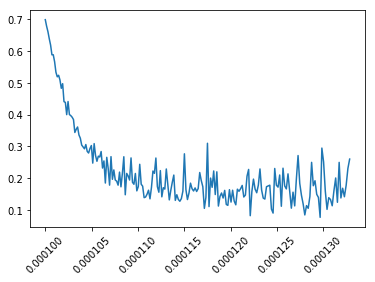

In [54]:
model = DenseNet(14, pretrained=pretrained, freeze=False).cuda()
lrs, losses  = lr_finder(model, 1, train_dl, min_lr=1e-4, max_lr=1e-1, early_stopping=200)

# Training definitions

In [62]:
def compute_AUCs(y, pred):
    AUROCs = []
    for i in range(N_CLASSES):
        auc_i = roc_auc_score(y[:, i].astype(int), pred[:, i])
        AUROCs.append(auc_i)
    return  np.mean(AUROCs)

def ave_auc(probs, ys):
    aucs = [roc_auc_score(ys[:,i], probs[:,i]) for i in range(probs.shape[1])]
    return np.mean(aucs), aucs   


def validate(model, valid_dl):
    
    model.eval()
    total = 0
    sum_loss = 0
    ys = []
    preds = []
    
    for x, y in valid_dl:
        
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y)
        
        batch = y.shape[0]
        sum_loss += batch * (loss.item())
        total += batch
        
        preds.append( out.detach().cpu().numpy())
        ys.append( y.long().cpu().numpy())

 
        
    preds = np.vstack(preds)
    ys = np.vstack(ys)
    mean_auc, aucs = ave_auc(preds, ys)
    
#     print('\n'.join([f'{m:.3f}' for m in auc])+'\n')
    
    return sum_loss / total, mean_auc, aucs

def train(n_epochs, train_dl, valid_dl, model, div_factor=25., max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in tqdm_notebook(range(n_epochs), ):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for i, (x, y) in enumerate(tqdm_notebook(train_dl, leave=False)):

            if unfreeze_during_loop:
                if i == first_unfreeze: model.unfreeze(1)
                if i == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch


        val_loss, measure, _ = validate(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

# Training

In [68]:
epochs = 8

In [67]:
# tiny version

N  = 2_000
tiny_df = train_df[:N]
transforms=[random_rotation(arc_width=20), filp(), random_crop(r_pix=8)]
tiny_dl = DataBatches(tiny_df, img_folder_path=img_folder_path,
                               transforms=transforms, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, tiny_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.2881 -  val loss 0.1628 AUC 0.6458


A Jupyter Widget

Ep. 2 - train loss 0.1509 -  val loss 0.1610 AUC 0.6857


A Jupyter Widget

Ep. 3 - train loss 0.1426 -  val loss 0.1681 AUC 0.6922


A Jupyter Widget

Ep. 4 - train loss 0.1292 -  val loss 0.1663 AUC 0.7042


A Jupyter Widget

Ep. 5 - train loss 0.1141 -  val loss 0.1712 AUC 0.6959


A Jupyter Widget

Ep. 6 - train loss 0.0938 -  val loss 0.1743 AUC 0.7089


A Jupyter Widget

Ep. 7 - train loss 0.0746 -  val loss 0.1814 AUC 0.7055


A Jupyter Widget

Ep. 8 - train loss 0.0628 -  val loss 0.1810 AUC 0.7026


In [70]:
# tiny version

class random_rotation_v2:
    """ Rotates an image by deg degrees

    Args: -
    """

    def __init__(self): pass

    def __call__(self, im, deg,
                 mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
        r, c, *_ = im.shape
        M = cv2.getRotationMatrix2D((c / 2, r / 2), deg, 1)
        return cv2.warpAffine(im, M, (c, r), borderMode=mode,
                              flags=cv2.WARP_FILL_OUTLIERS + interpolation)

    def options(self, x_shape):
        """Specify the random arguments to be generated every epoch.
        Images must be have same dimensions !
        """
        return {"deg": -1}

    def set_random_choices(self, N, x_shape):
        return {k: np.random.choice([-90,0,90], size=N, replace=True)  for k, v in self.options(x_shape).items()}


N  = 2_000
tiny_df = train_df[:N]
transforms=[random_rotation_v2(), random_rotation(arc_width=20), flip(), random_crop(r_pix=8)]
tiny_dl = DataBatches(tiny_df, img_folder_path=img_folder_path,
                               transforms=transforms, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, tiny_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.3406 -  val loss 0.1666 AUC 0.6493


A Jupyter Widget

Ep. 2 - train loss 0.1556 -  val loss 0.1735 AUC 0.6702


A Jupyter Widget

Ep. 3 - train loss 0.1525 -  val loss 0.1693 AUC 0.6736


A Jupyter Widget

Ep. 4 - train loss 0.1434 -  val loss 0.1644 AUC 0.6954


A Jupyter Widget

Ep. 5 - train loss 0.1352 -  val loss 0.1689 AUC 0.7035


A Jupyter Widget

Ep. 6 - train loss 0.1261 -  val loss 0.1664 AUC 0.6972


A Jupyter Widget

Ep. 7 - train loss 0.1152 -  val loss 0.1659 AUC 0.7107


A Jupyter Widget

Ep. 8 - train loss 0.1098 -  val loss 0.1655 AUC 0.7091


In [ ]:
# Whole dataset

transforms=[random_rotation(arc_width=20), flip(), random_crop(r_pix=8)]

train_dl = DataBatches(train_df, img_folder_path=img_folder_path,transforms=transforms,
                       shuffle=True, data=data, batch_size=batch_size, normalize=pretrained)

model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.1539 -  val loss 0.1467 AUC 0.7846


A Jupyter Widget

Ep. 2 - train loss 0.1402 -  val loss 0.1474 AUC 0.7900


A Jupyter Widget

Ep. 3 - train loss 0.1379 -  val loss 0.1452 AUC 0.7984


A Jupyter Widget

Ep. 4 - train loss 0.1339 -  val loss 0.1426 AUC 0.8193


A Jupyter Widget

In [ ]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path, transforms = True, 
                      shuffle = False, data=data, batch_size = batch_size, normalize=pretrained)
TTA_multilabel(model, test_dl)

In [ ]:
train_df = train_df.sample(frac=1)

for N in [50, 100, 5_000, 10_000, 20_000, 35_000, 50_000, 60_000, 77_880]:
    
    sampled_train_df = train_df[:N]
    
    train_dl = DataBatches(train_df, img_folder_path=img_folder_path,
                           transforms=True, shuffle=True, data=data,
                           batch_size=batch_size, half=False, normalize=pretrained)
    
    model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()
    save_path = SAVE_DIRECTORY/f"{pretrained}-{N}.pth"
    # save_path = SAVE_DIRECTORY / f"{pretrained}-{N}-{random_state}-unfreezing.pth"
    train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path,unfreeze_during_loop=(.1, .2) if freeze else None)

In [20]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = False, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)
validate(model, test_dl)

(0.20191780040408833,
 0.8164163548894331,
 [0.7777638937179043,
  0.8882716944725164,
  0.8331421478637311,
  0.6839344107757633,
  0.8366145269199207,
  0.7661666072832656,
  0.7252368098300768,
  0.8640024568362074,
  0.752993899915239,
  0.8507316063175169,
  0.9233914222053733,
  0.8275160380939851,
  0.7879706132917902,
  0.9120928409287741])

In [22]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = True, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)
TTA_test_metrics_chest(model, test_dl)

val loss 0.2021 and auc 0.8210


(0.20208021653882324, 0.8209861720227334)

In [18]:
model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()
save_path = SAVE_DIRECTORY/f"{pretrained}-77800.pth"
# save_path = SAVE_DIRECTORY / f"{pretrained}-{N}-{random_state}-unfreezing.pth"
train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path,unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.1535 -  val loss 0.1460 AUC 0.7735


A Jupyter Widget

Ep. 2 - train loss 0.1403 -  val loss 0.1490 AUC 0.7919


A Jupyter Widget

Ep. 3 - train loss 0.1379 -  val loss 0.1473 AUC 0.8027


A Jupyter Widget

Ep. 4 - train loss 0.1337 -  val loss 0.1427 AUC 0.8155


A Jupyter Widget

Ep. 5 - train loss 0.1295 -  val loss 0.1388 AUC 0.8338


A Jupyter Widget

Ep. 6 - train loss 0.1251 -  val loss 0.1369 AUC 0.8358


A Jupyter Widget

Ep. 7 - train loss 0.1200 -  val loss 0.1369 AUC 0.8411


A Jupyter Widget

IndexError: index 38728 is out of bounds for axis 0 with size 38728

In [215]:
model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()
save_path = SAVE_DIRECTORY/f"{pretrained}-77800-{random_state}.pth"
# save_path = SAVE_DIRECTORY / f"{pretrained}-{N}-{random_state}-unfreezing.pth"
train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path, bar=tqdm_notebook,
      unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

Ep. 1 - train loss 0.1529 -  val loss 0.1456 AUC 0.7908
Ep. 2 - train loss 0.1445 -  val loss 0.1478 AUC 0.7804
Ep. 3 - train loss 0.1399 -  val loss 0.1457 AUC 0.7900
Ep. 4 - train loss 0.1356 -  val loss 0.1409 AUC 0.8095
Ep. 5 - train loss 0.1315 -  val loss 0.1398 AUC 0.8125
Ep. 6 - train loss 0.1269 -  val loss 0.1382 AUC 0.8219
Ep. 7 - train loss 0.1218 -  val loss 0.1373 AUC 0.8233
Ep. 8 - train loss 0.1178 -  val loss 0.1374 AUC 0.8250
